# Tritonlytics Multilabel Classification - Standard S@W Themes

Experiments related to building a LM and multilabel classification model for survey comments captured in the Tritonlytics survey delivery system

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
from fastai.text import *   # Quick accesss to NLP functionality
from fastai.callbacks import *

import pdb
from tritonlytics import Metrics as metrics_util, DataGeneration as dg_util, PandasUtil as pd_util
from tritonlytics.evaluation import *
from tritonlytics.callbacks import RocAucEvaluation

import dill as pickle

import spacy
spacy_en = spacy.load('en')
spacy_es = spacy.load('es')

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [3]:
print(f'fastai version: {__version__}')

fastai version: 1.0.57


In [4]:
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Utility methods

In [5]:
def convert_to_snakecase(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('__', '_') 

In [6]:
# https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view : apostrophe lookup dict
appos_regex_repl = {
    r"\baren't\b" : "are not",
    r"\bcan't\b" : "cannot",
    r"\bcouldn't\b" : "could not",
    r"\bdidn't\b" : "did not",
    r"\bdoesn't\b" : "does not",
    r"\bdon't\b" : "do not",
    r"\bhadn't\b" : "had not",
    r"\bhasn't\b" : "has not",
    r"\bhaven't\b" : "have not",
    r"\bhe'd\b" : "he would",
    r"\bhe'll\b" : "he will",
    r"\bhe's\b" : "he is",
    r"\bi'd\b" : "I would",
    r"\bi'd\b" : "I had",
    r"\bi'll\b" : "I will",
    r"\bi'm\b" : "I am",
    r"\bisn't\b" : "is not",
    r"\bits\b" : "it is",
    r"\bit's\b" : "it is",
    r"\bit'll\b" : "it will",
    r"\bi've\b" : "I have",
    r"\blet's\b" : "let us",
    r"\bmightn't\b" : "might not",
    r"\bmustn't\b" : "must not",
    r"\bshan't\b" : "shall not",
    r"\bshe'd\b" : "she would",
    r"\bshe'll\b" : "she will",
    r"\bshe's\b" : "she is",
    r"\bshouldn't\b" : "should not",
    r"\bthat's\b" : "that is",
    r"\bthere's\b" : "there is",
    r"\bthey'd\b" : "they would",
    r"\bthey'll\b" : "they will",
    r"\bthey're\b" : "they are",
    r"\bthey've\b" : "they have",
    r"\bwe'd\b" : "we would",
    r"\bwe're\b" : "we are",
    r"\bweren't\b" : "were not",
    r"\bwe've\b" : "we have",
    r"\bwhat'll\b" : "what will",
    r"\bwhat're\b" : "what are",
    r"\bwhat's\b" : "what is",
    r"\bwhat've\b" : "what have",
    r"\bwhere's\b" : "where is",
    r"\bwho'd\b" : "who would",
    r"\bwho'll\b" : "who will",
    r"\bwho're\b" : "who are",
    r"\bwho's\b" : "who is",
    r"\bwho've\b" : "who have",
    r"\bwon't\b" : "will not",
    r"\bwouldn't\b" : "would not",
    r"\byou'd\b" : "you would",
    r"\byou'll\b" : "you will",
    r"\byou're\b" : "you are",
    r"\byou've\b" : "you have",
    r"\b're\b" : " are",
    r"\bwasn't\b" : "was not",
    r"\bwe'll\b" : "will",
    r"\bdidn't\b" : "did not",
    r"\btryin'\b" : "trying"
}

In [7]:
# based on https://www.kaggle.com/prashantkikani/pooled-gru-with-preprocessing
emoji_str_repls = {
    "&lt;3": " love ",
    ":]" : " happy ",
    "=)" : " happy ",
    "8)": " happy ",
    ":-)": " happy ",
    ":)": " happy ",
    "(-:": " happy ",
    "(:": " happy ",
    ":&gt;": " happy ",
    ":')": " happy ",
    "(:" : " happy ",
    ":d": " laughing ",
    ":dd": " laughing ",
    ";-)" : " wink ",
    ";)": " wink ",
    ":p": " playful ",
    ":o" : " surprise ",
    ":-(": " sad ",
    ":(": " sad ",
    "=(" : " sad ",
    "):" : " sad ",
    ":/": " skeptical ",
    ":s": " skeptical ",
    ":-s": " skeptical ",
    "^^": " nervous ",
    "^_^": " nervous ",
    "-_-" : " shame ",
}

In [8]:
spelling_regex_repls = {
    # abbreviations
    r"\bacctg\b" : "acct",
    r"\badd'l\b" : "additional",
    r"\br\s\b": "are",
    r"\bu\s\b": "you ",
    r"\b\sm\s\b ": "am",
    r"'cause\b" : "because",
    r"\b(ha)+\b": "haha",
    r"\b(he)+\b": "haha",
    r"\bya+y\b": "yay",
    r"\bwa+y\b": "way",
    r"\bf'real\b" : "for real",
    r"\bgr8\b" : "great",
    r"\bintl\b" : "int'l",
    # common misspellings
    r"\bbailable\b" : "available",
    r"\babilty\b" : "ability",
    r"\babsolutly\b" : "absolutely",
    r"\babsoultely\b" : "absolutely",
    r"\bacces\b" : "access",
    r"\baccesability\b" : "accessibility",
    r"\baccesbility\b" : "accessibility",
    r"\baccesibility\b" : "accessibility",
    r"\baccessability\b" : "accessibility",
    r"\baccessbility\b" : "accessibility",
    r"\baccesable\b" : "accessible",
    r"\baccesible\b" : "accessible",
    r"\baccessable\b" : "accessible",
    r"\bacessible\b" : "accessible",
    r"\bassessable\b" : "availability",
    r"\baccidently\b" : "accidentally",
    r"\baccomadate\b" : "accommodate",
    r"\baccomdate\b" : "accommodate",
    r"\baccomidate\b" : "accommodate",
    r"\baccomodate\b" : "accommodate",
    r"\baccomadating\b" : "accommodating",
    r"\baccomidating\b" : "accommodating",
    r"\baccomodating\b" : "accommodating",
    r"\baccomadations\b" : "accommodations",
    r"\baccomodation\b" : "accommodation",
    r"\baccouting\b" : "accounting",
    r"\baccross\b" : "across",
    r"\badd'l\b" : "additional",
    r"\badditonal\b" : "additional",
    r"\baddtionally\b" : "additionally",
    r"\badminstration\b" : "administration",
    r"\badminstrative\b" : "administrative",
    r"\badminstrator\b" : "administrator",
    r"\badress\b" : "address",
    r"\badvancment\b" : "advancement",
    r"\badvertized\b" : "advertised",
    r"\bafforable\b" : "affordable",
    r"\bafordable\b" : "affordable",
    r"\bafterall\b" : "after all",
    r"\bafterhours\b" : "after hours",
    r"\baggresive\b" : "aggressive",
    r"\bagressive\b" : "aggressive",
    r"\bagressions\b" : "aggressions",
    r"\balittle\b" : "a little",
    r"\balll\b" : "all",
    r"\balloted\b" : "allotted",
    r"\ballthough\b" : "although",
    r"\balthought\b" : "although",
    r"\ballways\b" : "always",
    r"\balos\b" : "also",
    r"\balot\b" : "a lot",
    r"\balotted\b" : "allotted",
    r"\bammount\b" : "amount",
    r"\bammounts\b" : "amounts",
    r"\bamoung\b" : "among",
    r"\bamoungst\b" : "amongst",
    r"\bannouncment\b" : "announcement",
    r"\baparments\b" : "apartments",
    r"\bapparrel\b" : "apparel",
    r"\bappartment\b" : "apartment",
    r"\bappriciate\b" : "appreciate",
    r"\bassitance\b" : "assistance",
    r"\bassitant\b" : "assistant",
    r"\batleast\b" : "at least",
    r"\battentative\b" : "attentive",
    r"\battrocious\b" : "atrocious",
    r"\bavaiable\b" : "available",
    r"\bavaible\b" : "available",
    r"\bavailabe\b" : "available",
    r"\bavailble\b" : "available",
    r"\bavailiable\b" : "available",
    r"\bavailible\b" : "available",
    r"\bavaliable\b" : "available",
    r"\bavalible\b" : "available",
    r"\bavilable\b" : "available",
    r"\bavailiability\b" : "availability",
    r"\bavailabiltiy\b" : "availability",
    r"\bavailabilty\b" : "availability",
    r"\bavailablility\b" : "availability",
    r"\bavailablity\b" : "availability",
    r"\bavailibility\b" : "availability",
    r"\bavaliability\b" : "availability",
    r"\bavaliablity\b" : "availability",
    r"\bavalibility\b" : "availability",
    r"\bactivies\b" : "activities",
    r"\bactivites\b" : "activities",
    r"\bactualy\b" : "actually",
    r"\bacutally\b" : "actually",
    r"\bammenities\b" : "amenities",
    r"\bantoher\b" : "another",
    r"\bassitant\b" : "assistant",
    r"\baswell\b" : "as well",
    r"\baweful\b" : "awful",
    r"\bawfull\b" : "awful",
    r"\bawsome\b" : "awesome",
    r"\bbeacuse\b" : "because",
    r"\bbearly\b" : "barely",
    r"\bbeaurocracy\b" : "bureaucracy",
    r"\bbeaurocratic\b" : "bureaucratic",
    r"\bbecasue\b" : "because",
    r"\bbecuase\b" : "because",
    r"\bbecuse\b" : "because",
    r"\bbefor\b" : "before",
    r"\bbeggining\b" : "beginning",
    r"\bbegining\b" : "beginning",
    r"\bbeleive\b" : "believe",
    r"\bbelive\b" : "believe",
    r"\bbenificial\b" : "beneficial",
    r"\bbenifit\b" : "benefit",
    r'\bbugetary\b' : "budgetary",
    r'\bbuiding\b' : "building",
    r'\bbuidling\b' : "building",
    r'\bbuisness\b' : "business",
    r'\bbuliding\b' : "building",
    r"\bbureacracy\b" : "bureaucracy",
    r"\bburitto\b" : "burrito",
    r"\bbussiness\b" : "business",
    r"\bcalender\b" : "calendar",
    r"\bcan;t\b" : "can't",
    r"\bcasher\b" : "cashier",
    r'\bcatagories\b' : "categories",
    r'\bcatagory\b' : "category",
    r"\bcheapter\b" : "cheaper",
    r"\bcheeper\b" : "cheaper",
    r'\bclasss\b' : "clas",
    r'\bclassses\b' : "classes",
    r"\bcleaniness\b" : "cleanliness",
    r"\bcmapus\b" : "campus",
    r'\bcofee\b' : "coffee",
    r'\bcoffe\b' : "coffee",
    r'\bcollegue\b' : "colleague",
    r'\bcoment\b' : "comment",
    r'\bcoments\b' : "comments",
    r'\bcomming\b' : "coming",
    r'\bcommittment\b' : "commitment",
    r'\bcommment\b' : "comment",
    r'\bcommuication\b' : "communication",
    r'\bcommunter\b' : "commuter",
    r'\bcommunters\b' : "commuters",
    r'\bcomotion\b' : "commotion",
    r'\bcomparision\b' : "comparison",
    r'\bcompatability\b' : "compatibility",
    r'\bcompatable\b' : "compatible",
    r'\bcompetative\b' : "competitive",
    r'\bcompetetive\b' : "competitive",
    r'\bcompetive\b' : "competitive",
    r'\bcompletly\b' : "completely",
    r"\bcomraderie\b" : "camaraderie",
    r'\bcomradery\b' : "camaraderie",
    r'\bcomunication\b' : "communication",
    r'\bcomunity\b' : "community",
    r'\bconcious\b' : "conscious",
    r'\bcondusive\b' : "conducive",
    r'\bconection\b' : "connection",
    r"\bconfortable\b" : "comfortable",
    r'\bconsistant\b' : "consistent",
    r'\bconsistantly\b' : "consistently",
    r'\bconsistenly\b' : "consistently",
    r'\bcontinously\b' : "continuously",
    r'\bcontruction\b' : "construction",
    r'\bconveinent\b' : "convenient",
    r'\bconveinient\b' : "convenient",
    r'\bconveniant\b' : "convenient",
    r'\bconveniece\b' : "convenience",
    r'\bconveninent\b' : "convenient",
    r'\bconvienance\b' : "convenience",
    r'\bconvienant\b' : "convenient",
    r'\bconvience\b' : "convenience",
    r'\bconvienence\b' : "convenience",
    r'\bconvienent\b' : "convenient",
    r'\bconvienet\b' : "convenient",
    r'\bconvienience\b' : "convenience",
    r'\bconvienient\b' : "convenient",
    r'\bconvient\b' : "convenient",
    r'\bconviently\b' : "conveniently",
    r'\bconvinence\b' : "convenience",
    r'\bconvinent\b' : "convenient",
    r'\bconvinience\b' : "convenience",
    r'\bconvinient\b' : "convenient",
    r'\bcorteous\b' : "courteous",
    r'\bcostodial\b' : "custodial",
    r'\bcoureous\b' : "courteous",
    r'\bcourtis\b' : "courteous",
    r'\bcouteous\b' : "courteous",
    r'\bcovenient\b' : "convenient",
    r'\bcroweded\b' : "crowded",
    r'\bcurteous\b' : "courteous",
    r'\bcurtesy\b' : "courtesy",
    r'\bcurtious\b' : "courteous",
    r"\bdeaprtment\b" : "department",
    r"\bdecission\b" : "decision",
    r'\bdefinately\b' : "definitely",
    r'\bdefinetely\b' : "definitely",
    r'\bdefinetly\b' : "definitely",
    r'\bdefinitley\b' : "definitely",
    r'\bdefinitly\b' : "definitely",
    r'\bdelievered\b' : "delivered",
    r'\bdeliverers\b' : "deliveries",
    r'\bdeparment\b' : "department",
    r'\bdeparments\b' : "department",
    r'\bdepartement\b' : "department",
    r"\bdepartment\(s\b" : "departments",
    r'\bdepartmet\b' : "department",
    r'\bdepratment\b' : "department",
    r"\bdeptartment\b" : "department",
    r'\bdescrimination\b' : "discrimination",
    r'\bdesireable\b' : "desirable",
    r"\bdiffernt\b" : "different",
    r"\bdiffrent\b" : "different",
    r'\bdinig\b' : "dining",
    r'\bdirverse\b' : "diverse",
    r'\bdisapointed\b' : "disappointed",
    r'\bdisapointing\b' : "disappointing",
    r'\bdisasterous\b' : "disastrous",
    r'\bdisatisfied\b' : "dissatisfied",
    r'\bdisbursment\b' : "disbursement",
    r'\bdisbursments\b' : "disbursements",
    r'\bdiscretely\b' : "discreetly",
    r'\bdiscusting\b' : "disgusting",
    r'\bdisfunctional\b' : "dysfunctional",
    r'\bdispensors\b' : "dispensers",
    r'\bdispersement\b' : "disbursement",
    r'\bdissapointed\b' : "disappointed",
    r'\bdissapointing\b' : "disappointing",
    r'\bdissapointment\b' : "disappointment",
    r'\bdissappointed\b' : "disappointed",
    r'\bdissappointing\b' : "disappointing",
    r'\bdissatified\b' : "dissatisfied",
    r'\bdiveristy\b' : "diversity",
    r'\bdivison\b' : "division",
    r'\bdivsion\b' : "division",
    r"\bdoens't\b" : "doesn't",
    r"\bdoes't\b" : "doesn't",
    r"\bdoesn;t\b" : "doesn't",
    r"\bdon;t\b" : "don't",
    r'\bdonot\b' : "do not",
    r"\bdosen't\b" : "doesn't",
    r"\bdosent\b" : "doesn't",
    r'\bdumbells\b' : "dumbbells",
    r'\bdurring\b' : "during",
    r"\beatting\b" : "eating",
    r"\beduation\b" : "education",
    r'\beffeciency\b' : "efficiency",
    r'\beffecient\b' : "efficient",
    r'\befficency\b' : "efficiency",
    r'\befficent\b' : "efficient",
    r'\beffiecient\b' : "efficient",
    r'\beimplying\b' : "implying",
    r'\bembarassed\b' : "embarrassed",
    r'\bembarassing\b' : "embarrassing",
    r'\bembarassment\b' : "embarrassment",
    r'\bemploee\b' : "employee",
    r'\bemploye\b' : "employee",
    r'\bemployee\(s\b' : "employees",
    r'\bemployeed\b' : "employed",
    r'\bemployement\b' : "employment",
    r'\bemployes\b' : "employees",
    r'\bemployess\b' : "employees",
    r'\bemplyee\b' : "employee",
    r'\bemplyees\b' : "employees",
    r'\bempolyees\b' : "employees",
    r'\bencoutered\b' : "encountered",
    r'\benought\b' : "enough",
    r'\benrollement\b' : "enrollment",
    r'\benviorment\b' : "environment",
    r'\benviornment\b' : "environment",
    r'\benvirnment\b' : "environment",
    r'\benviroment\b' : "environment",
    r'\benvironement\b' : "environment",
    r'\bequiped\b' : "equipped",
    r'\bespcially\b' : "especially",
    r'\bespecailly\b' : "especially",
    r'\bespecialy\b' : "especially",
    r'\bespeically\b' : "especially",
    r"\besthetically\b" : "aesthetically ",
    r"\bethinicity\b" : "ethnicity",
    r"\bevaulation\b" : "evaluation",
    r"\beventhough\b" : "even though",
    r'\beverday\b' : "every day",
    r'\beverthing\b' : "everything",
    r'\beveryones\b' : "everyones",
    r'\beverythings\b' : "everythings",
    r'\beveryway\b' : "every way",
    r'\beveyone\b' : "everyone",
    r'\beveything\b' : "everything",
    r'\bevrything\b' : "everything",
    r'\bexcelent\b' : "excellent",
    r'\bexcellant\b' : "excellent",
    r'\bexellent\b' : "excellent",
    r'\bexhorbitant\b' : "exorbitant",
    r'\bexistance\b' : "existence",
    r'\bexpecially\b' : "especially",
    r'\bexpensice\b' : "expensive",
    r'\bexpereince\b' : "experience",
    r'\bexperiance\b' : "experience",
    r'\bexperince\b' : "experience",
    r'\bexpierence\b' : "experience",
    r'\bexpirence\b' : "experience",
    r'\bexplaination\b' : "explanation",
    r'\bexremely\b' : "extremely",
    r'\bextemely\b' : "extremely",
    r'\bextention\b' : "extension",
    r'\bextermely\b' : "extremely",
    r'\bextreamly\b' : "extremely",
    r'\bextrememly\b' : "extremely",
    r'\bextremly\b' : "extremely",
    r"\bfacilites\b" : "facilities",
    r'\bfacilties\b' : "facilities",
    r'\bfacilty\b' : "facility",
    r'\bfaculity\b' : "faculty",
    r'\bfacutly\b' : "faculty",
    r'\bfiancial\b' : "financial",
    r"\bfinacial\b" : "financial",
    r"\bfirendly\b" : "friendly",
    r'\bflexability\b' : "flexibility",
    r'\bflexibilty\b' : "flexibility",
    r'\bflexiblity\b' : "flexibility",
    r"\bflourescent\b" : "fluorescent",
    r'\bfreindly\b' : "friendly",
    r'\bfreqency\b' : "frequency",
    r'\bfreqent\b' : "frequent",
    r'\bfriednly\b' : "friendly",
    r'\bfrusterating\b' : "frustrating",
    r'\bfrusturating\b' : "frustrating",
    r'\bfustrating\b' : "frustrating",
    r'\bgovenor\b' : "governor",
    r"\bgraffitti\b" : "graffiti",
    r"\bgrafitti\b" : "graffiti",
    r"\bgreatful\b" : "grateful",
    r"\bguarenteed\b" : "guaranteed",
    r"\bguidlines\b" : "guidelines",
    r"\bguranteed\b" : "guaranteed",
    r"\bhappend\b" : "happened",
    r'\bharrass\b' : "harass",
    r'\bharrassed\b' : "harassed",
    r'\bharrassing\b' : "harassing",
    r'\bharrassment\b' : "harassment",
    r"\bhavn't\b" : "haven't",
    r'\bhealtheir\b' : "healthier",
    r'\bhealthly\b' : "healthy",
    r'\bhealtier\b' : "healthier",
    r'\bhealty\b' : "healthy",
    r'\bheathy\b' : "healthy",
    r'\bheirarchy\b' : "hierarchy",
    r'\bhelful\b' : "helpful",
    r'\bhelpfull\b' : "helpful",
    r'\bhelpul\b' : "helpful",
    r'\bhighschool\b' : "high school",
    r'\bhighschools\b' : "high schools",
    r'\bhorendous\b' : "horrendous",
    r'\bhorible\b' : "horrible",
    r'\bhouseing\b' : "housing",
    r'\bi"m\b' : "i'm",
    r'\bi"ve\b' : "i've",
    r'\bimplimented\b' : "implemented",
    r'\bimporve\b' : "improve",
    r'\bimposible\b' : "impossible",
    r'\bimprovment\b' : "improvement",
    r'\bimprovments\b' : "improvements",
    r'\bincompetant\b' : "incompetent",
    r'\binconsistant\b' : "inconsistent",
    r'\binconveinent\b' : "nconvenient",
    r'\binconvience\b' : "inconvenience",
    r'\binconvienent\b' : "nconvenient",
    r'\binconvienient\b' : "nconvenient",
    r'\binconvient\b' : "nconvenient",
    r'\binconvinient\b' : "nconvenient",
    r'\bindentify\b' : "identify",
    r'\bindependant\b' : "independent",
    r'\bindividual\(s\b' : "individuals",
    r'\binforced\b' : "enforced",
    r'\binformaiton\b' : "information",
    r'\binformtion\b' : "information",
    r'\binfront\b' : "in front",
    r'\binnout\b' : "in-n-out",
    r'\binsentive\b' : "incentive",
    r'\binsufficent\b' : "insufficient",
    r'\binterenet\b' : "internet",
    r'\binterent\b' : "internet",
    r'\bintermural\b' : "intramural",
    r'\bintramurals\b' : "intramurals",
    r'\binvironment\b' : "environment",
    r'\bissue\(s\b' : "issues",
    r'\bit;s\b' : "it's",
    r'\bitem\(s\b' : "items",
    r"\bjob\(s\b" : "jobs",
    r'\bknowledable\b' : "knowledgeable",
    r'\bknowledeable\b' : "knowledgeable",
    r'\bknowledegable\b' : "knowledgeable",
    r'\bknowledgable\b' : "knowledgeable",
    r'\bknowledgably\b' : "knowledgeably",
    r'\bknowledgeably\b' : "knowledgeably",
    r'\bknowledgeble\b' : "knowledgeable",
    r'\bknowlegable\b' : "knowledgeable",
    r'\bknowlegeable\b' : "knowledgeable",
    r'\bliek\b' : "like",
    r'\blieke\b' : "like",
    r'\blimted\b' : "limited",
    r'\bmaintainance\b' : "maintenance",
    r'\bmaintaince\b' : "maintenance",
    r'\bmaintainence\b' : "maintenance",
    r'\bmaintanance\b' : "maintenance",
    r'\bmaintance\b' : "maintenance",
    r'\bmaintanence\b' : "maintenance",
    r'\bmaintenace\b' : "maintenance",
    r'\bmaintenances\b' : "maintenance",
    r'\bmaintence\b' : "maintenance",
    r'\bmaintenece\b' : "maintenance",
    r'\bmaintenence\b' : "maintenance",
    r'\bmaitenance\b' : "maintenance",
    r'\bmanager\(s\b' : "managers",
    r'\bmanagment\b' : "management",
    r'\bmanangement\b' : "management",
    r'\bmangement\b' : "management",
    r'\bmangers\b' : "managers",
    r'\bmanuever\b' : "maneuver",
    r'\bmintues\b' : "minutes",
    r'\bmoblie\b' : "mobile",
    r'\bmulitple\b' : "multiple",
    r'\bn\?a\b' : "n/a",
    r'\bna\b' : "n/a",
    r'\bneccessary\b' : "necessary",
    r'\bnecesary\b' : "necessary",
    r'\bneedes\b' : "needs",
    r'\bneeed\b' : "need",
    r'\bnonexistant\b' : "nonexistent",
    r'\bnothig\b' : "nothing",
    r'\bnothjng\b' : "nothing",
    r'\bnoticable\b' : "noticeable",
    r'\bobsurd\b' : "absurd",
    r'\bocassional\b' : "occasional",
    r'\boccassion\b' : "occasion",
    r'\boccassional\b' : "occasional",
    r'\boccassionally\b' : "occasionally",
    r'\boccassions\b' : "occasions",
    r'\boccations\b' : "occasions",
    r'\boccurances\b' : "occurrences",
    r'\boccured\b' : "occurred",
    r'\boccuring\b' : "occurring",
    r'\boccurr\b' : "occur",
    r'\bofcourse\b' : "of course",
    r'\bofferred\b' : "offered",
    r'\bopinon\b' : "opinion",
    r'\bopitions\b' : "options",
    r'\boportunities\b' : "opportunities",
    r'\bopperation\b' : "operation",
    r'\boppertunities\b' : "opportunities",
    r'\boppinion\b' : "opinion",
    r'\bopportunites\b' : "opportunities",
    r'\bopportunties\b' : "opportunities",
    r'\boppotunities\b' : "opportunities",
    r'\boppurtunities\b' : "opportunities",
    r'\boppurtunity\b' : "opportunity",
    r'\borgnized\b' : "organized",
    r'\boutragous\b' : "outrageous",
    r'\bpage\(s\b' : "pages",
    r'\bpakages\b' : "packages",
    r'\bparkibg\b' : "parking",
    r'\bparkig\b' : "parking",
    r'\bparkign\b' : "parking",
    r'\bparkinglots\b' : "parking lots",
    r'\bpartime\b' : "part-time",
    r'\bparttime\b' : "part-time",
    r'\bpatroling\b' : "patrolling",
    r'\bpeopel\b' : "people",
    r'\bpermitt\b' : "permit",
    r'\bperson\(s\b' : "persons",
    r'\bpersonel\b' : "personnel",
    r'\bpersonell\b' : "personnel",
    r'\bpharamcy\b' : "pharmacy",
    r'\bpleasent\b' : "pleasant",
    r'\bplently\b' : "plenty",
    r'\bplesant\b' : "pleasant",
    r'\bpositon\b' : "position",
    r'\bposses\b' : "possess",
    r'\bpossition\b' : "position",
    r'\bpostion\b' : "position",
    r'\bpostions\b' : "positions",
    r'\bpostition\b' : "position",
    r'\bpostive\b' : "positive",
    r'\bpractioner\b' : "practitioner",
    r'\bpractioners\b' : "practitioners",
    r'\bprefered\b' : "preferred",
    r'\bpreferrably\b' : "preferably",
    r'\bpreform\b' : "perform",
    r'\bpreforming\b' : "performing",
    r'\bpricess\b' : "prices",
    r'\bpriciples\b' : "principles",
    r'\bpricy\b' : "pricey",
    r'\bprking\b' : "parking",
    r'\bproceedures\b' : "procedures",
    r'\bprocurment\b' : "procurement",
    r'\bprofessionaly\b' : "professionally",
    r'\bproffessional\b' : "professional",
    r'\bproffit\b' : "profit",
    r'\bprofitt\b' : "profit",
    r'\bprogam\b' : "program",
    r'\bpromissed\b' : "promised",
    r'\bpublically\b' : "publicly",
    r'\bqucik\b' : "quick",
    r'\bquestion\(s\b' : "questions",
    r'\bquestionaire\b' : "questionnaire",
    r'\breall\b' : "really",
    r'\brealy\b' : "really",
    r'\breccomend\b' : "recommend",
    r'\breccommend\b' : "recommend",
    r'\breceieve\b' : "receive",
    r'\breciept\b' : "receipt",
    r'\breciepts\b' : "receipts",
    r'\brecieve\b' : "receive",
    r'\brecieved\b' : "received",
    r'\brecieves\b' : "receives",
    r'\brecieving\b' : "receiving",
    r'\brecived\b' : "received",
    r'\brecomend\b' : "recommend",
    r'\brecomended\b' : "recommended",
    r'\brediculous\b' : "ridiculous",
    r'\brediculously\b' : "ridiculously",
    r'\brefered\b' : "referred",
    r'\brefering\b' : "referring",
    r'\bregeants\b' : "regents",
    r'\bregistar\b' : "regisrtar",
    r'\bregistars\b' : "regisrtars",
    r'\bregulary\b' : "regularly",
    r'\breimbursment\b' : "reimbursement",
    r'\breponse\b' : "response",
    r'\breponsive\b' : "responsive",
    r'\brepresentitive\b' : "representative",
    r'\breserach\b' : "research",
    r'\bresonable\b' : "reasonable",
    r'\bresouces\b' : "resources",
    r'\bresourses\b' : "resources",
    r'\bresponsed\b' : "responded",
    r'\bresponsibilites\b' : "responsibilites",
    r'\bresponsiblities\b' : "responsibilites",
    r'\bresponsiblity\b' : "responsibility",
    r'\brestaraunts\b' : "restaurants",
    r'\brestraunts\b' : "restaurants",
    r'\brestuarant\b' : "restaurant",
    r'\brestuarants\b' : "restaurants",
    r'\bresturant\b' : "restaurant",
    r'\bresturants\b' : "restaurants",
    r'\bridiculus\b' : "ridiculous",
    r'\briduculous\b' : "ridiculous",
    r'\broomate\b' : "roommate",
    r'\broomates\b' : "roommates",
    r'\bsaleries\b' : "salaries",
    r'\bsandwhich\b' : "sandwich",
    r'\bsandwhiches\b' : "sandwiches",
    r'\bsandwitches\b' : "sandwiches",
    r'\bsatifaction\b' : "satisfaction",
    r'\bsatified\b' : "satisfisatisfieded",
    r'\bsattelite\b' : "satellite",
    r'\bsceience\b' : "science",
    r'\bschedual\b' : "schedule",
    r'\bseemless\b' : "seamless",
    r'\bselction\b' : "selection",
    r'\bsenority\b' : "seniority",
    r'\bsensative\b' : "sensitive",
    r'\bsensored\b' : "censored",
    r'\bseperate\b' : "separate",
    r'\bseperation\b' : "separation",
    r'\bserivce\b' : "service",
    r'\bserivces\b' : "services",
    r'\bserive\b' : "service",
    r'\bserives\b' : "services",
    r'\bservicesi\b' : "services",
    r'\bservidces\b' : "services",
    r'\bservive\b' : "survive",
    r'\bservives\b' : "survives",
    r'\bseverly\b' : "severely",
    r'\bsevice\b' : "service",
    r'\bsevices\b' : "services",
    r'\bshcool\b' : "school",
    r'\bshoud\b' : "should",
    r'\bshoudl\b' : "should",
    r'\bshutttle\b' : "shuttle",
    r'\bsimiliar\b' : "similar",
    r'\bsomeitmes\b' : "sometimes",
    r'\bsomeone\(s\b' : "someones",
    r'\bsomeones\b' : "someones",
    r'\bsometiems\b' : "sometimes",
    r'\bsomone\b' : "someone",
    r'\bsomthing\b' : "something",
    r'\bsophmore\b' : "sophomore",
    r'\bspecialy\b' : "especially",
    r'\bstafff\b' : "staff",
    r'\bstatment\b' : "statement",
    r'\bstong\b' : "strong",
    r'\bstongly\b' : "strongly",
    r'\bstoping\b' : "stopping",
    r'\bstrabucks\b' : "starbucks",
    r'\bstressfull\b' : "stressful",
    r'\bstructure\(s\b' : "structures",
    r'\bstucture\b' : "structure",
    r'\bstuctures\b' : "structures",
    r'\bstuden\b' : "student",
    r'\bstudent\(s\b' : "students",
    r'\bstudetns\b' : "students",
    r'\bstudnet\b' : "student",
    r'\bstudnets\b' : "students",
    r'\bsucess\b' : "success",
    r'\bsudent\b' : "student",
    r'\bsudents\b' : "students",
    r'\bsuperintendant\b' : "superintendent",
    r'\bsuperviser\b' : "supervisor",
    r'\bsupervisor\(s\b' : "supervisors",
    r'\bsupervisores\b' : "supervisors",
    r'\bsuport\b' : "support",
    r'\bsupples\b' : "supplies",
    r'\bsuppossed\b' : "supposed",
    r'\bsuprised\b' : "surprised",
    r'\bsuvey\b' : "survey",
    r'\bsytem\b' : "system",
    r'\bthats\b' : "that's",
    r"\bthe're\b" : "they're",
    r'\btheives\b' : "thieves",
    r'\bthiefs\b' : "thieves",
    r'\bthreating\b' : "threatening",
    r'\bthroughly\b' : "thoroughly",
    r'\bthrought\b' : "throughout",
    r'\bthroughtout\b' : "throughout",
    r'\btodays\b' : "today's",
    r'\btraing\b' : "training",
    r'\btrainning\b' : "training",
    r'\btranfers\b' : "transfers",
    r'\btransfered\b' : "transferred",
    r'\btransfering\b' : "transferring",
    r'\btransporation\b' : "transportation",
    r'\btransportaion\b' : "transportation",
    r'\btransportations\b' : "transportations",
    r'\btransportion\b' : "transportation",
    r'\btrashbags\b' : "trash bags",
    r'\btrashcans\b' : "trash cans",
    r'\btremedously\b' : "tremendously",
    r'\btshirt\b' : "t-shirt",
    r'\btshirts\b' : "t-shirts",
    r'\btution\b' : "tuition",
    r'\btutition\b' : "tuition",
    r'\bunaccessible\b' : "inaccessible",
    r'\bunconvenient\b' : "inconvenient",
    r'\bunecessary\b' : "unnecessary",
    r'\bunflexible\b' : "inflexible",
    r'\bunforseen\b' : "unforeseen",
    r'\buniverisity\b' : "university",
    r'\buniveristy\b' : "university",
    r'\buniverity\b' : "university",
    r'\bunknowledgeable\b' : "unknowledgable",
    r'\bunneccessary\b' : "unnecessary",
    r'\bunrealiable\b' : "unreliable",
    r'\buntill\b' : "until",
    r'\bunversity\b' : "university",
    r'\buseability\b' : "usability",
    r'\busefull\b' : "useful",
    r'\bususally\b' : "usually",
    r'\bvaccum\b' : "vacuum",
    r'\bvaccuum\b' : "vacuum",
    r'\bvaction\b' : "vacation",
    r'\bvacume\b' : "vacuum",
    r'\bvariaty\b' : "variety",
    r'\bvarities\b' : "varieties",
    r'\bvarity\b' : "variety",
    r'\bvegeterian\b' : "vegetarian",
    r'\bvegitarian\b' : "vegetarian",
    r'\bvegitarians\b' : "vegetarians",
    r'\bvegtables\b' : "vegetables",
    r'\bventillation\b' : "ventilation",
    r'\bveriety\b' : "variety",
    r'\bvisted\b' : "visited",
    r'\bvistor\b' : "visitor",
    r'\bvistors\b' : "visitors",
    r'\bweeekends\b' : "weekends",
    r'\bwierd\b' : "weird",
    r'\bwirless\b' : "wireless",
    r'\bwithdrawl\b' : "withdrawal",
    r'\bwoudl\b' : "would",
    r"\bwoudn't\b" : "wouldn't",
    r"\bthier\b" : "their",
    r"\bappartments\b" : "apartments",
    r"\bbenifits\b" : "benefits",
    r"\bexistant\b" : "existent",
    r"\bsaftey\b" : "safety",
    r'\bdon"t\b' : "don't",
}

In [9]:
weirdchar_str_repls = {
    "#39;" : "'",   
    'amp;' : '&',   
    '#146;' : "'",   
    'nbsp;' : ' ',   
    '#36;' : '$',   
    '\\n' : "\n",   
    'quot;' : "'",   
    '’' : "'",   
    "´" : "'",
    "`" : "'",
    '`' : "'", 
    '´' : "'", 
    '“' : '"',   
    '”' : '"',   
    '<br />' : "\n",   
    '\\"' : '"',   
    '<unk>' : 'u_n',   
    ' @.@ ' : '.',   
    ' @-@ ' : '-',   
    '\\' : ' \\ ',   
    '•' : '-'
}

In [10]:
# does regex replace making the substitution the same case
def re_replace(word, replacement, text):
    def func(match):
        g = match.group()
        if g.islower(): return replacement.lower()
        if g.istitle(): return replacement.title()
        if g.isupper(): return replacement.upper()
        return replacement      
    
    return re.sub(word, func, text, flags=re.I)

# define regex and string replacements
re_repls = {}  # e.g., { **spelling_regex_repls } 
str_repls = {} # e.g., { **weirdchar_str_repls }

def make_replacements(t:str) -> str:
    # replace based on regexs (keeping case) and then strings
    for k, v in re_repls.items(): t = re_replace(k, v, t)
    for k, v in str_repls.items(): t = t.replace(k, t)
    return t

# ensure am|pm is considered it own token (7:00pm > 7:00 pm, 7am-10pm > 7 am - 10 pm))
def fix_ampm(t:str) -> str:
    re_ampm = re.compile(r'(\d+)(am|pm|am\-|pm\-|a\.m\.|p\.m\.|a\.m\.\-|p\.m\.\-)')    
    return re_ampm.sub(r'\1 \2 ', t)

# try to handle places where a new sentence doesn't begin with a space (e.g., I like dogs.I like cats)
# without breaking apart things like urls and emails
def fix_sentence_ends(t:str) -> str:
    re_sentend = re.compile(r'(?<!www)\.((?!com|edu|org|net|m\b)[a-zA-Z]+)(?!(@|\.(com|edu|org|net)))\b') 
    return re_sentend.sub(r'. \1 ', t)

# separate hyphen|tilde if it is at beginning of letter/digit
def fix_hyphenated_words(t:str) -> str:
    re_hypword = re.compile(r'\s(\-+|~+)([a-zA-Z0-9])')
    return re_hypword.sub(r' \1 \2', t)


# prepend custom tokenization rules to defaults
custom_tok_rules = defaults.text_pre_rules + [make_replacements, fix_ampm, fix_sentence_ends, fix_hyphenated_words]

# use this customized Tokenizer for qualitative data
tokenizer = Tokenizer(pre_rules=custom_tok_rules)

## Configuration

In [11]:
# various default, LM, and classification paths
PATH = Path('../data')
CLEAN_DATA_PATH = Path('../data/clean')

LM_PATH = PATH/'lm'
CLS_PATH = PATH/'classification'
STANDARD_THEME_PATH = CLS_PATH/'standard_themes'
STANDARD_THEME_SAW_PATH = STANDARD_THEME_PATH/'saw'

(LM_PATH/'models').mkdir(parents=True, exist_ok=True)
(LM_PATH/'tmp').mkdir(exist_ok=True)

(STANDARD_THEME_SAW_PATH/'models').mkdir(parents=True, exist_ok=True)
(STANDARD_THEME_SAW_PATH/'tmp').mkdir(exist_ok=True)

In [12]:
# basic columns
lm_dtypes = { 
    'Id': int, 'QuestionAnsID': int, 'AnswerText': str, 'AnswerText_NonEnglish': str, 'Language': str,
    
    'SurveyID': int, 'SurveyTypeID': int, 'BenchmarkSurveyType': str, 'ClientId': str,'RspID': int,
    
    'QuestionCategoryAbbr': str, 'QuestionText': str, 'QuestionClass': str, 
    
    'QuestionCategoryID': float, 'QuestionReportAbbr': str, 'QuestionCategoryLabel': str, 
    'BenchmarkLevel1': str, 'BenchmarkLevel2': str, 'BenchmarkLevel3': str, 'ClientBenchmarkLevel': str,
    
    'GroupCode': float, 'GroupID': str, 
    'GroupLevel1Code': float, 'GroupLevel1Name': str,
    'GroupLevel2Code': float, 'GroupLevel2Name': str,
    'GroupLevel3Code': float, 'GroupLevel3Name': str,
    'GroupLevel4Code': float, 'GroupLevel4Name': str,
    'GroupLevel5Code': float, 'GroupLevel5Name': str,
    'GroupLevel6Code': float, 'GroupLevel6Name': str,
    'GroupLevel7Code': float, 'GroupLevel7Name': str,
    'GroupLevel8Code': float, 'GroupLevel8Name': str,
}

lm_dtypes_sc = { convert_to_snakecase(k):v for k,v in lm_dtypes.items() }

# standard saw themes
standard_theme_saw_dtypes = { 
    'adequate_staffing': int,
    'advancement_and_training_opportunities': int,
    'appropriate_stress_work_assigned_equitably': int,
    'benefits': int,
    'better_ways_recognized_participate_in_decisions': int,
    'career_advancement': int,
    'committed_to_diversity': int,
    'communicates_essential_information': int,
    'ethical_conduct_perform_responsibilities_spirit_of_cooperation': int,
    'evaluated_fairly': int,
    'experienced_discrimination': int,
    'facilities_workspace_safety': int,
    'faculty_value_contributions': int,
    'favoritism_cliques': int,
    'fear_of_retaliation_negative_consequences': int,
    'feel_valued_by_department': int,
    'flexibility_work_life_balance': int,
    'good_use_of_skills': int,
    'have_necessary_tools': int,
    'have_voice_on_campus_valued_member_of_ucsd': int,
    'internal_processes_effective': int,
    'parking_transportation': int,
    'salary_pay': int,
    'satisfied_with_diversity_progams': int,
    'supervisor_effectiveness_resolves_staff_issues': int
}

# date columns
date_cols = []
    

STANDARD_THEME_SAW_LABELS = list(standard_theme_saw_dtypes.keys())

In [13]:
vocab = pickle.load(open(LM_PATH/'vocab.pkl', 'rb'))

In [14]:
len(vocab.itos)

39904

## Classifier

The classifier is basically a linear layer custom head on top of the LM backbone

In [15]:
chunksize = 24000

bptt, em_sz, nh, nl = 70, 400, 1150, 3
bsz = 80
wd = 1e-7

In [16]:
# define what text columns to use (can be multiple)
corpus_cols = ['answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '' #'_cleaned'

In [17]:
train_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'train.csv')
valid_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'test.csv')

Remove any rows whre the "corpus_cols" are nan

In [18]:
train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

In [19]:
STANDARD_THEME_SAW_LABELS

['adequate_staffing',
 'advancement_and_training_opportunities',
 'appropriate_stress_work_assigned_equitably',
 'benefits',
 'better_ways_recognized_participate_in_decisions',
 'career_advancement',
 'committed_to_diversity',
 'communicates_essential_information',
 'ethical_conduct_perform_responsibilities_spirit_of_cooperation',
 'evaluated_fairly',
 'experienced_discrimination',
 'facilities_workspace_safety',
 'faculty_value_contributions',
 'favoritism_cliques',
 'fear_of_retaliation_negative_consequences',
 'feel_valued_by_department',
 'flexibility_work_life_balance',
 'good_use_of_skills',
 'have_necessary_tools',
 'have_voice_on_campus_valued_member_of_ucsd',
 'internal_processes_effective',
 'parking_transportation',
 'salary_pay',
 'satisfied_with_diversity_progams',
 'supervisor_effectiveness_resolves_staff_issues']

In [20]:
# 11/15/2018 - currently have to put all labels into a single column
# train_df['labels'] = train_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1]), axis=1)
# valid_df['labels'] = valid_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1], axis=1)

train_df['labels'] = train_df[STANDARD_THEME_SAW_LABELS].apply(
    lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
valid_df['labels'] = valid_df[STANDARD_THEME_SAW_LABELS].apply(
    lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)

train_df[['labels'] + STANDARD_THEME_SAW_LABELS].head()

,labels,adequate_staffing,advancement_and_training_opportunities,appropriate_stress_work_assigned_equitably,benefits,better_ways_recognized_participate_in_decisions,career_advancement,committed_to_diversity,communicates_essential_information,ethical_conduct_perform_responsibilities_spirit_of_cooperation,evaluated_fairly,experienced_discrimination,facilities_workspace_safety,faculty_value_contributions,favoritism_cliques,fear_of_retaliation_negative_consequences,feel_valued_by_department,flexibility_work_life_balance,good_use_of_skills,have_necessary_tools,have_voice_on_campus_valued_member_of_ucsd,internal_processes_effective,parking_transportation,salary_pay,satisfied_with_diversity_progams,supervisor_effectiveness_resolves_staff_issues
0,parking_transportation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,fear_of_retaliation_negative_consequences salary_pay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,appropriate_stress_work_assigned_equitably faculty_value_contributions,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,favoritism_cliques supervisor_effectiveness_resolves_staff_issues,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,faculty_value_contributions,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
cls_processor = [
    TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize),
    NumericalizeProcessor(vocab=vocab)
]

data_clas = (ItemLists(path=STANDARD_THEME_SAW_PATH,
                     train=TextList.from_df(
                         train_df, path=STANDARD_THEME_SAW_PATH, cols=corpus_cols, processor=cls_processor),
                     valid=TextList.from_df(
                         valid_df, path=STANDARD_THEME_SAW_PATH, cols=corpus_cols, processor=cls_processor)
                    )
             .label_from_df(cols='labels', classes=STANDARD_THEME_SAW_LABELS, label_delim=' ')
             .databunch(bs=bsz)
          )

data_clas.save(f'data_cls_standard_theme_saw.pkl')

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BCEWithLogitsLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [22]:
data_clas = load_data(STANDARD_THEME_SAW_PATH, f'data_cls_standard_theme_saw.pkl', bs=bsz)

In [23]:
data_clas.train_ds.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [24]:
print(data_clas.train_ds.x[0])
print(data_clas.train_ds.y[0])

xxbos xxmaj the hassle and expense of parking is a huge drawback to working here .
parking_transportation


In [25]:
print(len(data_clas.train_ds), len(data_clas.train_ds.vocab.itos))
print(len(data_clas.valid_ds), len(data_clas.valid_ds.vocab.itos))

4336 39904
482 39904


In [26]:
it = iter(data_clas.train_dl)

In [27]:
batch = next(it)
print(batch[0].size())
print(batch[1].size())
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 467])
torch.Size([80, 25])
torch.Size([80, 467]) torch.cuda.LongTensor torch.Size([80, 25]) torch.cuda.FloatTensor 80


In [28]:
' '.join([ data_clas.train_ds.vocab.itos[idx] for idx in batch[0][0,:] ])

"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotism because they are both product of such practices . \\ r \n 

In [29]:
data_clas.show_batch()

text,target
"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues
"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues
"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues
"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues
"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues


### Configure a forward or backwards run

In [91]:
backwards = True

m_suf = '_multilabel' #'_cleaned'
m_pre = 'bwd_' if (backwards) else 'fwd_'

data_clas = load_data(STANDARD_THEME_SAW_PATH, f'data_cls_standard_theme_saw.pkl', bs=bsz, backwards=backwards)

### Build the classifier (baseline)

In [92]:
class MultiLabelClassifier(nn.Module):
    
    def __init__(self, y_range=None):
        super().__init__()
        self.y_range = y_range
    
    def forward(self, input):
        x, raw_outputs, outputs = input
        x = torch.sigmoid(x)
        if (self.y_range):
            x = x * (self.y_range[1] - self.y_range[0])
            x = x + self.y_range[0]
        
        return x, raw_outputs, outputs

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [93]:
beta = 1
start = 0.1

def fscore(preds, targs):
    return metrics_util.best_fscore(preds, targs, beta, start=start)
    
def opt_th(preds, targs):
    return metrics_util.best_fthresh(preds, targs, beta=beta, start=start)

def multilbl_accuracy(preds, targs):
    return metrics_util.multi_accuracy(preds, targs, beta=beta, start=start)

In [94]:
try: learn.purge(); learn = None; torch.cuda.empty_cache();
except: pass

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type EmbeddingDropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for con

In [95]:
learn = None; gc.collect()
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, pretrained=False,
                                drop_mult=0.5, bptt=bptt, lin_ftrs=[50], ps=[0.1],
                                alpha=2., beta=1.)

In [96]:
learn.model.add_module('2', MultiLabelClassifier())

learn.clip = 25.
learn.loss_func = F.binary_cross_entropy
learn.metrics = [opt_th, fscore, multilbl_accuracy]

learn.model_dir = 'models'

In [97]:
best_model_cb = partial(SaveModelCallback, monitor='fscore', mode='max', name=f'{m_pre}cls_bestmodel{m_suf}')
# best_model_cb = partial(SaveModelCallback, monitor='val_loss', mode='min', name=f'{lm_pre}cls_bestmodel{exp_suffix}')

learn.callback_fns.append(best_model_cb)
# learn.callback_fns.append(RocAucEvaluation)

In [98]:
# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {STANDARD_THEME_SAW_PATH/'models/'}  

In [99]:
learn.load_encoder(f'{m_pre}lm_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (4336 items)
x: TextList
xxbos xxmaj the hassle and expense of parking is a huge drawback to working here .,xxbos xxmaj the cost of living is rising substantially , while the rate of pay has remained relatively stagnant . xxmaj each year , it 's becoming less attractive to work here as there is simply not enough monetary compensation to help offset the skyrocketing costs . i am a represented employee ( not by choice ) , and have not received the 3 % yearly raise for the last year ( soon to be 2 years now ) . xxmaj on top of that , the 3 % does n't even cover the yearly cost of inflation adjustments . i wish there were performance - based raises , as well . i really do like my job , and the area has so much to offer , but it 's more and more becoming an issue of affordability on whether or not i can work here . i have no hope of home ownership working here at the pay rate i make - paired with limited upward mobility - and the compensa

In [100]:
best_model_path = STANDARD_THEME_SAW_PATH/f'models/{m_pre}cls_bestmodel{m_suf}*'
!rm {best_model_path}

In [101]:
# learn.model

In [102]:
lr = 5e-1
wd = 0.

In [103]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


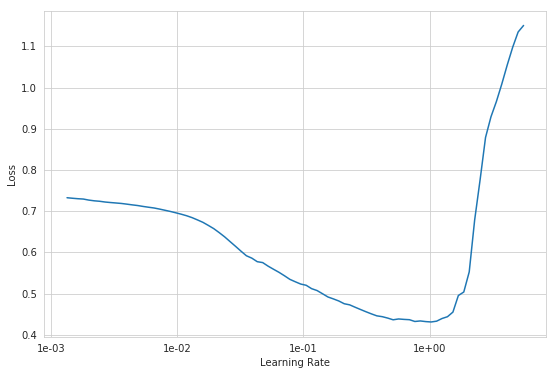

In [104]:
learn.lr_find(lr/1000, wd=wd)
learn.recorder.plot()

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [105]:
%%time
learn.fit_one_cycle(1, lr, wd=wd)

epoch,train_loss,valid_loss,opt_th,fscore,multilbl_accuracy,time
0,0.337298,0.280711,0.120207,0.295873,0.805809,00:07


Better model found at epoch 0 with fscore value: 0.29587337374687195.
CPU times: user 4.72 s, sys: 3.26 s, total: 7.98 s
Wall time: 8.26 s


In [106]:
learn.save(f'{m_pre}cls_last_ft{m_suf}')

In [107]:
# will load the best when training ends automaticall ... #learn = learn.load(f'{lm_pre}cls_last_ft{exp_suffix}')

In [108]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,opt_th,fscore,multilbl_accuracy,time
0,0.263119,0.235096,0.176515,0.423441,0.862656,00:08


Better model found at epoch 0 with fscore value: 0.4234413802623749.


In [109]:
learn.save(f'{m_pre}cls_last2_ft{m_suf}')

In [110]:
# will load the best when training ends automaticall ... #learn = learn.load(f'{lm_pre}cls_last2_ft{exp_suffix}')

In [111]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,opt_th,fscore,multilbl_accuracy,time
0,0.236335,0.219806,0.176639,0.464570,0.864896,00:12


Better model found at epoch 0 with fscore value: 0.4645703136920929.


In [112]:
learn.save(f'{m_pre}cls_last3_ft{m_suf}')

In [113]:
# will load the best when training ends automaticall ... 
# learn = learn.load(f'{lm_pre}cls_last3_ft{exp_suffix}')

In [114]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,opt_th,fscore,multilbl_accuracy,time
0,0.223621,0.217230,0.185021,0.474804,0.872365,00:18
1,0.221405,0.210576,0.199959,0.487568,0.885145,00:16
2,0.214745,0.399888,0.213320,0.508725,0.892863,00:15
3,0.206680,0.381340,0.219751,0.539771,0.899336,00:16
4,0.190002,0.358144,0.228133,0.586439,0.913029,00:16
5,0.169967,0.335032,0.219627,0.631166,0.924398,00:17
6,0.149669,0.142122,0.220041,0.667170,0.933361,00:16
7,0.131714,0.349313,0.221203,0.671595,0.932697,00:16
8,0.114512,0.092620,0.216307,0.714128,0.950788,00:14
9,0.097096,0.082810,0.209751,0.749874,0.960830,00:17


Better model found at epoch 0 with fscore value: 0.4748038351535797.
Better model found at epoch 1 with fscore value: 0.487568199634552.
Better model found at epoch 2 with fscore value: 0.5087254047393799.
Better model found at epoch 3 with fscore value: 0.5397709608078003.
Better model found at epoch 4 with fscore value: 0.5864392518997192.
Better model found at epoch 5 with fscore value: 0.6311655640602112.
Better model found at epoch 6 with fscore value: 0.6671700477600098.
Better model found at epoch 7 with fscore value: 0.671594500541687.
Better model found at epoch 8 with fscore value: 0.7141279578208923.
Better model found at epoch 9 with fscore value: 0.7498736381530762.
Better model found at epoch 10 with fscore value: 0.7534667253494263.
Better model found at epoch 11 with fscore value: 0.7602566480636597.
Better model found at epoch 12 with fscore value: 0.7695699334144592.
Better model found at epoch 13 with fscore value: 0.7747269868850708.
Better model found at epoch 14 w

In [115]:
learn.save(f'{m_pre}cls{m_suf}')

Export model for inference

In [116]:
learn.export(file=f'{m_pre}export_clas{m_suf}.pkl')

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SequentialRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MultiBatchEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AWD_LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for 

Use it for inference

In [117]:
inf_learn = load_learner(STANDARD_THEME_SAW_PATH, file=f'{m_pre}export_clas{m_suf}.pkl')

In [118]:
inf_learn.data.single_ds.y.classes = STANDARD_THEME_SAW_LABELS

In [119]:
inf_learn.predict('The pay is too low and parking stinks on campus.  Where is my salary increase?')

(MultiCategory fear_of_retaliation_negative_consequences,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]),
 tensor([4.2412e-05, 8.5759e-04, 1.7485e-04, 1.8304e-03, 1.5657e-05, 2.8879e-05,
         8.6170e-05, 4.4344e-07, 6.6069e-03, 7.1303e-03, 3.8416e-06, 1.6510e-04,
         3.6100e-04, 9.4636e-05, 8.7537e-01, 2.0582e-03, 2.7369e-06, 1.3288e-05,
         6.4577e-06, 2.0792e-04, 6.0016e-06, 2.7751e-01, 1.7402e-01, 1.0125e-03,
         3.3323e-04]))

Review final validation loss for best model

In [120]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(DatasetType.Valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
print(f'Validation Loss (per label): {loss.mean(dim=0)}')

Validation Loss: 0.06444920599460602
Validation Loss (per label): tensor([0.0944, 0.0359, 0.0726, 0.0296, 0.0131, 0.0872, 0.1325, 0.0116, 0.1273,
        0.0262, 0.0621, 0.0348, 0.1218, 0.0096, 0.1544, 0.0679, 0.0252, 0.0049,
        0.0209, 0.0417, 0.0464, 0.0188, 0.1605, 0.0583, 0.1535])


In [121]:
print(STANDARD_THEME_SAW_LABELS)

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions', 'career_advancement', 'committed_to_diversity', 'communicates_essential_information', 'ethical_conduct_perform_responsibilities_spirit_of_cooperation', 'evaluated_fairly', 'experienced_discrimination', 'facilities_workspace_safety', 'faculty_value_contributions', 'favoritism_cliques', 'fear_of_retaliation_negative_consequences', 'feel_valued_by_department', 'flexibility_work_life_balance', 'good_use_of_skills', 'have_necessary_tools', 'have_voice_on_campus_valued_member_of_ucsd', 'internal_processes_effective', 'parking_transportation', 'salary_pay', 'satisfied_with_diversity_progams', 'supervisor_effectiveness_resolves_staff_issues']


In [122]:
learn.predict("There are not enough people to do the work")

(MultiCategory adequate_staffing,
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]),
 tensor([9.9560e-01, 1.0586e-05, 1.4719e-01, 7.4670e-06, 1.1853e-03, 1.3315e-01,
         5.4519e-04, 2.9136e-05, 2.3947e-04, 5.1984e-05, 3.8640e-03, 7.5112e-03,
         1.7416e-02, 5.3993e-06, 4.5697e-01, 5.6170e-03, 4.3096e-05, 4.5888e-04,
         5.6096e-04, 4.9093e-06, 9.7054e-06, 2.7729e-04, 1.3139e-02, 4.2906e-03,
         1.4041e-06]))

## Save models, csvs, to zip and download (optional)

In [123]:
from IPython.display import FileLink

In [124]:
# !zip -r models.zip {LM_PATH}/models/ {CLS_PATH}/models  -x {LM_PATH}/models/lstm_wt103/\*

# FileLink('models.zip')

In [125]:
# !zip verbatims-csvs.zip {PATH}/verbatims.csv {PATH}/verbatims-entities.csv {PATH}/verbatims-meta.csv

# FileLink('verbatims-csvs.zip')

## Review predictions

### Predict sentiment for our validation dataset, including the actual document

In [126]:
# predictions for a single model using the learner's model and data loaders
learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
probs, targs, docs = get_cls_predictions(learn, DatasetType.Valid, vocab)

probs.shape, targs.shape, len(docs)

(torch.Size([482, 25]), torch.Size([482, 25]), 482)

In [127]:
data_clas.valid_ds.y.items.shape, data_clas.valid_ds.y.c, data_clas.valid_ds.y.classes

((482,),
 25,
 ['adequate_staffing',
  'advancement_and_training_opportunities',
  'appropriate_stress_work_assigned_equitably',
  'benefits',
  'better_ways_recognized_participate_in_decisions',
  'career_advancement',
  'committed_to_diversity',
  'communicates_essential_information',
  'ethical_conduct_perform_responsibilities_spirit_of_cooperation',
  'evaluated_fairly',
  'experienced_discrimination',
  'facilities_workspace_safety',
  'faculty_value_contributions',
  'favoritism_cliques',
  'fear_of_retaliation_negative_consequences',
  'feel_valued_by_department',
  'flexibility_work_life_balance',
  'good_use_of_skills',
  'have_necessary_tools',
  'have_voice_on_campus_valued_member_of_ucsd',
  'internal_processes_effective',
  'parking_transportation',
  'salary_pay',
  'satisfied_with_diversity_progams',
  'supervisor_effectiveness_resolves_staff_issues'])

In [128]:
# determine optimal threshold based on desired f-score
threshold_f05 = metrics_util.best_fthresh(probs, targs, beta=0.5, start=0.1, end=.3).item()
threshold_f1 = metrics_util.best_fthresh(probs, targs, beta=1, start=0.1, end=.3).item()
threshold_f2 = metrics_util.best_fthresh(probs, targs, beta=2, start=0.1, end=.3).item()

threshold_f05, threshold_f1, threshold_f2

(0.28999999165534973, 0.25999999046325684, 0.18000000715255737)

In [129]:
res = fbeta(probs, targs, thresh=threshold_f1, beta=1, sigmoid=False)
res

tensor(0.7913)

In [130]:
from sklearn import metrics

In [131]:
res = metrics.fbeta_score(targs, (probs > threshold_f1), beta=1, average='samples')
res

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.7912861573649955

In [132]:
preds = ((probs > threshold_f1).byte() == targs.byte()).float().mean()
preds.item()

0.9791701436042786

In [133]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_thresh(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_thresh(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_thresh(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9800000190734863, 0.9791701436042786, 0.9748547673225403)

### Review classifier

In [134]:
import sklearn
from sklearn import metrics
print (sklearn.__version__)

0.20.2


In [135]:
probs.shape, targs.shape

(torch.Size([482, 25]), torch.Size([482, 25]))

In [136]:
eval_targs = targs.flatten() # targs[:,0]
eval_probs = probs.flatten() # probs[:,0]

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [137]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(metrics.accuracy_score(targs, (probs > threshold_f1)))

0.6929460580912863


In [138]:
print(metrics.accuracy_score(eval_targs, (eval_probs > threshold_f1).float()))

0.9791701244813278


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [139]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 10929


In [140]:
most_freq_class_count / len(eval_targs)

0.9069709543568465

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [141]:
print(metrics.cohen_kappa_score(eval_targs, (eval_probs > threshold_f1).float()))

0.8792221532099861


#### Confusion Matrix

Describes the performance of a classification model

In [142]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [143]:
cm = metrics.confusion_matrix(eval_targs, (eval_probs > threshold_f1).float())

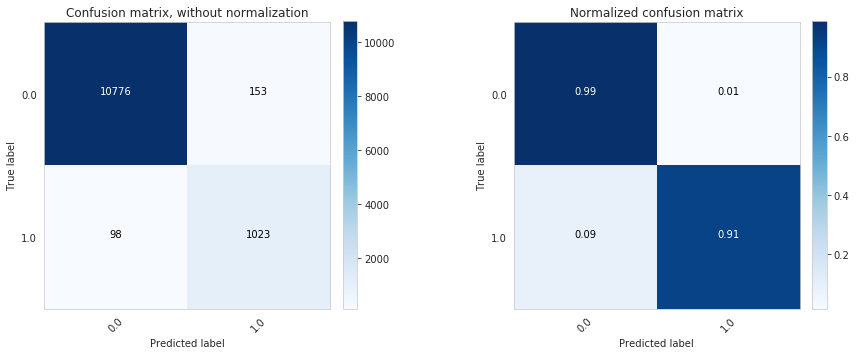

In [144]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [145]:
print(metrics.classification_report(eval_targs, (eval_probs > threshold_f1).float(), [0,1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10929
           1       0.87      0.91      0.89      1121

   micro avg       0.98      0.98      0.98     12050
   macro avg       0.93      0.95      0.94     12050
weighted avg       0.98      0.98      0.98     12050



### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

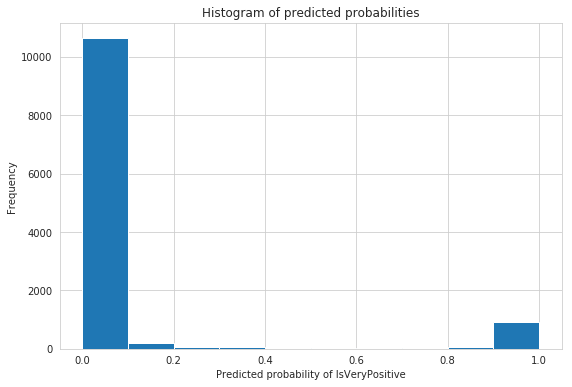

In [146]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of IsVeryPositive')
plt.ylabel('Frequency')

Demonstrates how you can **decrease** the threshold for predicting label in order to **increase the sensitivity** of the classifier

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [147]:
fpr, tpr, thresholds = metrics.roc_curve(eval_targs, eval_probs)

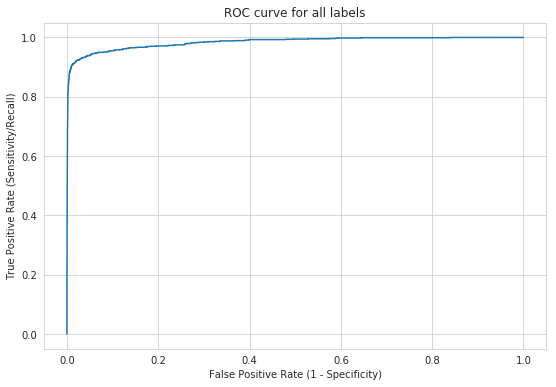

In [148]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [149]:
print(metrics.roc_auc_score(eval_targs, eval_probs))

0.9841253361144011


Let's look at things label by label ...

In [150]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(STANDARD_THEME_SAW_LABELS):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = metrics.roc_auc_score(lbl_targs, lbl_probs)
    
    fpr, tpr, thresholds = metrics.roc_curve(lbl_targs, lbl_probs)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = metrics.accuracy_score(lbl_targs, (lbl_probs > v))
        label_metrics[lbl_name]['cohen_kappas'][k] = metrics.cohen_kappa_score(lbl_targs, (lbl_probs > v))
        label_metrics[lbl_name]['confusion_matrices'][k] = metrics.confusion_matrix(lbl_targs, (lbl_probs > v))
        
        precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(lbl_targs, (lbl_probs > v))
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

ADEQUATE_STAFFING

Null Accuracy:	0.8609958506224067
AUC Score:	0.9757957201942096

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.966804979253112	0.9647302904564315	0.9647302904564315	
Cohen's Kappa:	0.8679316368120013	0.8605086650097035	0.8605086650097035	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9902              0.9711              0.9805              415                 
1                   0.84                0.9403              0.8873              67                  
avg/total           0.9151              0.9557              0.9339              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9901              0.9687              0.9793              415                 
1                   0.8289              0.9403              0.8811              

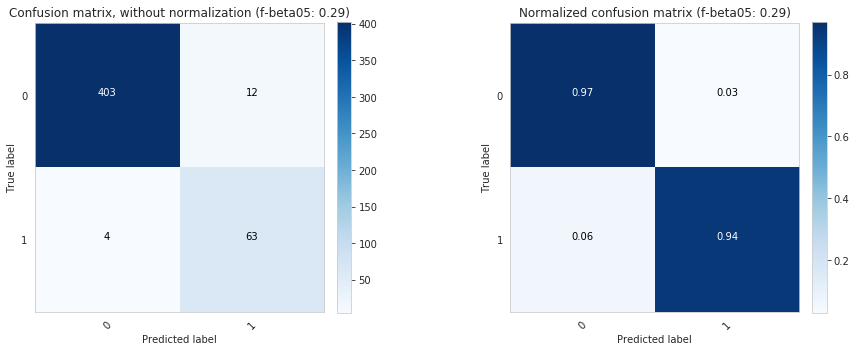

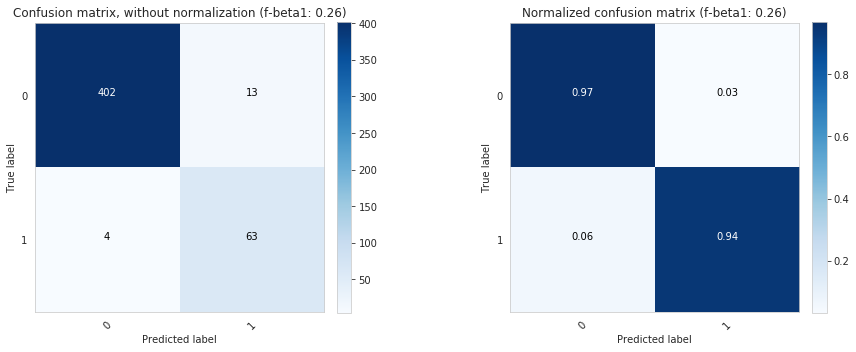

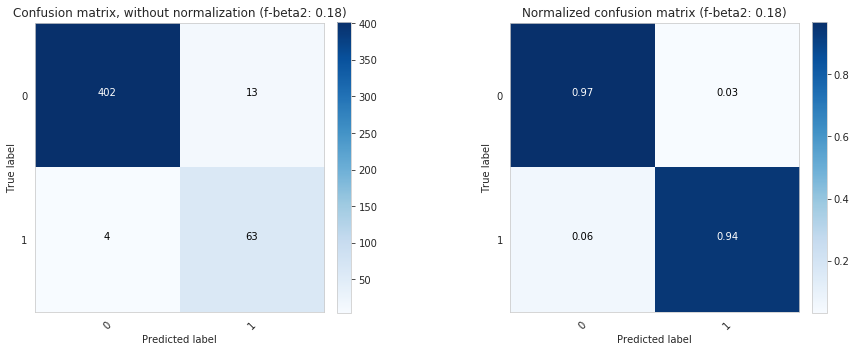



ROC Curve:


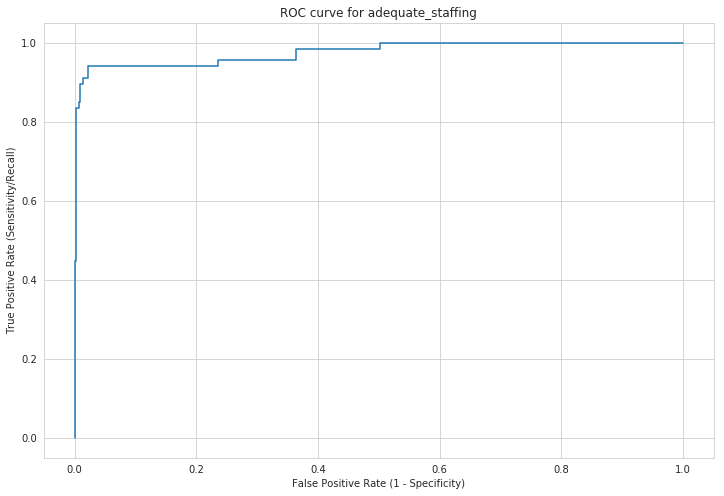

Predicted Probability Distribution:


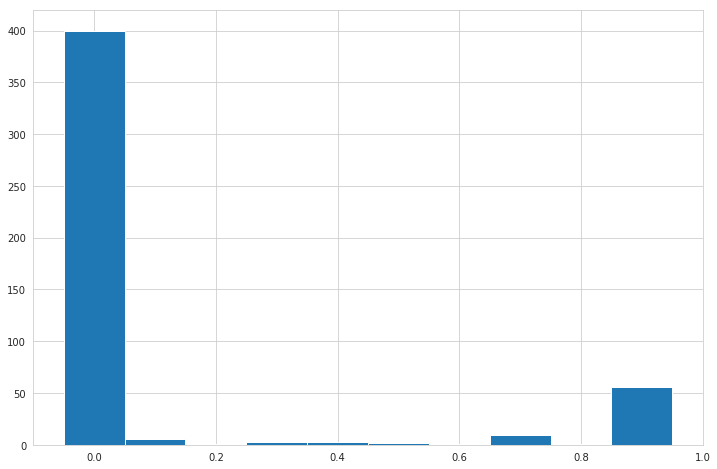



----------------------------------------------------------------------------------------------------


ADVANCEMENT_AND_TRAINING_OPPORTUNITIES

Null Accuracy:	0.9336099585062241
AUC Score:	0.9949305555555554

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9875518672199171	0.9875518672199171	0.983402489626556	
Cohen's Kappa:	0.8995833333333333	0.8995833333333333	0.8734576004200578	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9933              0.9933              0.9933              450                 
1                   0.9062              0.9062              0.9062              32                  
avg/total           0.9498              0.9498              0.9498              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9933              0.9933         

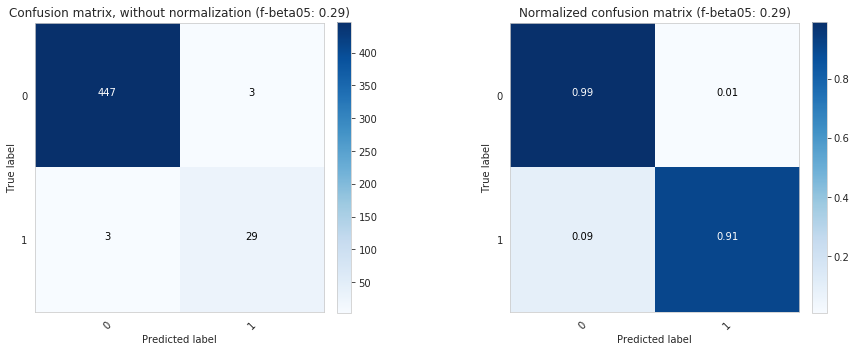

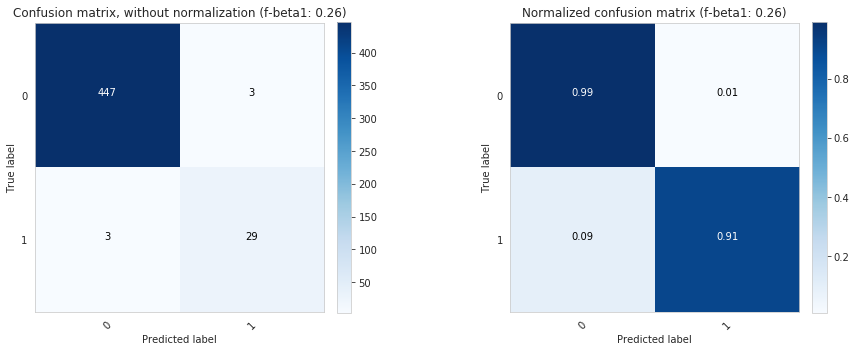

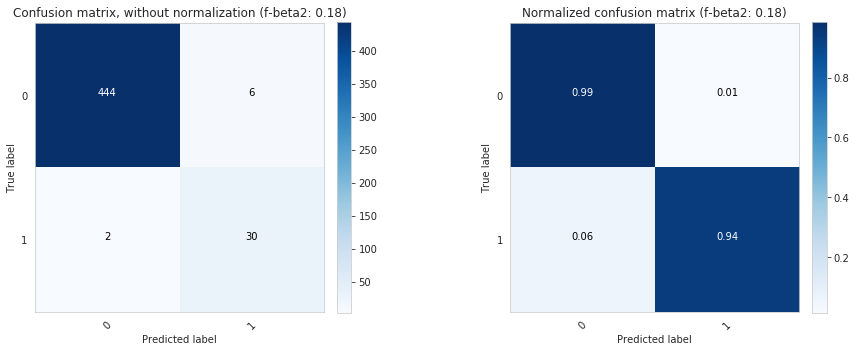



ROC Curve:


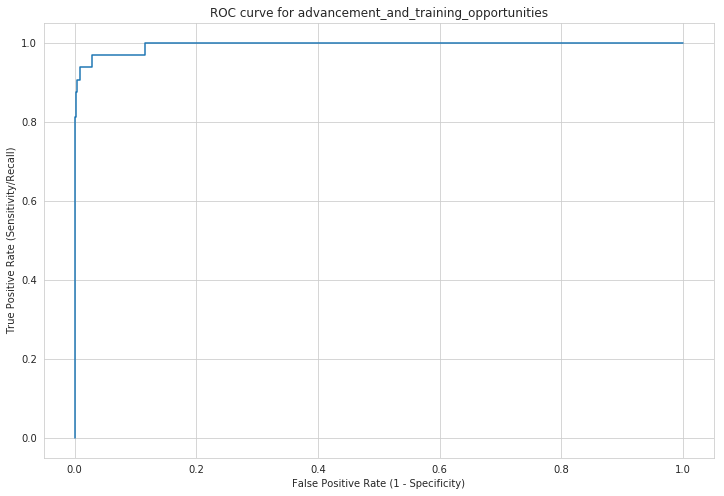

Predicted Probability Distribution:


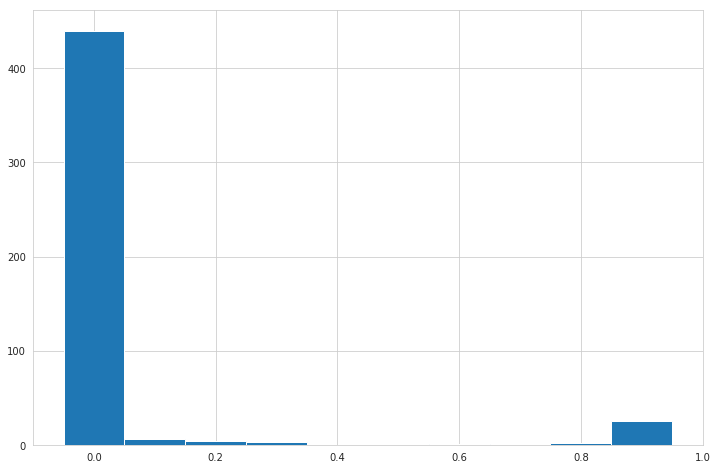



----------------------------------------------------------------------------------------------------


APPROPRIATE_STRESS_WORK_ASSIGNED_EQUITABLY

Null Accuracy:	0.8651452282157677
AUC Score:	0.982180409518539

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9771784232365145	0.9771784232365145	0.9688796680497925	
Cohen's Kappa:	0.9028261427367033	0.9028261427367033	0.870823655529748	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.988               0.9856              0.9868              417                 
1                   0.9091              0.9231              0.916               65                  
avg/total           0.9485              0.9543              0.9514              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.988               0.9856      

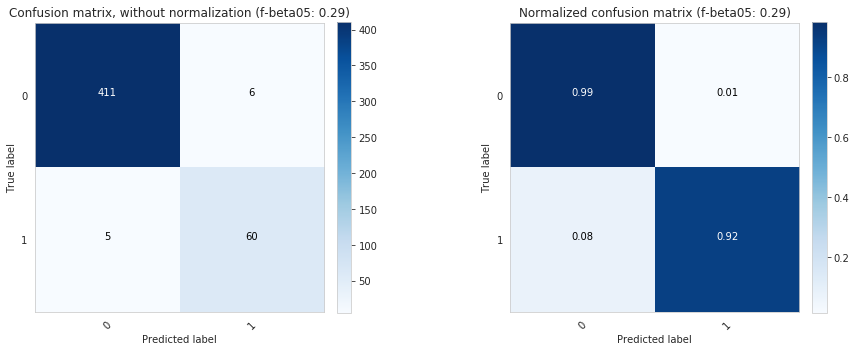

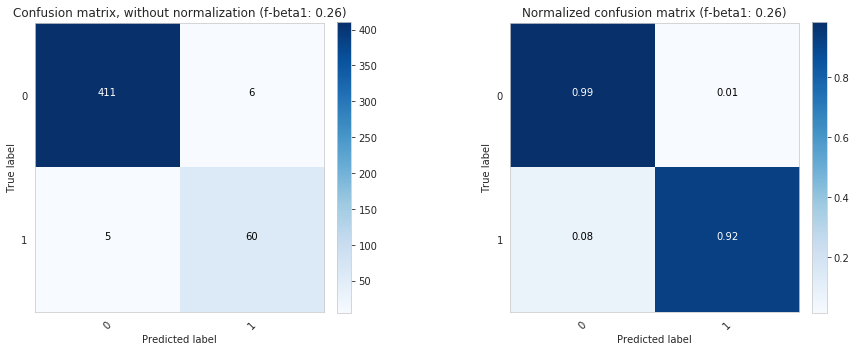

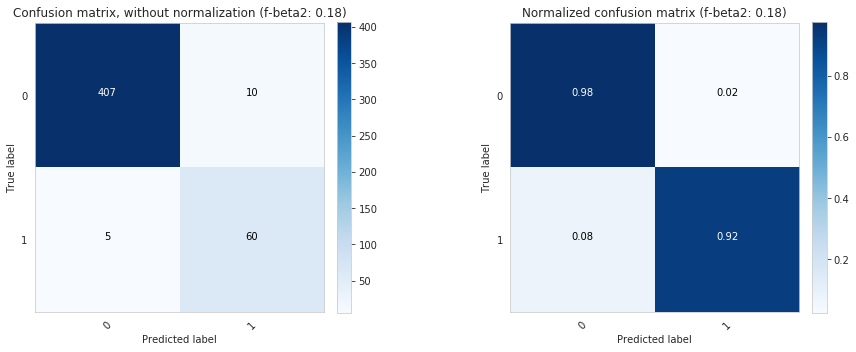



ROC Curve:


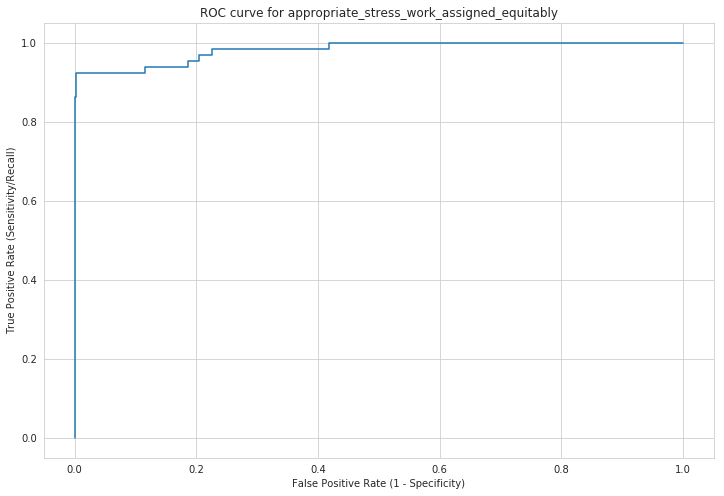

Predicted Probability Distribution:


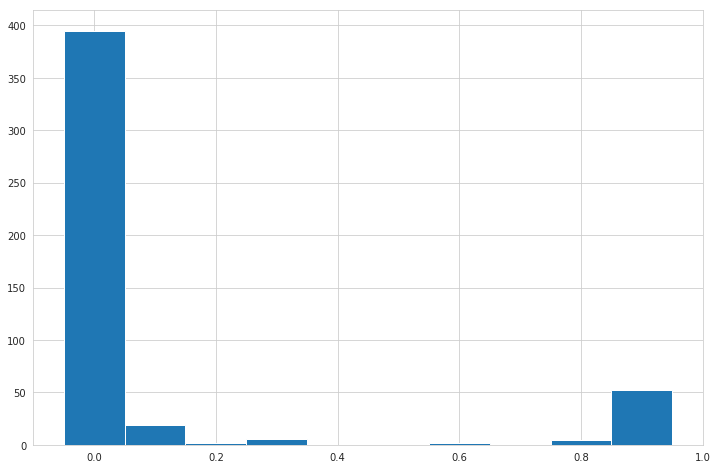



----------------------------------------------------------------------------------------------------


BENEFITS

Null Accuracy:	0.9730290456431535
AUC Score:	0.9786780383795309

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9937759336099585	0.9937759336099585	0.9896265560165975	
Cohen's Kappa:	0.885691699604743	0.885691699604743	0.8222975962247456	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9979              0.9957              0.9968              469                 
1                   0.8571              0.9231              0.8889              13                  
avg/total           0.9275              0.9594              0.9428              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9979              0.9957              0.9968              469   

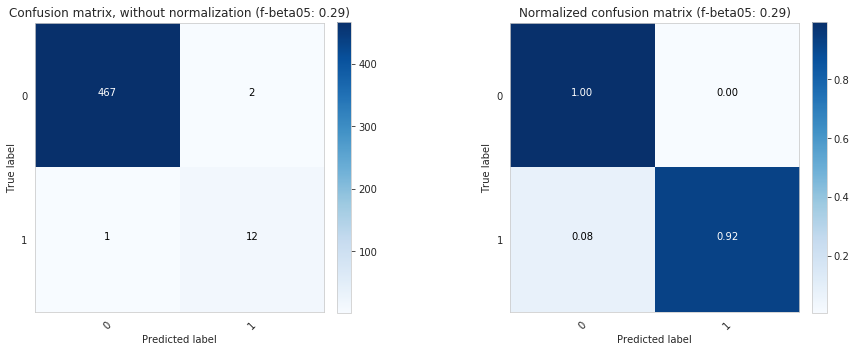

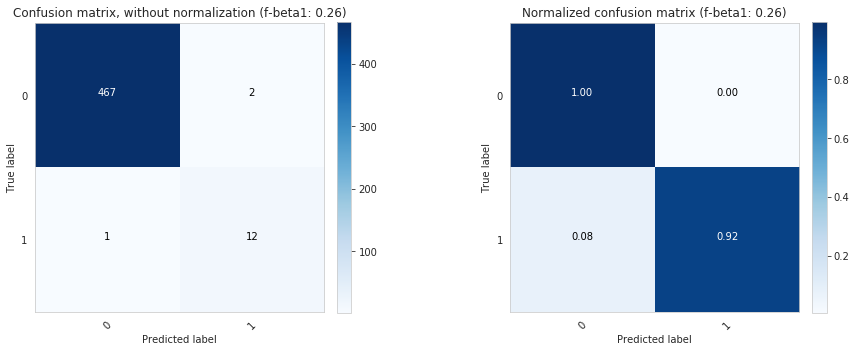

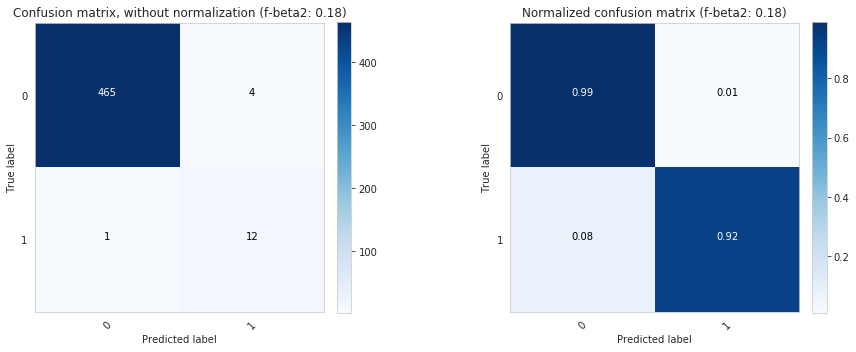



ROC Curve:


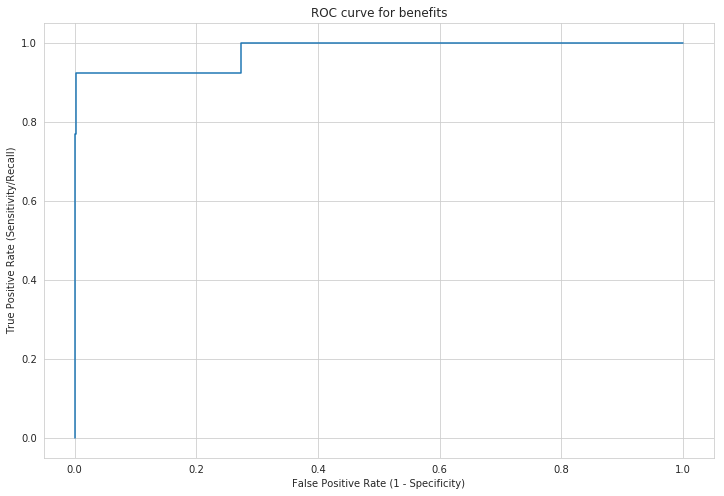

Predicted Probability Distribution:


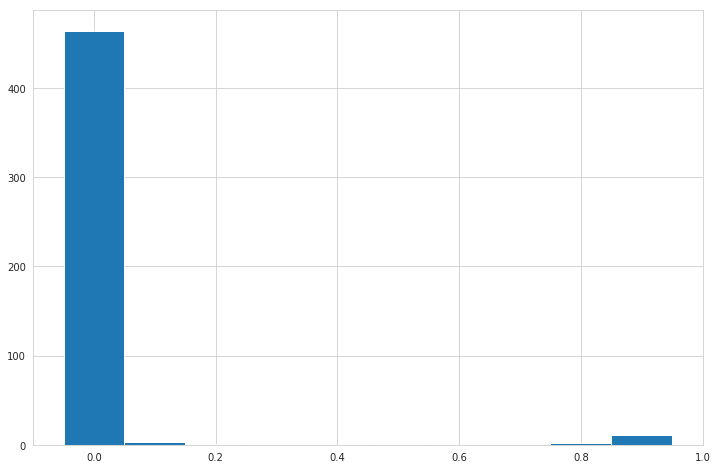



----------------------------------------------------------------------------------------------------


BETTER_WAYS_RECOGNIZED_PARTICIPATE_IN_DECISIONS

Null Accuracy:	0.9377593360995851
AUC Score:	0.9996312684365781

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.995850622406639	0.9937759336099585	0.9937759336099585	
Cohen's Kappa:	0.9644542772861356	0.9474983661317261	0.9474983661317261	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9978              0.9978              0.9978              452                 
1                   0.9667              0.9667              0.9667              30                  
avg/total           0.9822              0.9822              0.9822              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9978              0.9956

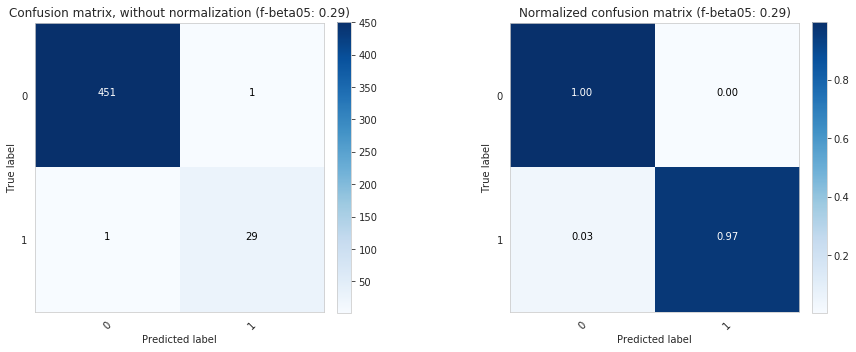

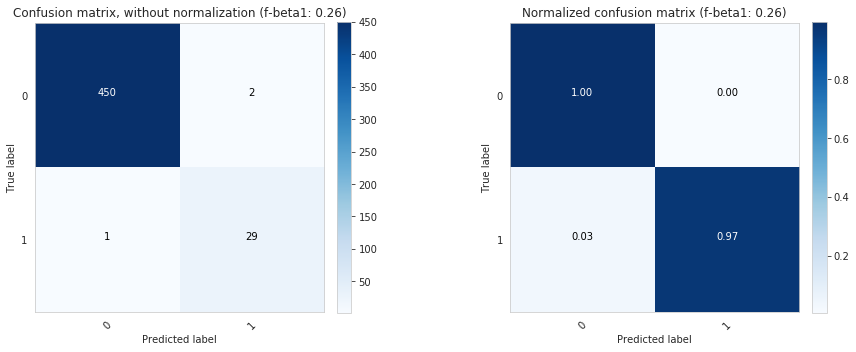

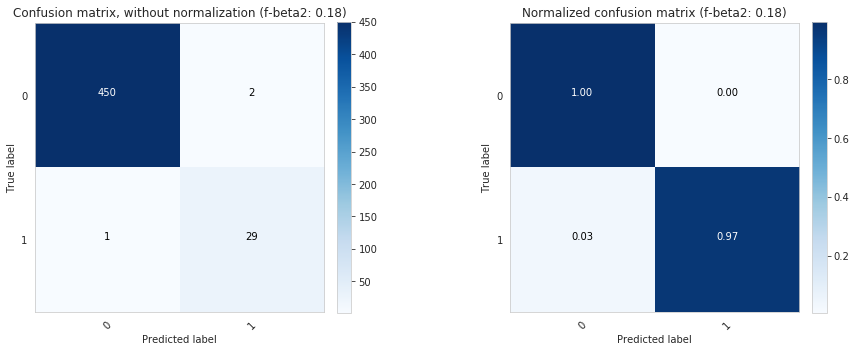



ROC Curve:


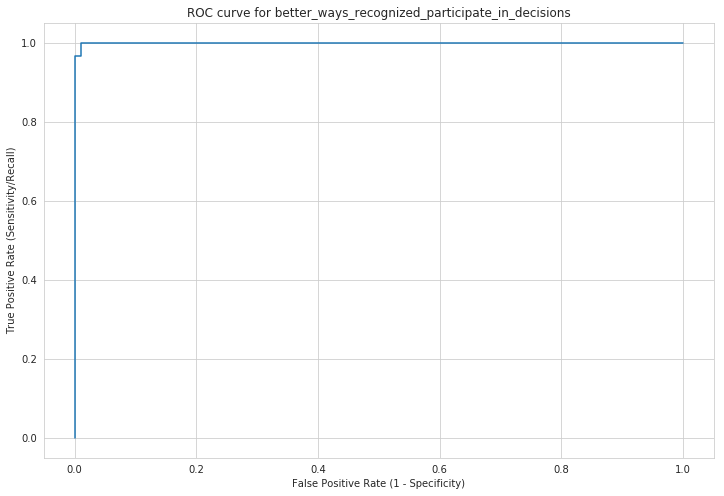

Predicted Probability Distribution:


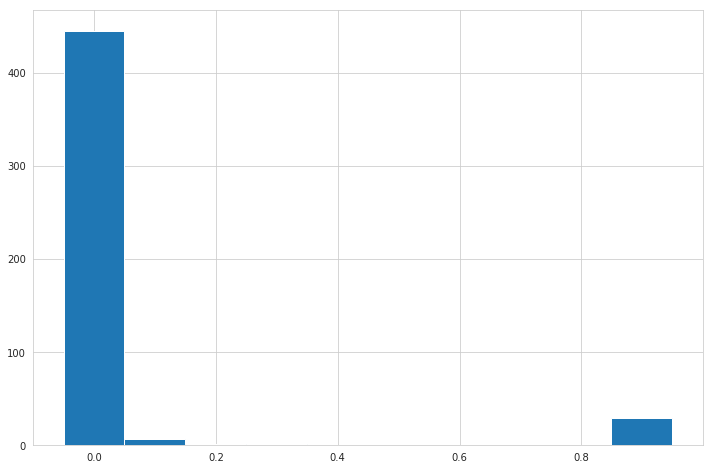



----------------------------------------------------------------------------------------------------


CAREER_ADVANCEMENT

Null Accuracy:	0.9087136929460581
AUC Score:	0.9609796596097966

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.975103734439834	0.975103734439834	0.970954356846473	
Cohen's Kappa:	0.8468058056997563	0.8468058056997563	0.8284348621987185	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9841              0.9886              0.9863              438                 
1                   0.881               0.8409              0.8605              44                  
avg/total           0.9325              0.9147              0.9234              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9841              0.9886              0.9863           

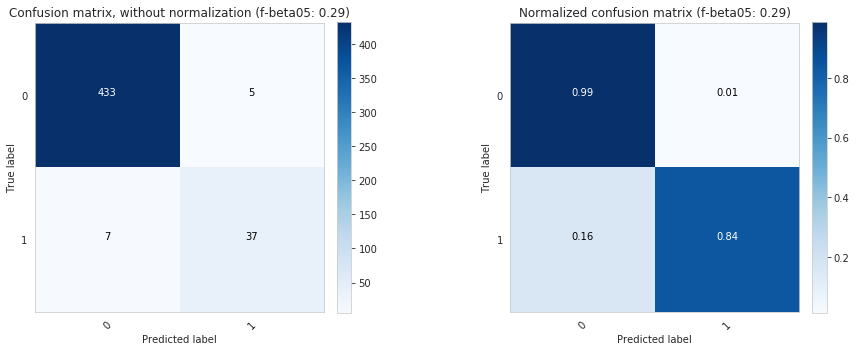

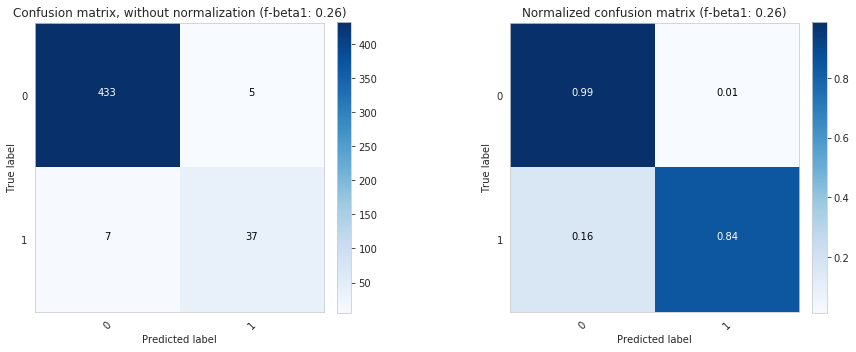

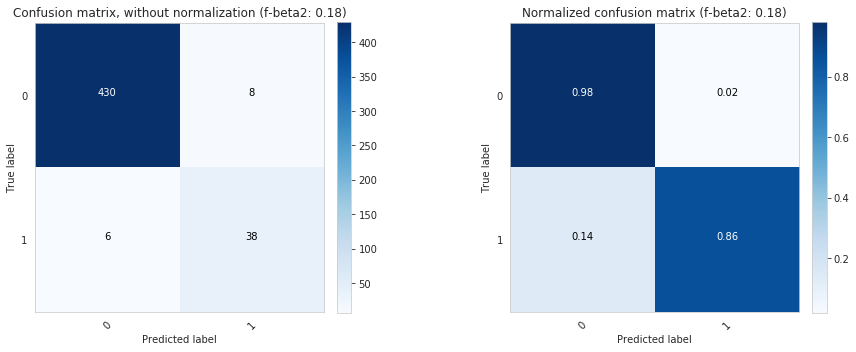



ROC Curve:


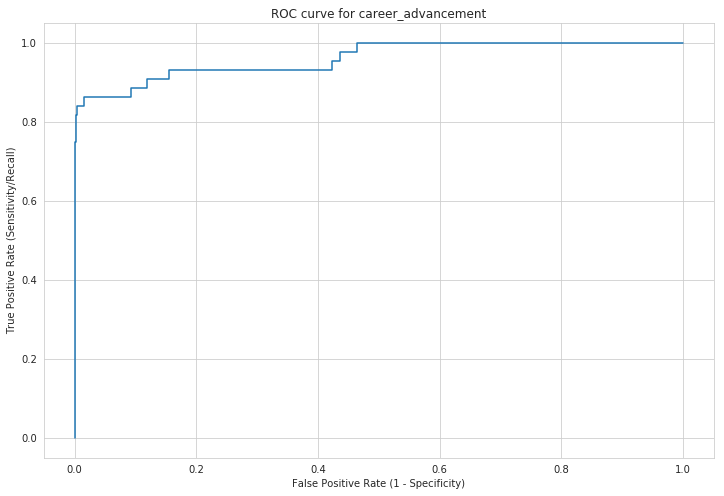

Predicted Probability Distribution:


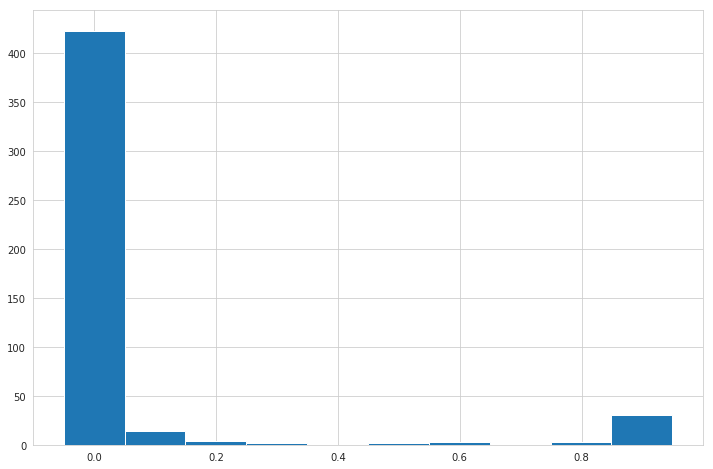



----------------------------------------------------------------------------------------------------


COMMITTED_TO_DIVERSITY

Null Accuracy:	0.9149377593360996
AUC Score:	0.9522150323544052

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9522821576763485	0.9522821576763485	0.9522821576763485	
Cohen's Kappa:	0.703281408918152	0.703281408918152	0.703281408918152	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9772              0.9705              0.9738              441                 
1                   0.7045              0.7561              0.7294              41                  
avg/total           0.8409              0.8633              0.8516              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9772              0.9705              0.9738       

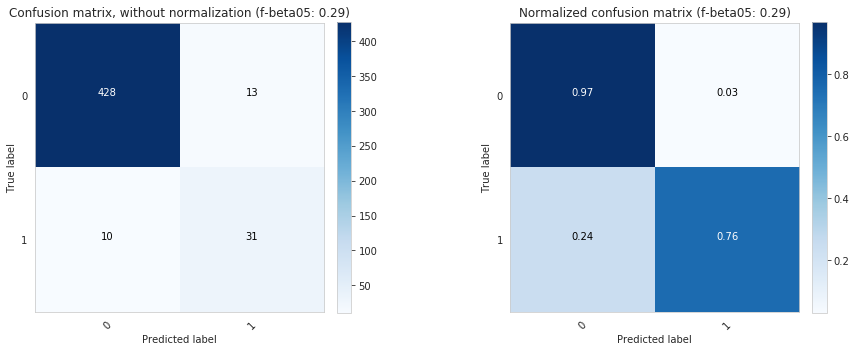

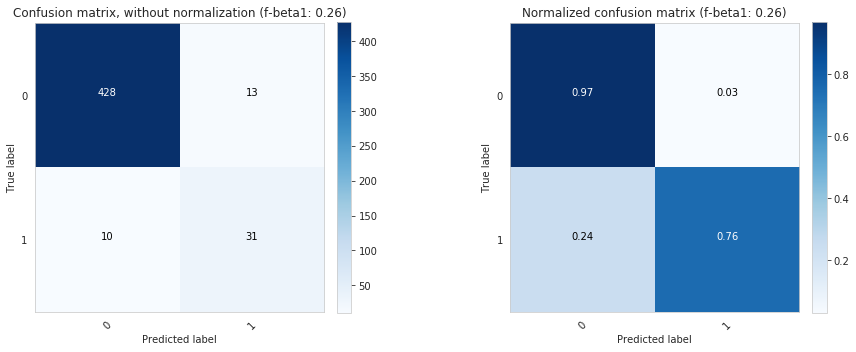

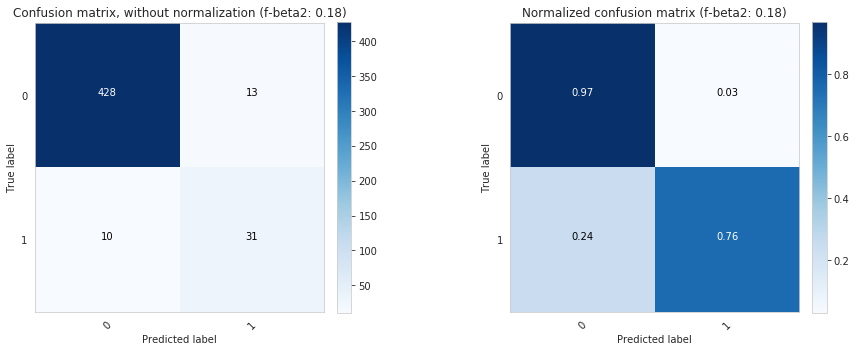



ROC Curve:


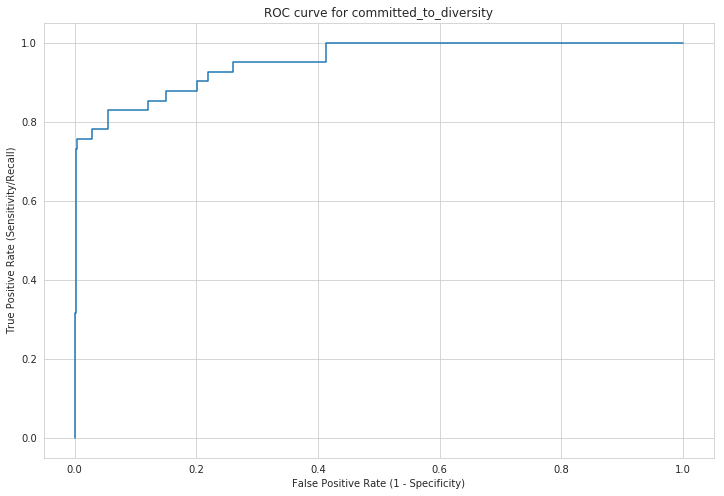

Predicted Probability Distribution:


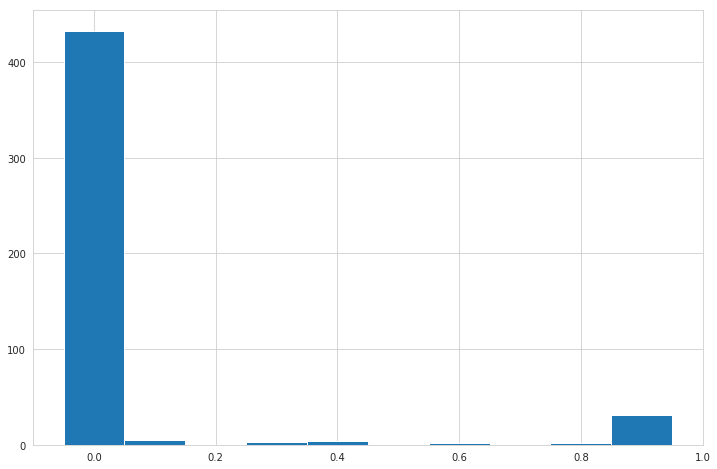



----------------------------------------------------------------------------------------------------


COMMUNICATES_ESSENTIAL_INFORMATION

Null Accuracy:	0.9439834024896265
AUC Score:	0.9995115995115994

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9979253112033195	0.9979253112033195	0.9979253112033195	
Cohen's Kappa:	0.980034794134703	0.980034794134703	0.980034794134703	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9978              1.0                 0.9989              455                 
1                   1.0                 0.963               0.9811              27                  
avg/total           0.9989              0.9815              0.99                482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9978              1.0                 0

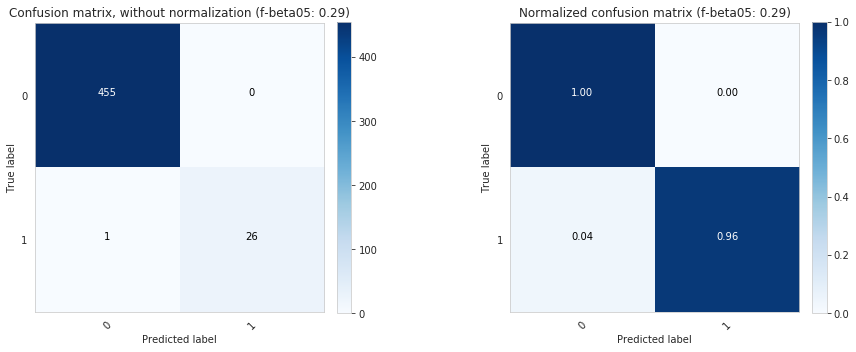

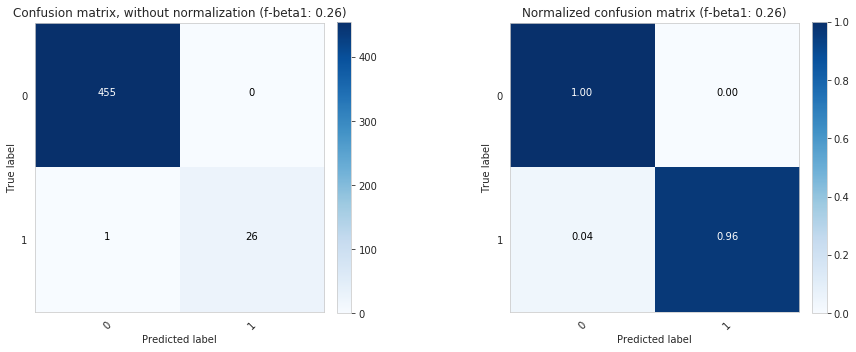

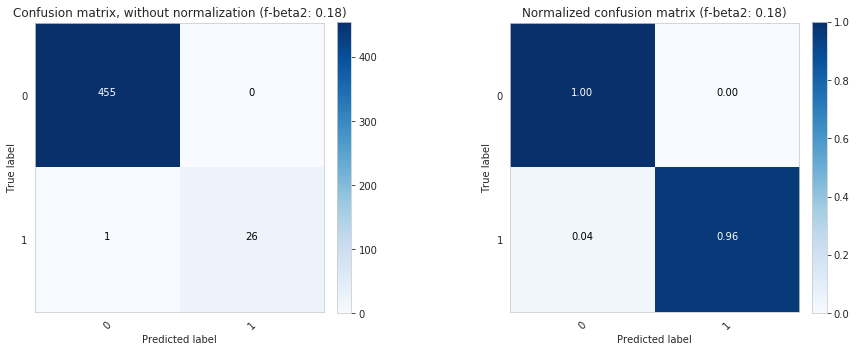



ROC Curve:


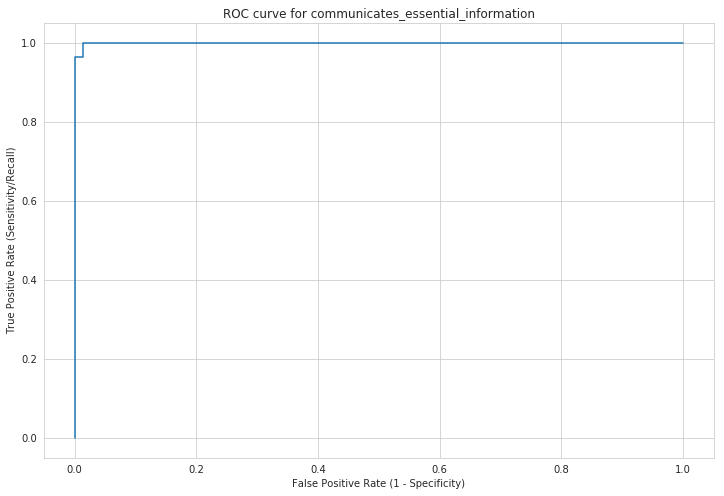

Predicted Probability Distribution:


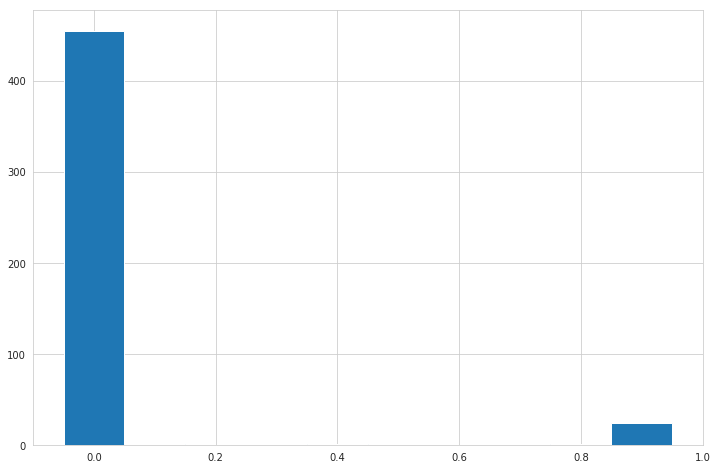



----------------------------------------------------------------------------------------------------


ETHICAL_CONDUCT_PERFORM_RESPONSIBILITIES_SPIRIT_OF_COOPERATION

Null Accuracy:	0.7946058091286307
AUC Score:	0.9733892449297149

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9585062240663901	0.9522821576763485	0.9253112033195021	
Cohen's Kappa:	0.8756738631380743	0.85959624103954	0.7914874185873249	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9814              0.9661              0.9737              383                 
1                   0.8762              0.9293              0.902               99                  
avg/total           0.9288              0.9477              0.9378              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9839      

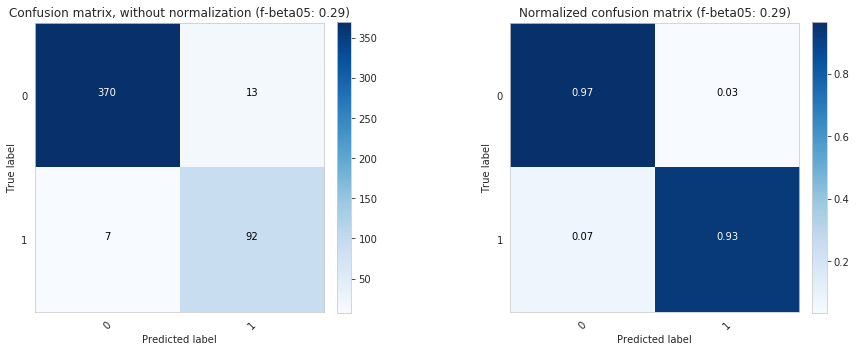

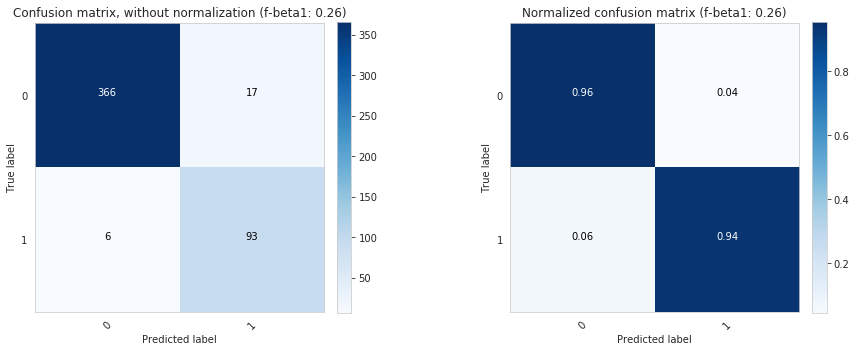

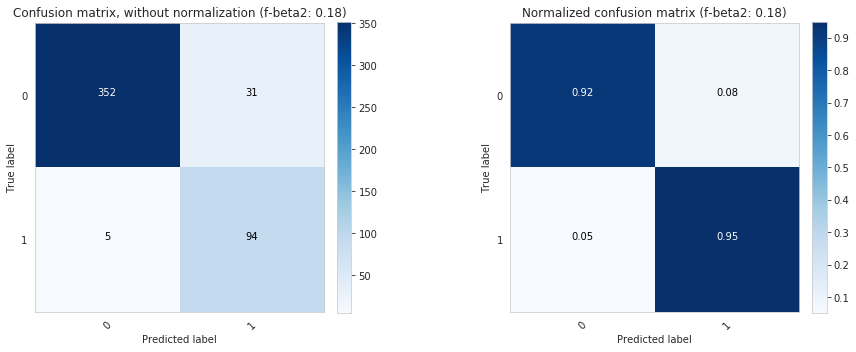



ROC Curve:


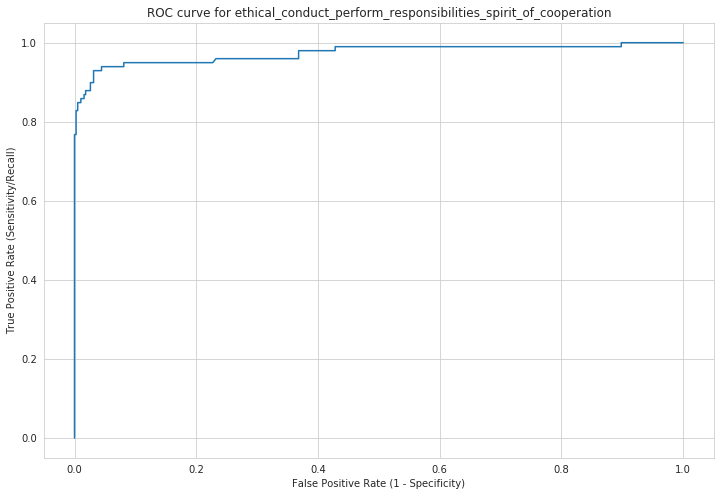

Predicted Probability Distribution:


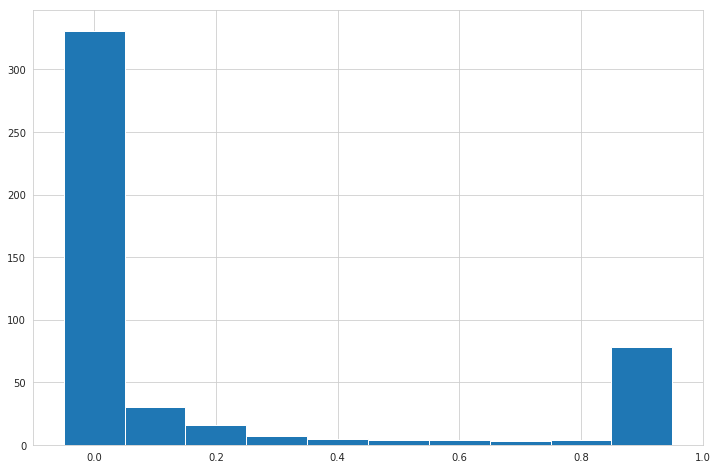



----------------------------------------------------------------------------------------------------


EVALUATED_FAIRLY

Null Accuracy:	0.9605809128630706
AUC Score:	0.9922700920768444

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9937759336099585	0.991701244813278	0.991701244813278	
Cohen's Kappa:	0.9156851311953352	0.8904171876776173	0.8904171876776173	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9957              0.9978              0.9968              463                 
1                   0.9444              0.8947              0.9189              19                  
avg/total           0.9701              0.9463              0.9578              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9957              0.9957              0.9957            

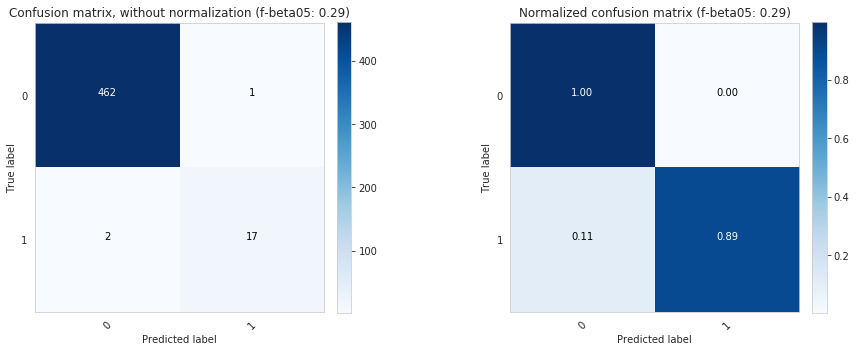

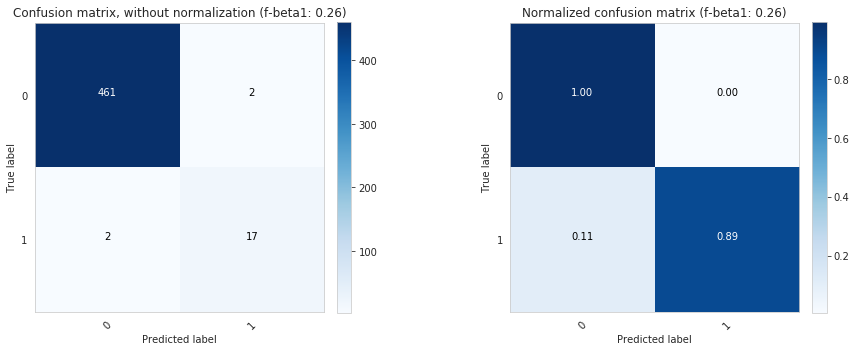

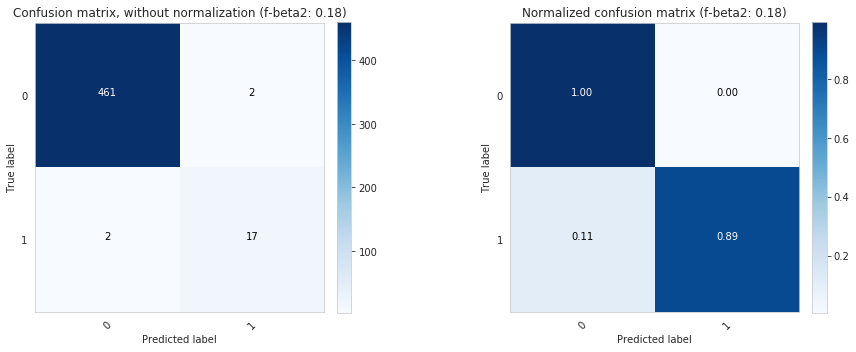



ROC Curve:


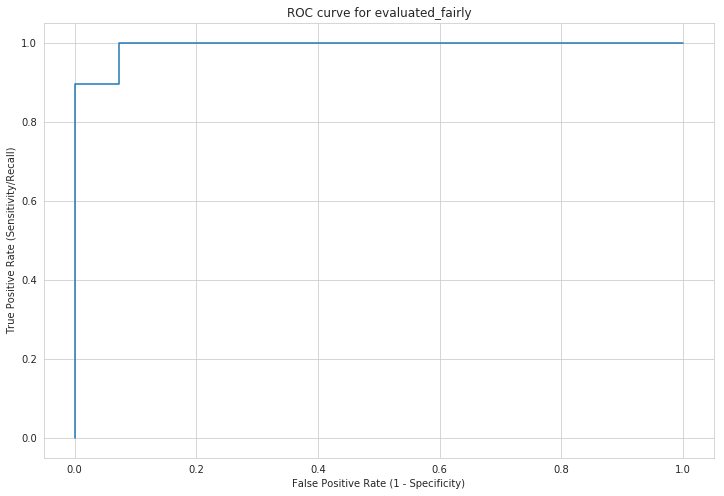

Predicted Probability Distribution:


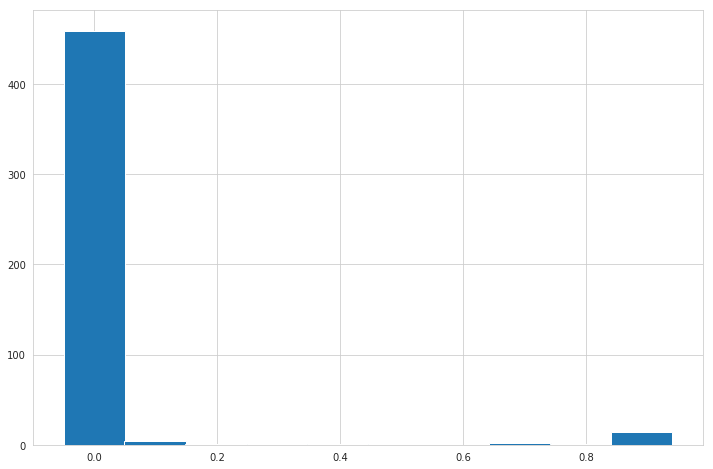



----------------------------------------------------------------------------------------------------


EXPERIENCED_DISCRIMINATION

Null Accuracy:	0.8692946058091287
AUC Score:	0.982535894230405

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.991701244813278	0.9854771784232366	0.9813278008298755	
Cohen's Kappa:	0.9634806985642308	0.9373584345178418	0.9205115989298933	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9952              0.9952              0.9952              419                 
1                   0.9683              0.9683              0.9683              63                  
avg/total           0.9817              0.9817              0.9817              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9952              0.9881              0.9916  

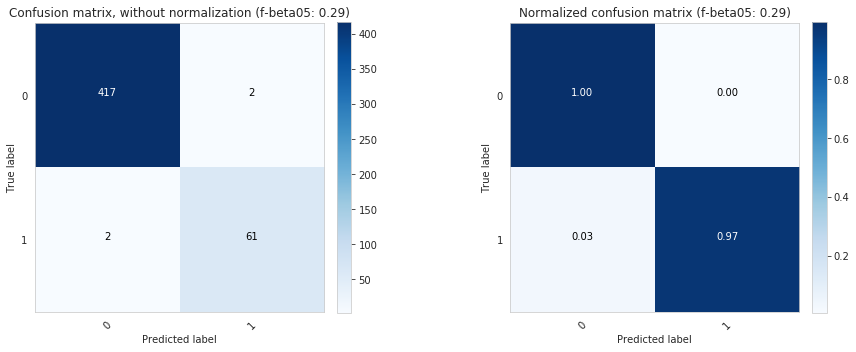

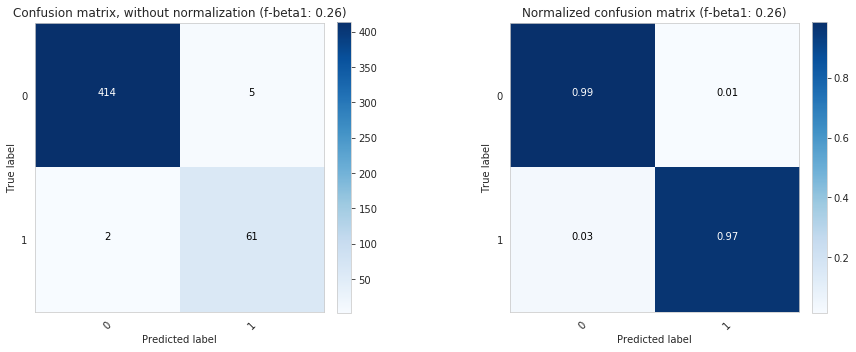

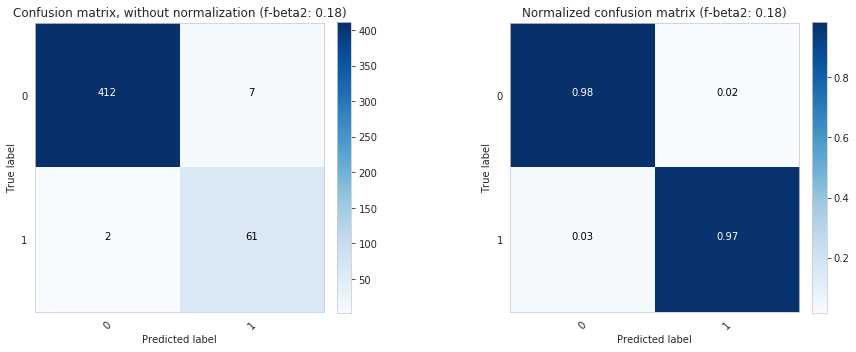



ROC Curve:


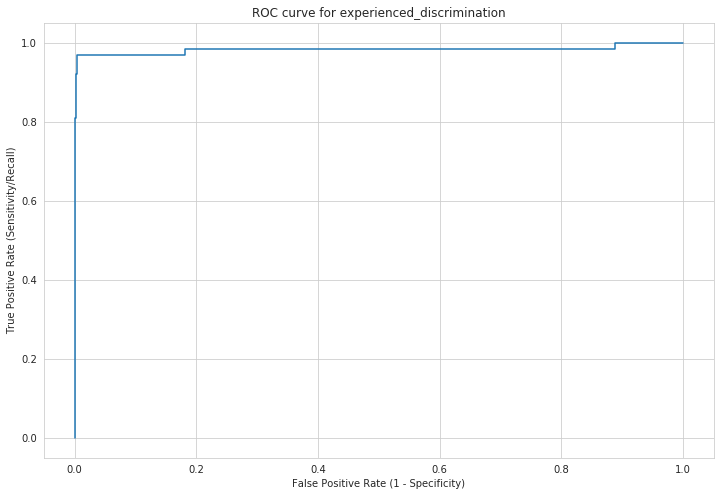

Predicted Probability Distribution:


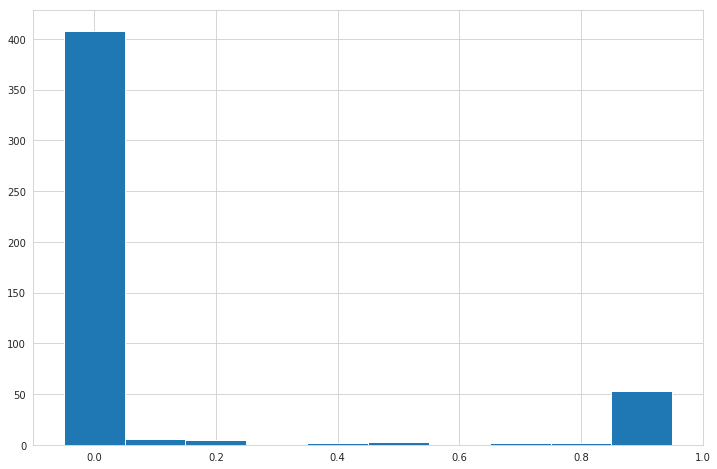



----------------------------------------------------------------------------------------------------


FACILITIES_WORKSPACE_SAFETY

Null Accuracy:	0.9356846473029046
AUC Score:	0.9794721407624634

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9937759336099585	0.9937759336099585	0.9937759336099585	
Cohen's Kappa:	0.9474983661317261	0.9474983661317261	0.9474983661317261	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9956              0.9978              0.9967              451                 
1                   0.9667              0.9355              0.9508              31                  
avg/total           0.9811              0.9666              0.9737              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9956              0.9978              0.996

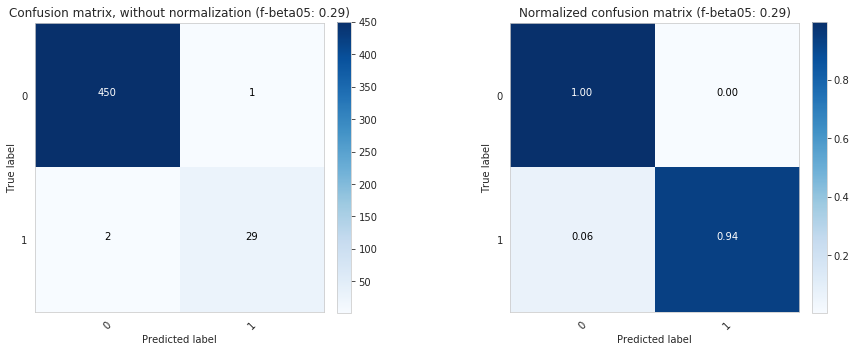

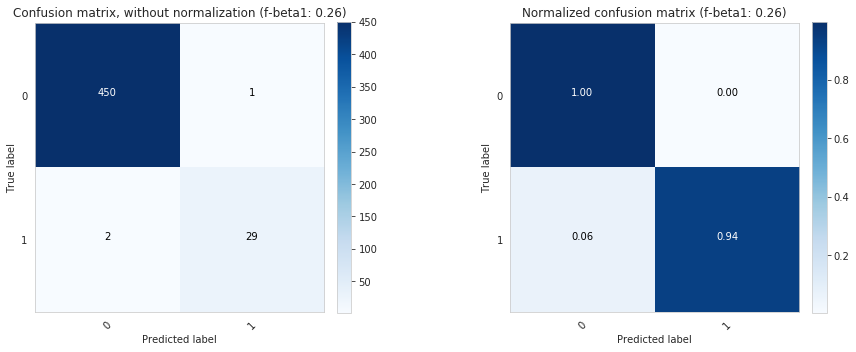

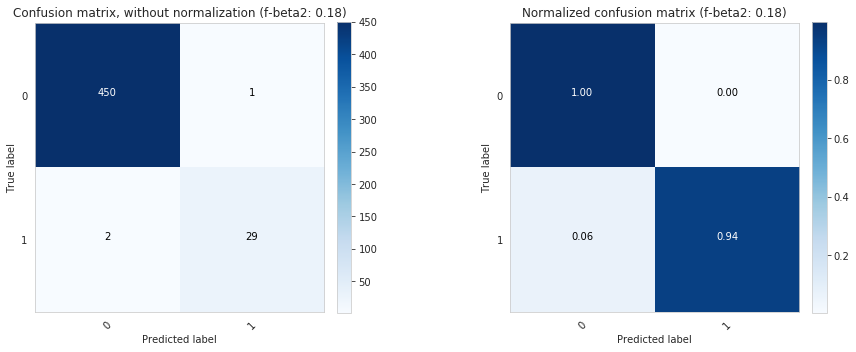



ROC Curve:


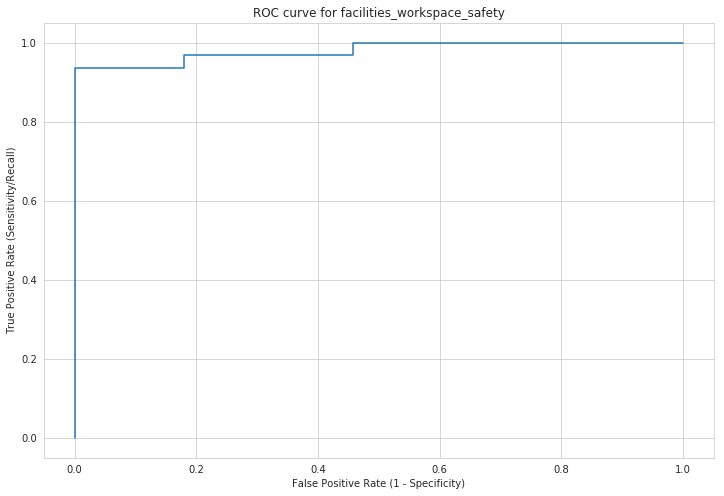

Predicted Probability Distribution:


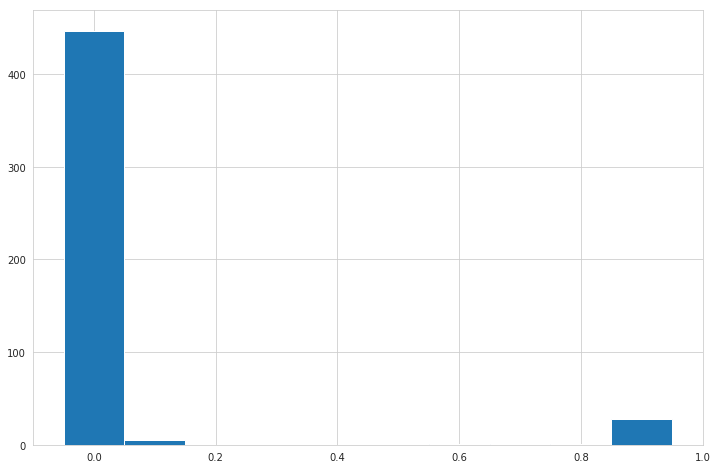



----------------------------------------------------------------------------------------------------


FACULTY_VALUE_CONTRIBUTIONS

Null Accuracy:	0.8464730290456431
AUC Score:	0.967541070482247

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9730290456431535	0.970954356846473	0.966804979253112	
Cohen's Kappa:	0.895653621981682	0.8882485426603074	0.8736814518770883	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9829              0.9853              0.9841              408                 
1                   0.9178              0.9054              0.9116              74                  
avg/total           0.9503              0.9453              0.9478              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9828              0.9828              0.9828   

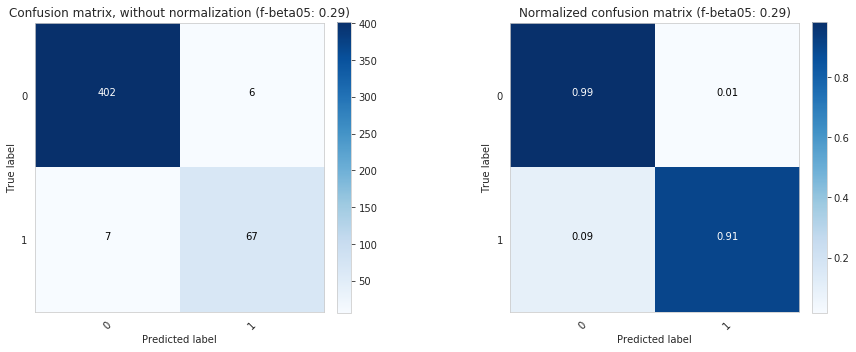

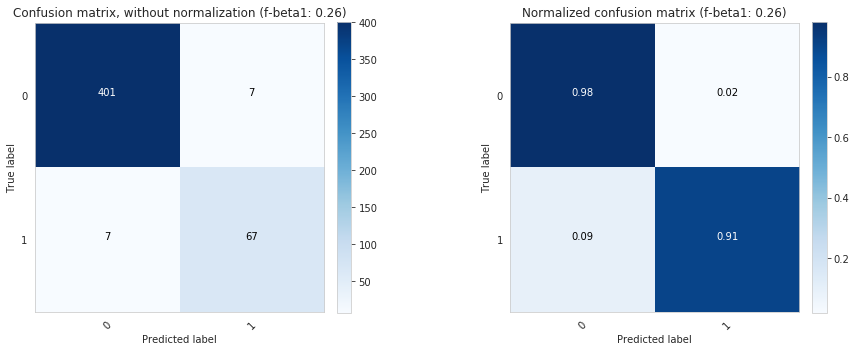

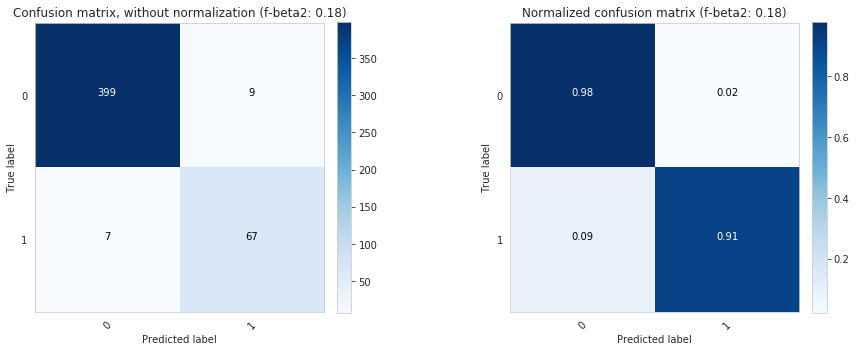



ROC Curve:


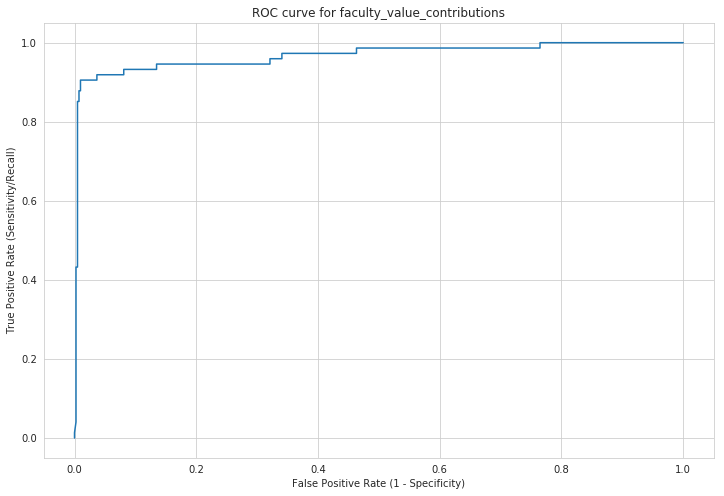

Predicted Probability Distribution:


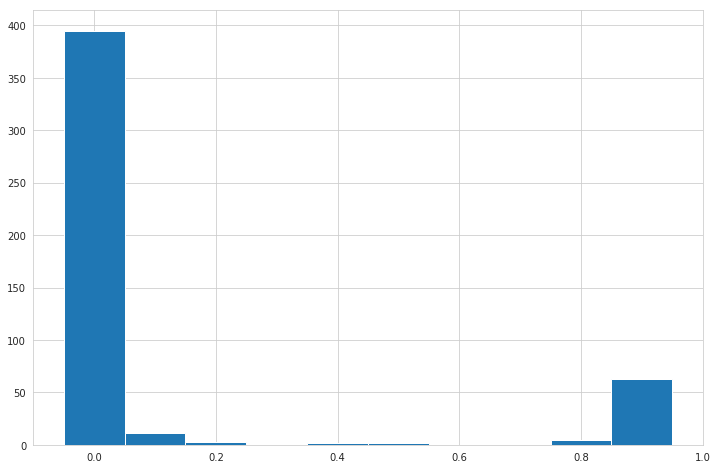



----------------------------------------------------------------------------------------------------


FAVORITISM_CLIQUES

Null Accuracy:	0.9605809128630706
AUC Score:	0.9999999999999999

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9979253112033195	0.9979253112033195	0.9979253112033195	
Cohen's Kappa:	0.9732786339948997	0.9732786339948997	0.9732786339948997	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   1.0                 0.9978              0.9989              463                 
1                   0.95                1.0                 0.9744              19                  
avg/total           0.975               0.9989              0.9866              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   1.0                 0.9978              0.9989        

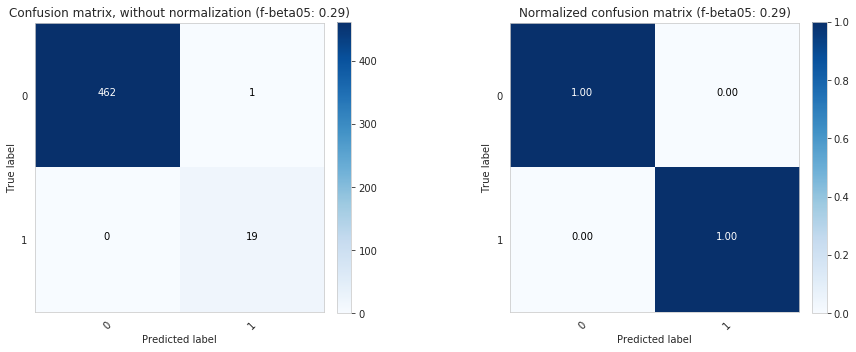

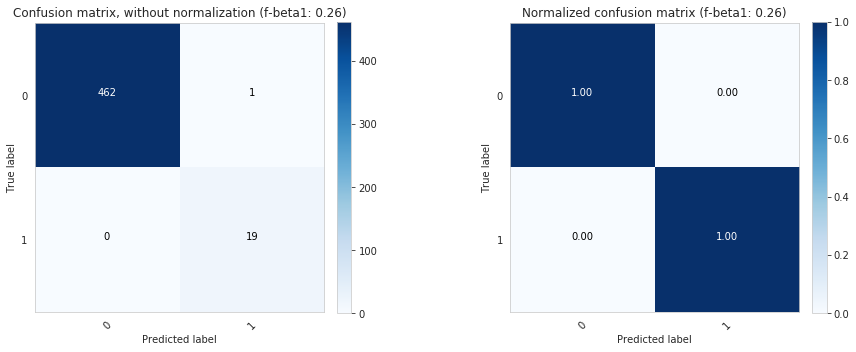

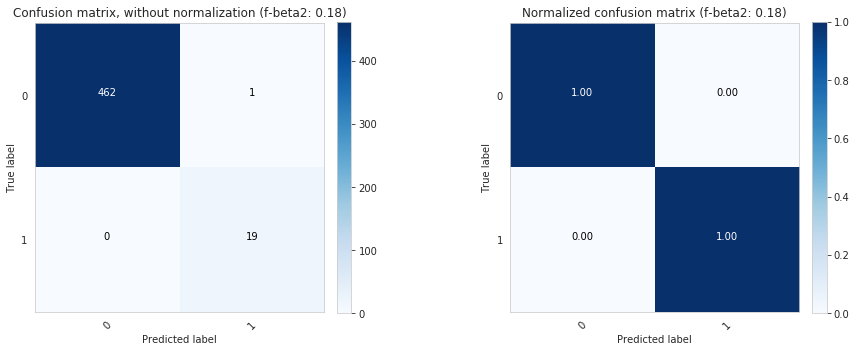



ROC Curve:


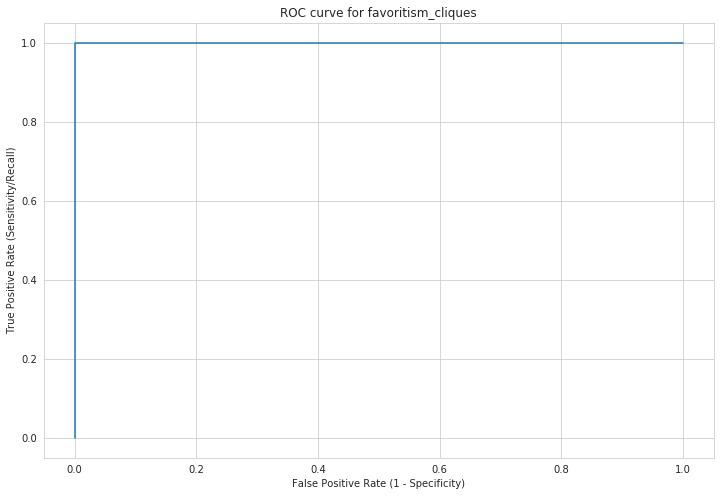

Predicted Probability Distribution:


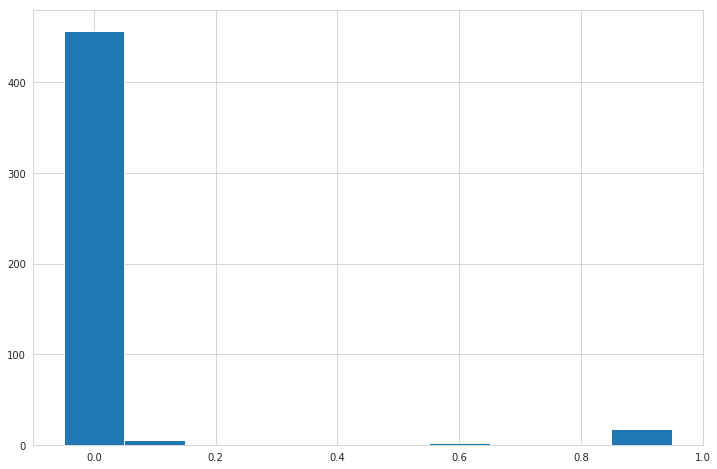



----------------------------------------------------------------------------------------------------


FEAR_OF_RETALIATION_NEGATIVE_CONSEQUENCES

Null Accuracy:	0.7904564315352697
AUC Score:	0.979782230191523

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.941908713692946	0.946058091286307	0.950207468879668	
Cohen's Kappa:	0.8233554095442528	0.8371663938047348	0.8507778437088827	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9608              0.9659              0.9634              381                 
1                   0.8687              0.8515              0.86                101                 
avg/total           0.9148              0.9087              0.9117              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9659              0.9659         

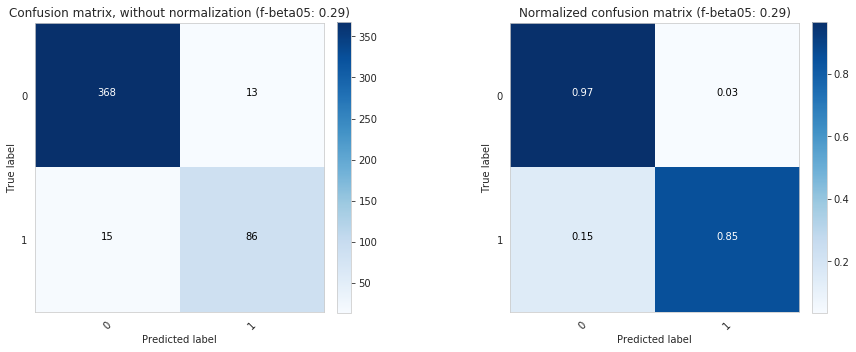

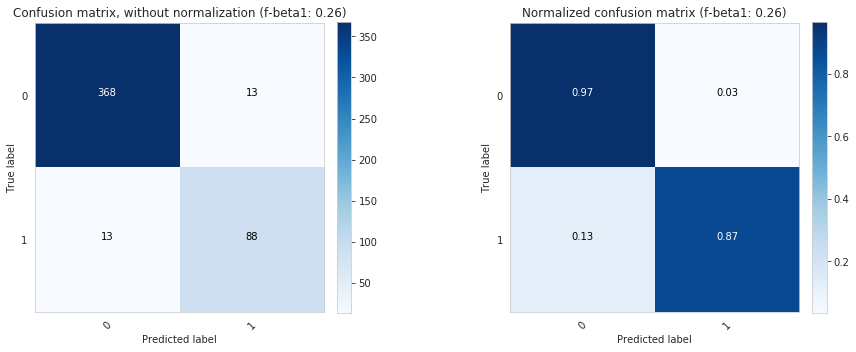

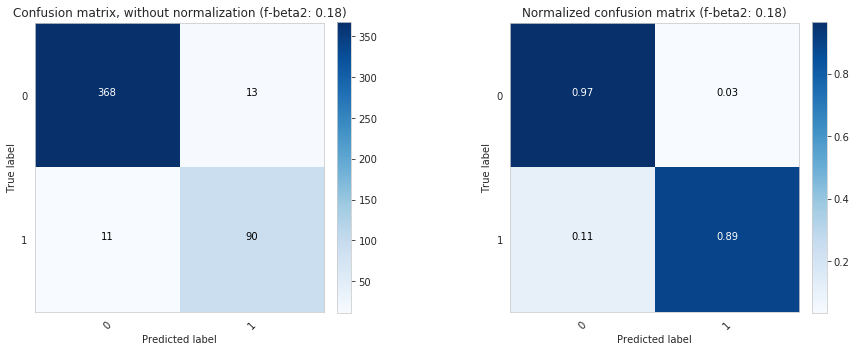



ROC Curve:


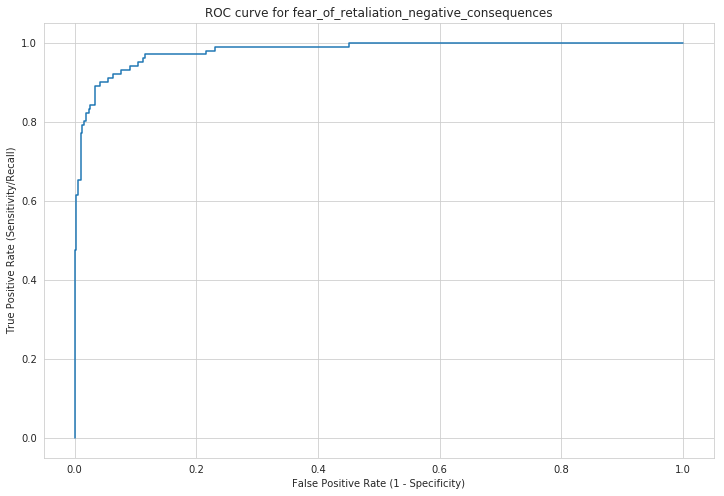

Predicted Probability Distribution:


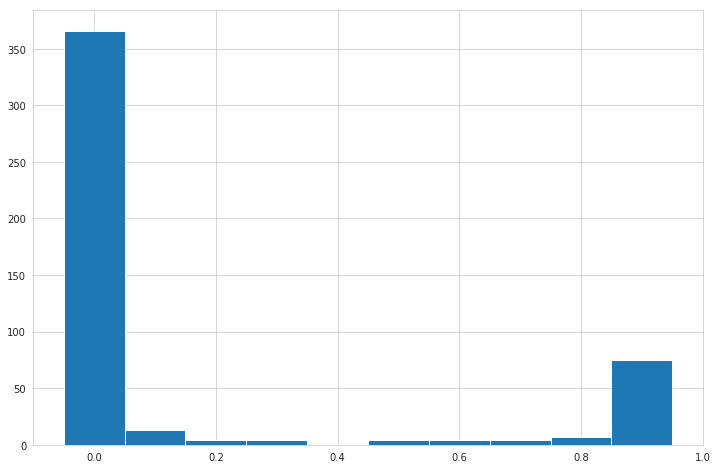



----------------------------------------------------------------------------------------------------


FEEL_VALUED_BY_DEPARTMENT

Null Accuracy:	0.8526970954356846
AUC Score:	0.9861553750728212

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9730290456431535	0.9730290456431535	0.9605809128630706	
Cohen's Kappa:	0.8932574699328814	0.8932574699328814	0.8492311744756511	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9854              0.983               0.9842              411                 
1                   0.9028              0.9155              0.9091              71                  
avg/total           0.9441              0.9492              0.9466              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9854              0.983               0.9842 

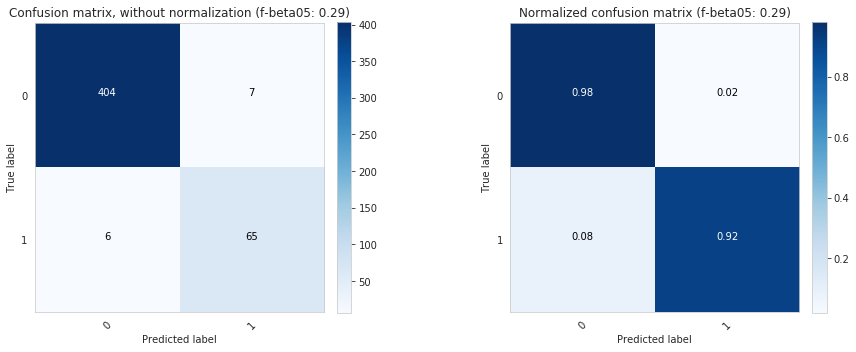

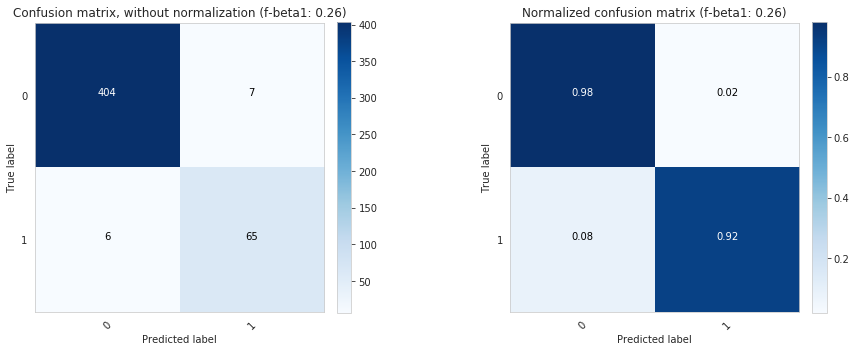

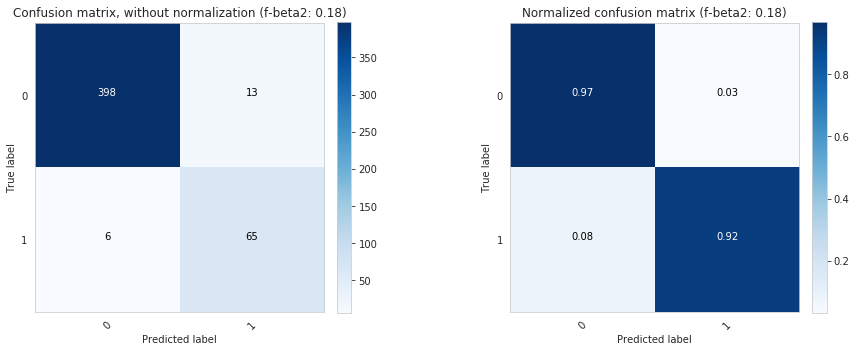



ROC Curve:


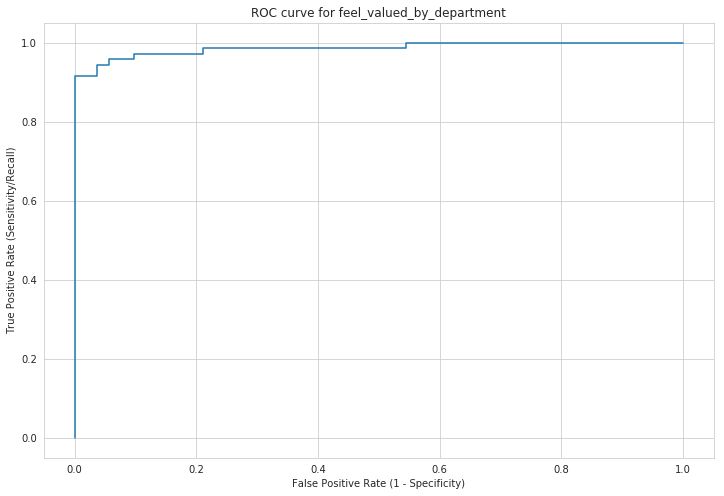

Predicted Probability Distribution:


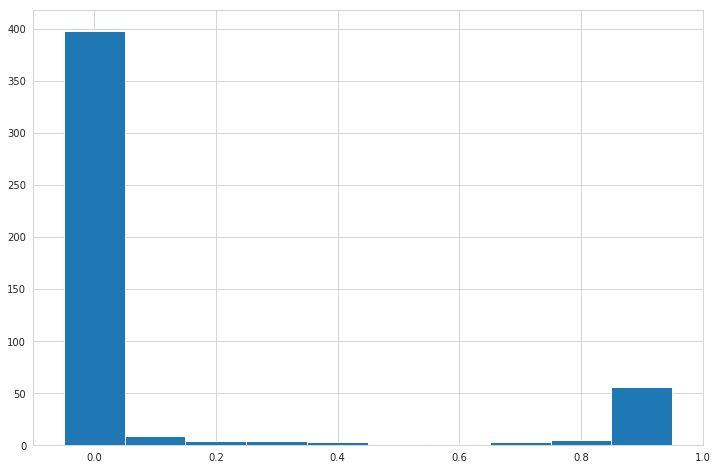



----------------------------------------------------------------------------------------------------


FLEXIBILITY_WORK_LIFE_BALANCE

Null Accuracy:	0.9439834024896265
AUC Score:	0.997883597883598

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9937759336099585	0.9937759336099585	0.9937759336099585	
Cohen's Kappa:	0.9440705500116036	0.9440705500116036	0.9440705500116036	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   1.0                 0.9934              0.9967              455                 
1                   0.9                 1.0                 0.9474              27                  
avg/total           0.95                0.9967              0.972               482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   1.0                 0.9934              0.99

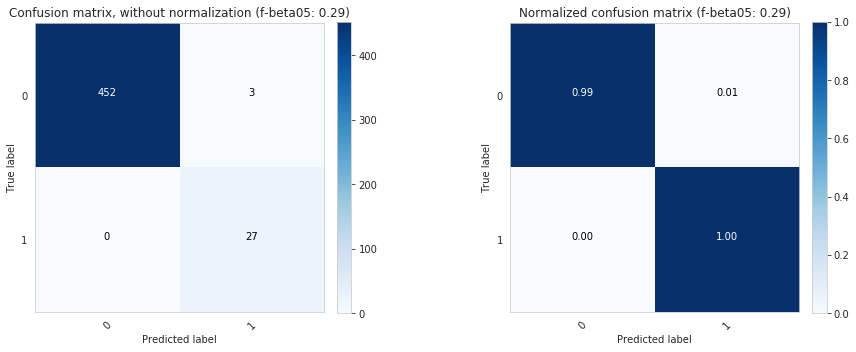

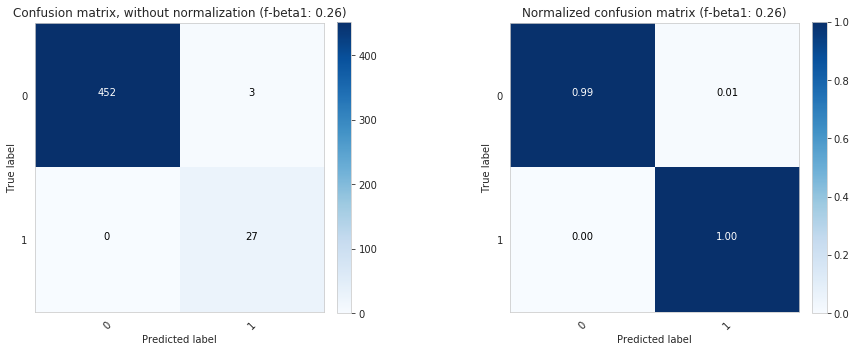

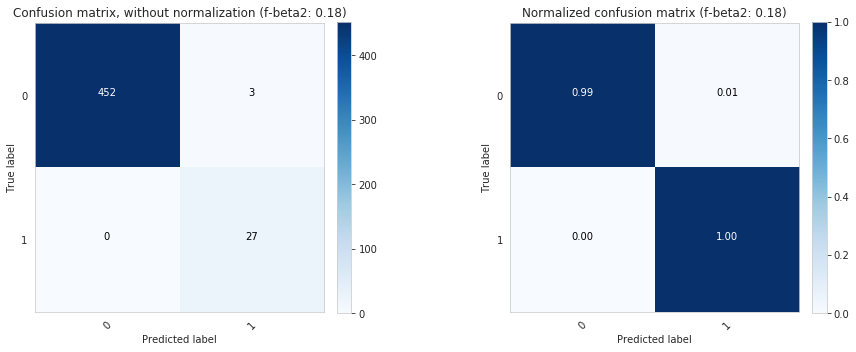



ROC Curve:


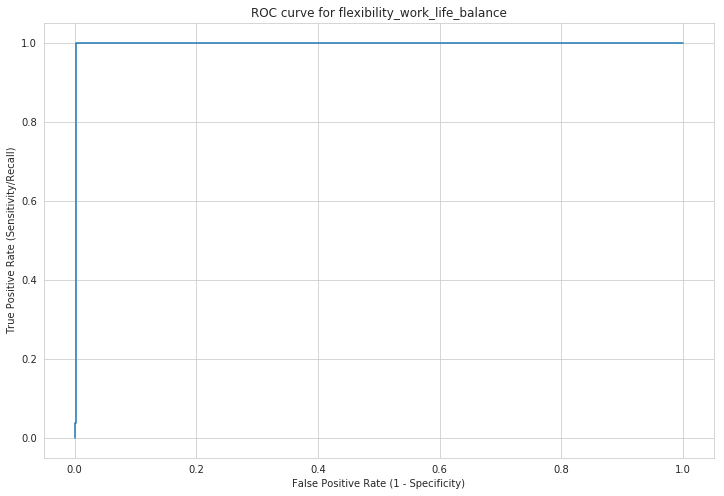

Predicted Probability Distribution:


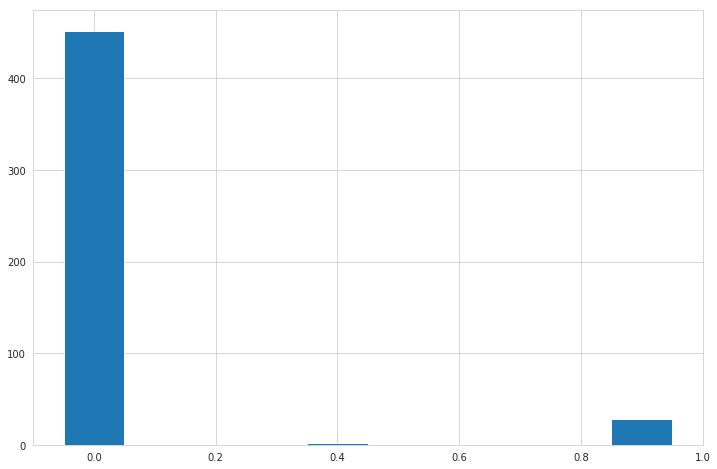



----------------------------------------------------------------------------------------------------


GOOD_USE_OF_SKILLS

Null Accuracy:	0.979253112033195
AUC Score:	0.9999999999999999

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	1.0	1.0	0.995850622406639	
Cohen's Kappa:	1.0	1.0	0.9069857197993053	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   1.0                 1.0                 1.0                 472                 
1                   1.0                 1.0                 1.0                 10                  
avg/total           1.0                 1.0                 1.0                 482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   1.0                 1.0                 1.0                 472                 
1                   1.0            

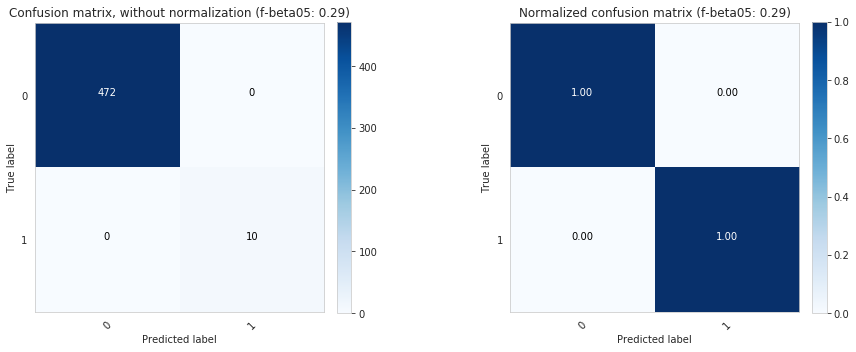

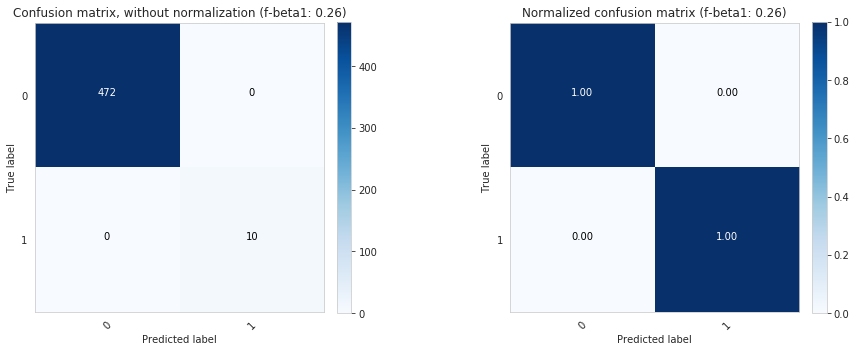

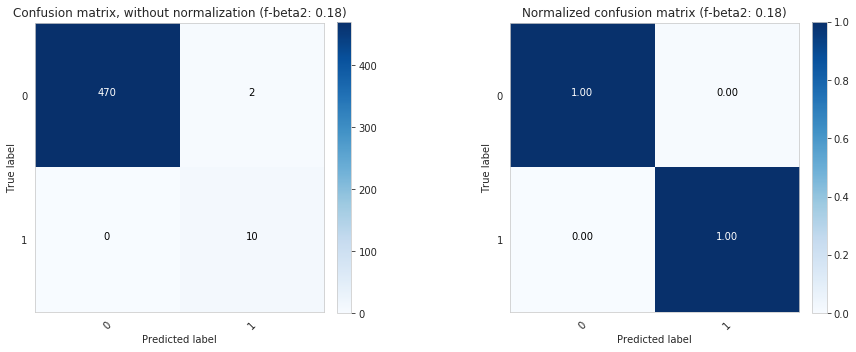



ROC Curve:


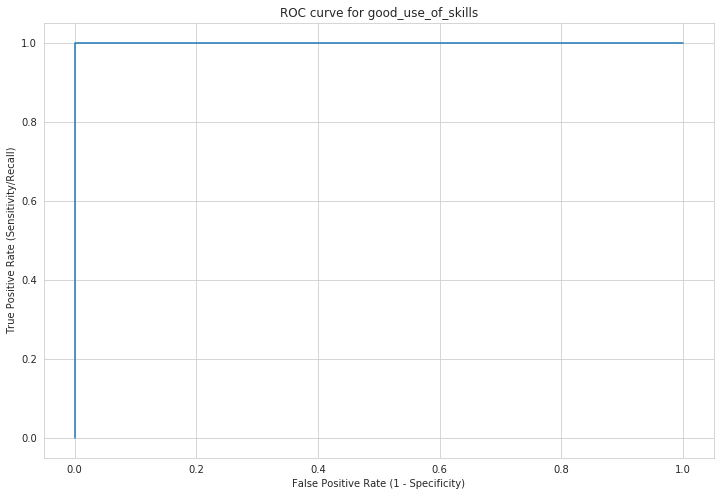

Predicted Probability Distribution:


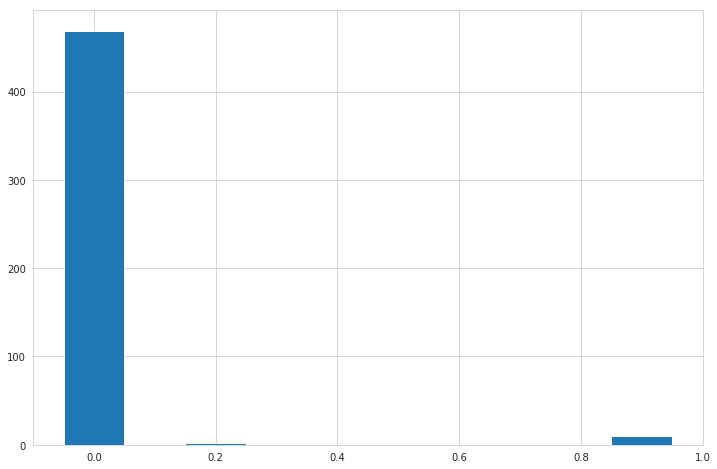



----------------------------------------------------------------------------------------------------


HAVE_NECESSARY_TOOLS

Null Accuracy:	0.983402489626556
AUC Score:	0.9899789029535865

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9937759336099585	0.9937759336099585	0.991701244813278	
Cohen's Kappa:	0.7968530486091598	0.7968530486091598	0.7457805907172996	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9958              0.9979              0.9968              474                 
1                   0.8571              0.75                0.8                 8                   
avg/total           0.9265              0.8739              0.8984              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9958              0.9979              0.9968        

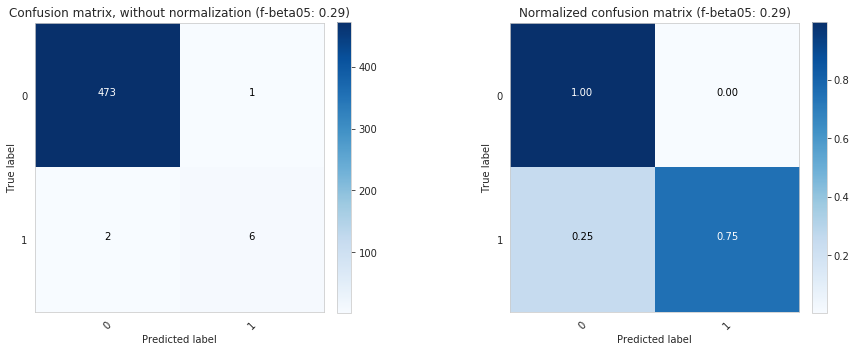

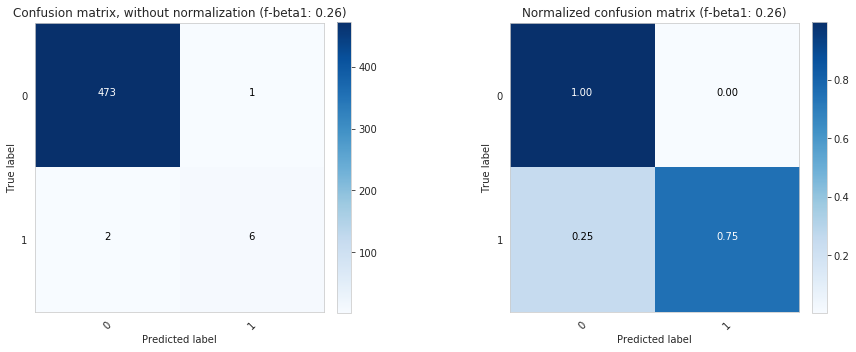

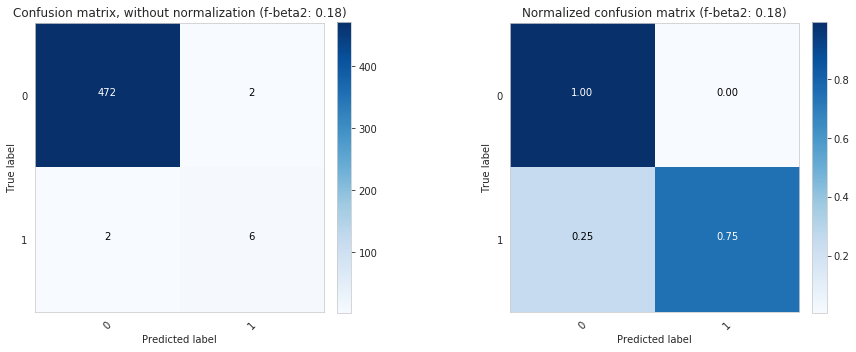



ROC Curve:


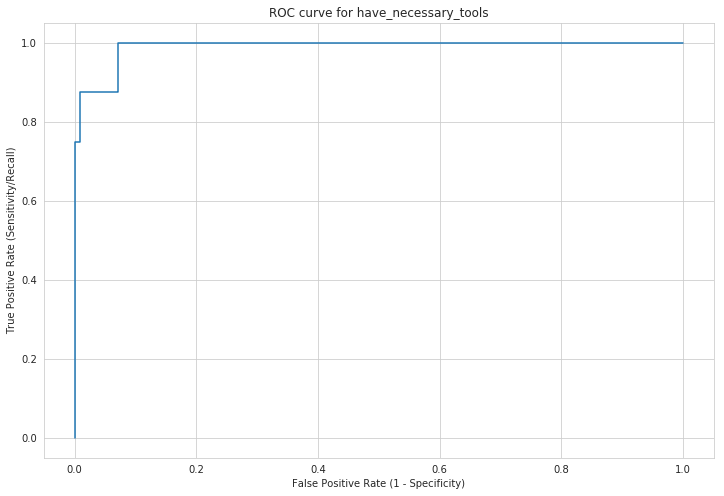

Predicted Probability Distribution:


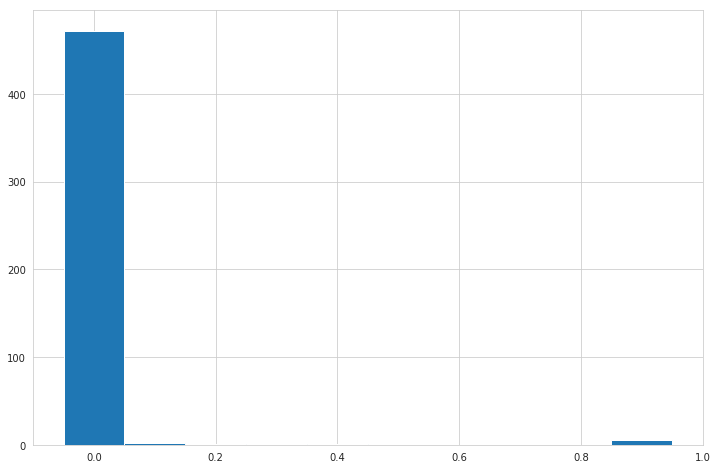



----------------------------------------------------------------------------------------------------


HAVE_VOICE_ON_CAMPUS_VALUED_MEMBER_OF_UCSD

Null Accuracy:	0.9232365145228216
AUC Score:	0.9778317643486184

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9875518672199171	0.9875518672199171	0.9771784232365145	
Cohen's Kappa:	0.9163242867889589	0.9163242867889589	0.8551445276214414	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9977              0.9888              0.9932              445                 
1                   0.878               0.973               0.9231              37                  
avg/total           0.9379              0.9809              0.9582              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9977              0.9888    

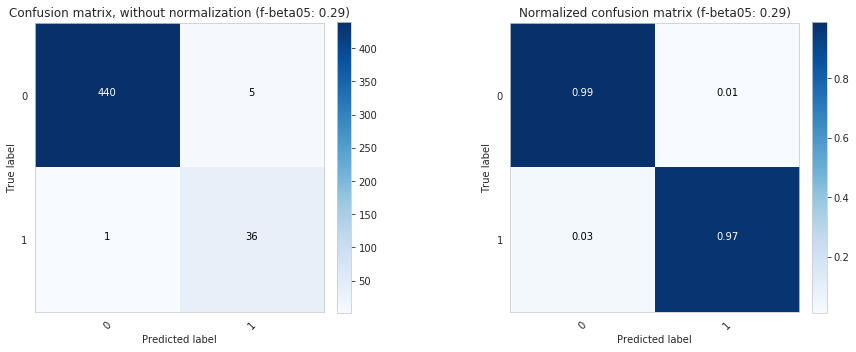

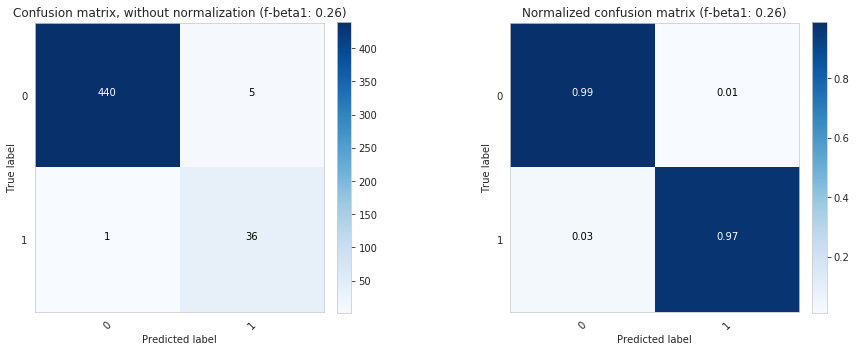

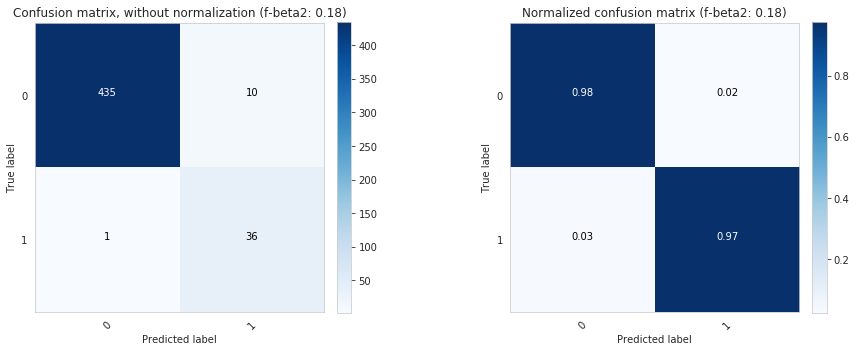



ROC Curve:


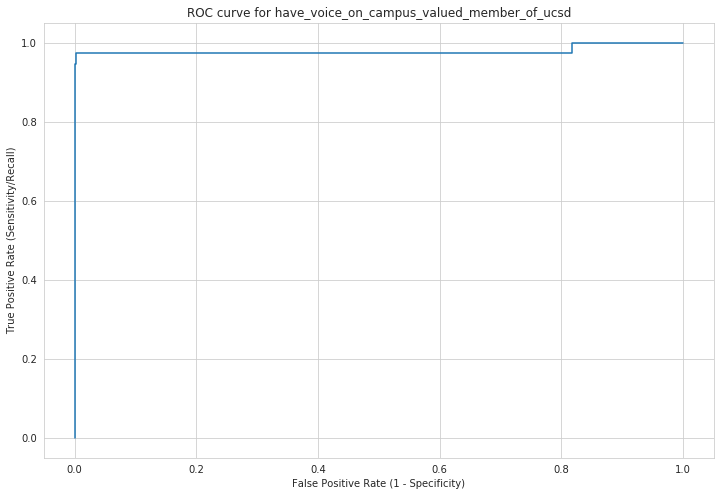

Predicted Probability Distribution:


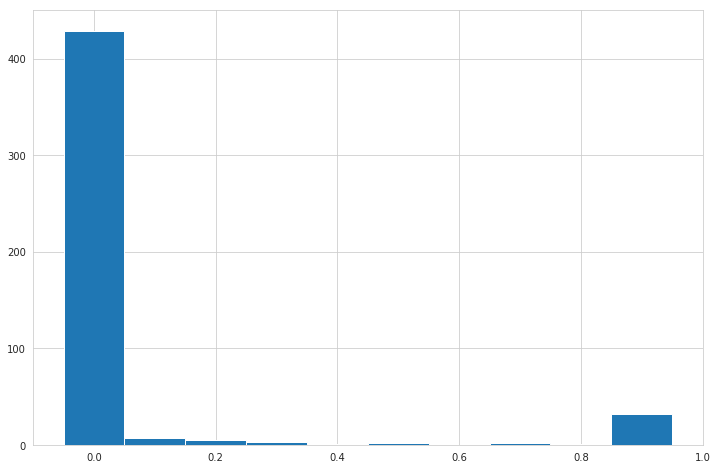



----------------------------------------------------------------------------------------------------


INTERNAL_PROCESSES_EFFECTIVE

Null Accuracy:	0.9315352697095436
AUC Score:	0.9841398393736924

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9875518672199171	0.9875518672199171	0.9854771784232366	
Cohen's Kappa:	0.9024093946142944	0.9024093946142944	0.887720465890183	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9933              0.9933              0.9933              449                 
1                   0.9091              0.9091              0.9091              33                  
avg/total           0.9512              0.9512              0.9512              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9933              0.9933              0.993

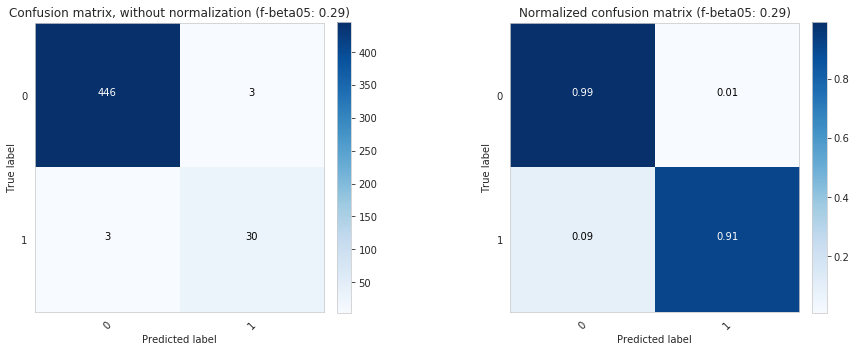

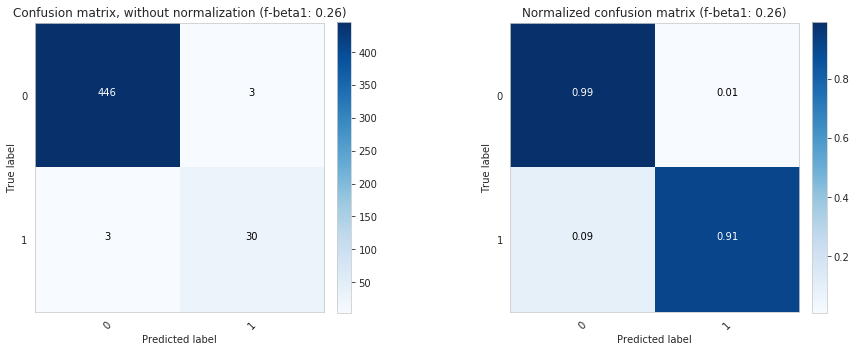

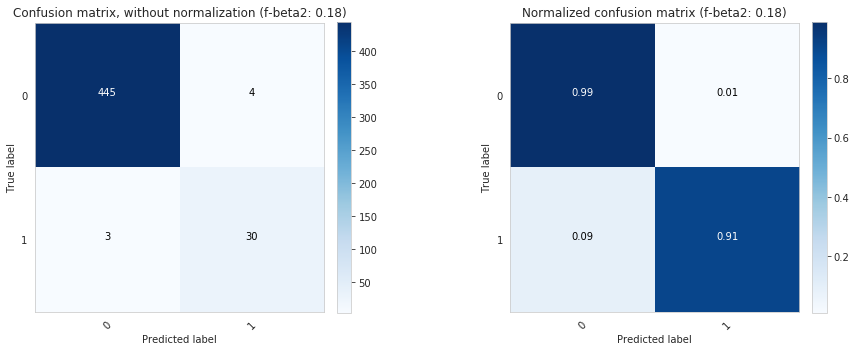



ROC Curve:


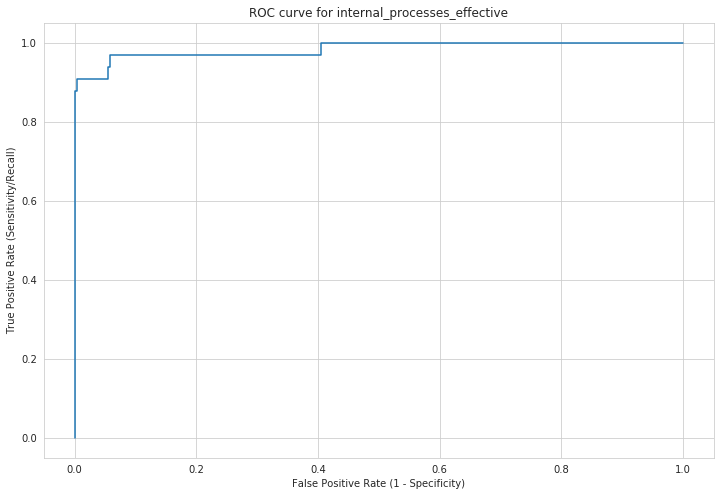

Predicted Probability Distribution:


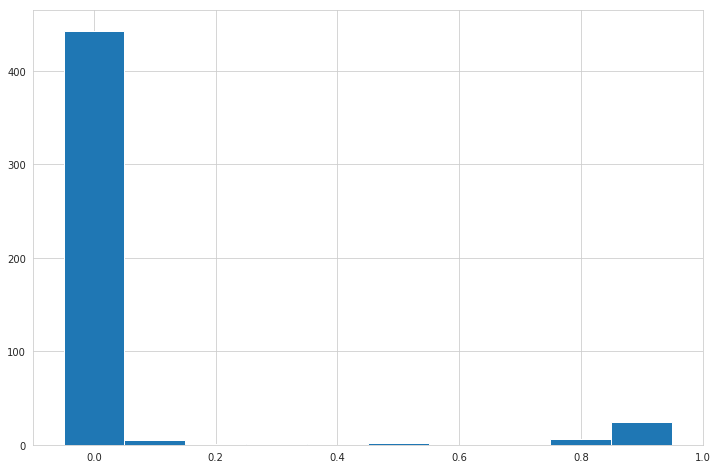



----------------------------------------------------------------------------------------------------


PARKING_TRANSPORTATION

Null Accuracy:	0.9771784232365145
AUC Score:	0.9988419224088014

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.995850622406639	0.995850622406639	0.9896265560165975	
Cohen's Kappa:	0.9145541570643503	0.9145541570643503	0.8096667193176433	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   1.0                 0.9958              0.9979              471                 
1                   0.8462              1.0                 0.9167              11                  
avg/total           0.9231              0.9979              0.9573              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   1.0                 0.9958              0.9979      

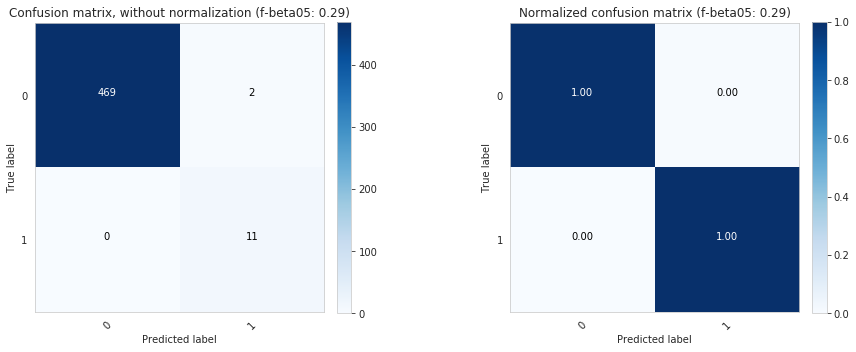

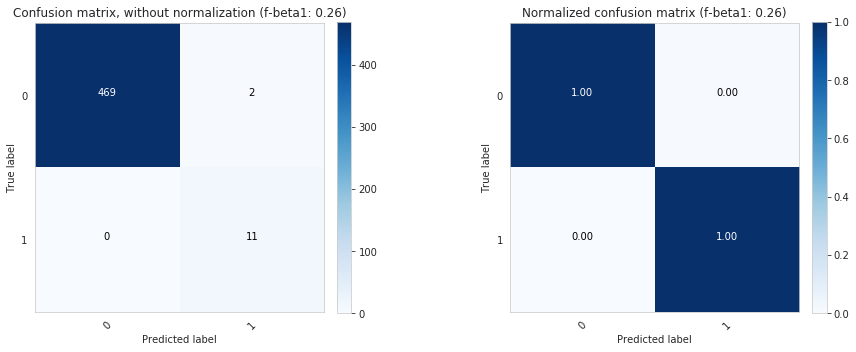

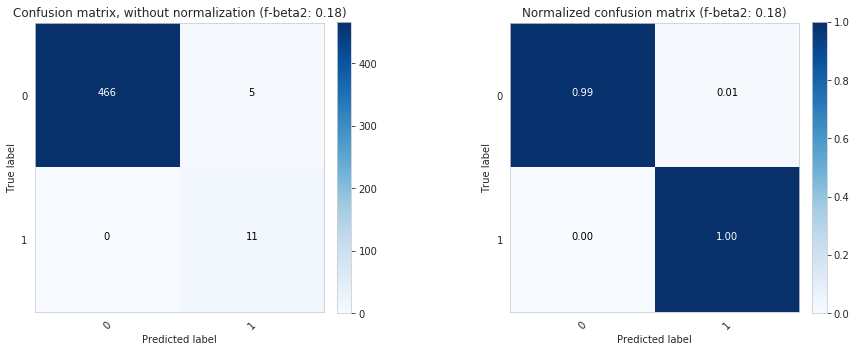



ROC Curve:


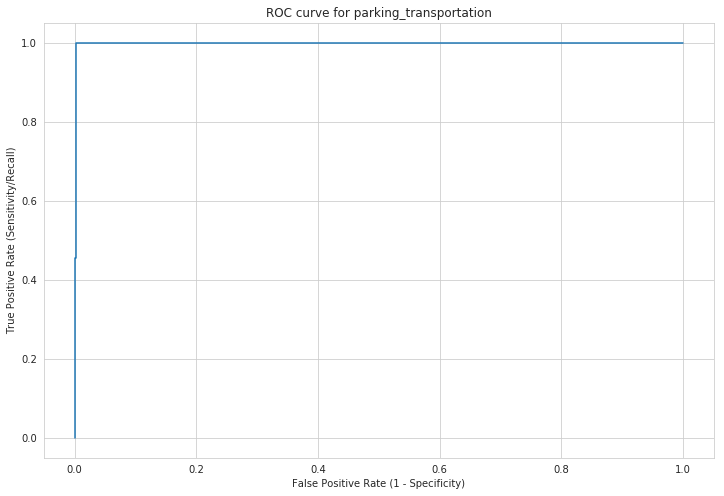

Predicted Probability Distribution:


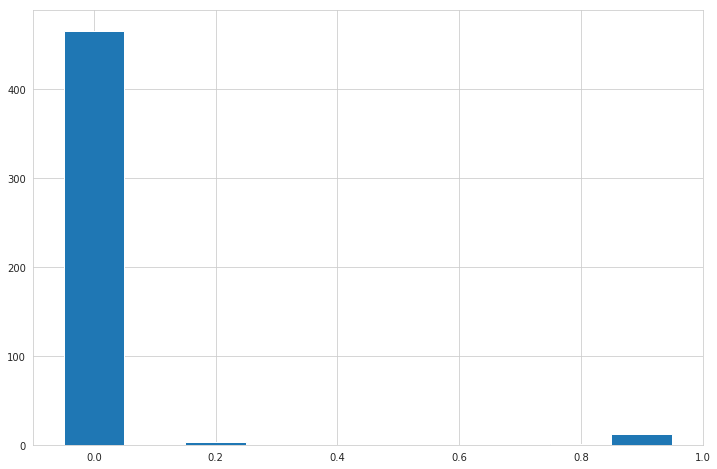



----------------------------------------------------------------------------------------------------


SALARY_PAY

Null Accuracy:	0.8423236514522822
AUC Score:	0.9813650505574281

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.941908713692946	0.9398340248962656	0.9377593360995851	
Cohen's Kappa:	0.7985431096250298	0.7923709931374587	0.7923368566176471	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9846              0.9458              0.9648              406                 
1                   0.7609              0.9211              0.8333              76                  
avg/total           0.8727              0.9334              0.8991              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9846              0.9433              0.9635              406

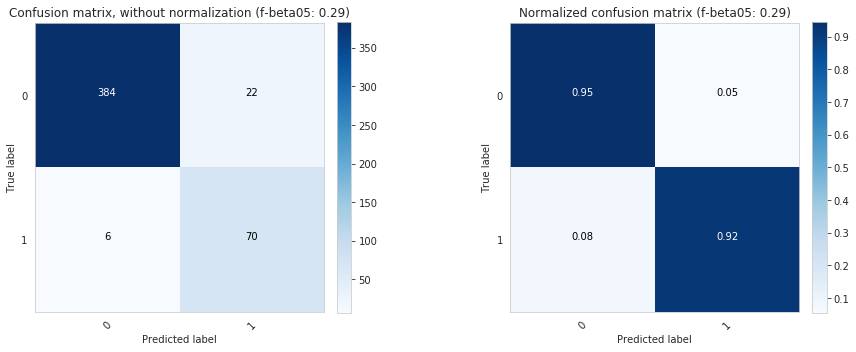

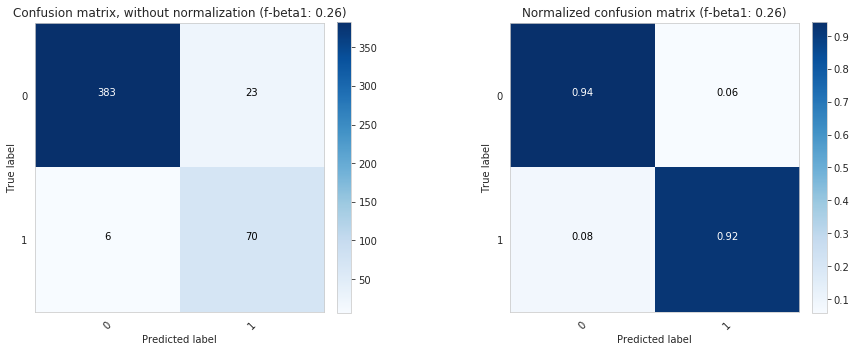

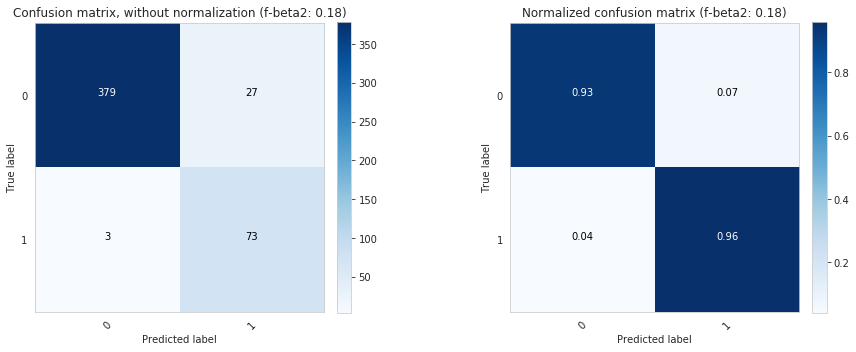



ROC Curve:


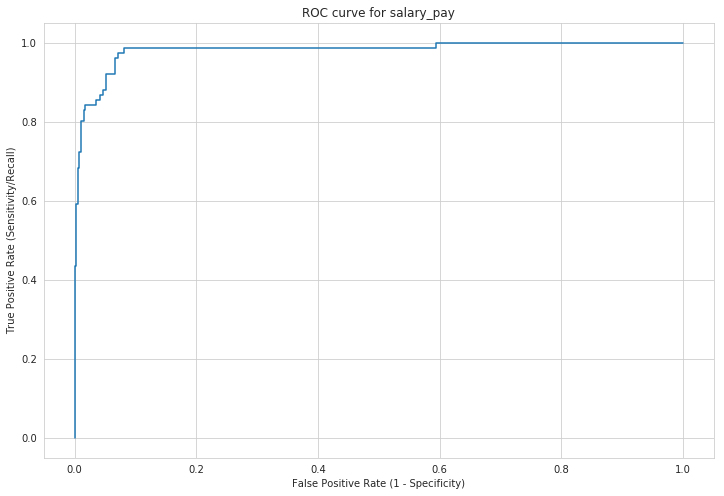

Predicted Probability Distribution:


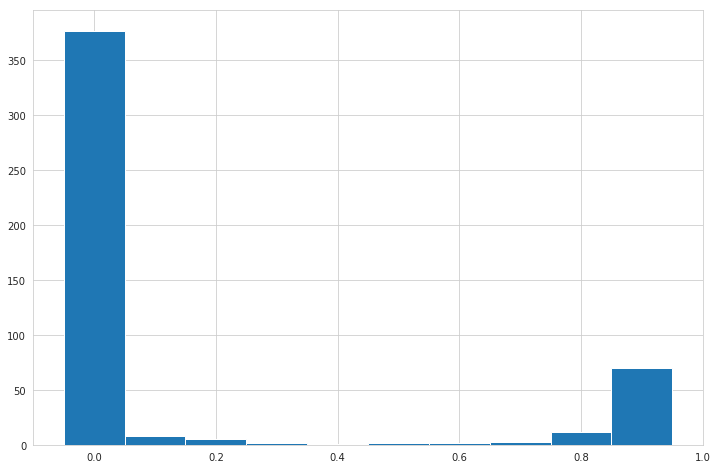



----------------------------------------------------------------------------------------------------


SATISFIED_WITH_DIVERSITY_PROGAMS

Null Accuracy:	0.9253112033195021
AUC Score:	0.9801320378674637

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9854771784232366	0.9854771784232366	0.975103734439834	
Cohen's Kappa:	0.8935713835089268	0.8935713835089268	0.828632377340602	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9911              0.9933              0.9922              446                 
1                   0.9143              0.8889              0.9014              36                  
avg/total           0.9527              0.9411              0.9468              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9911              0.9933              0.

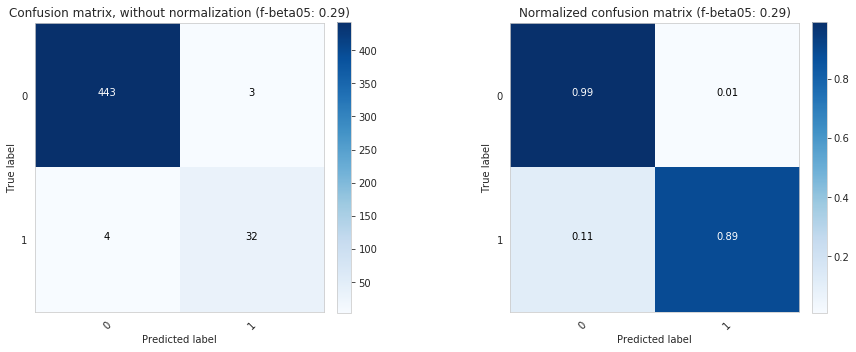

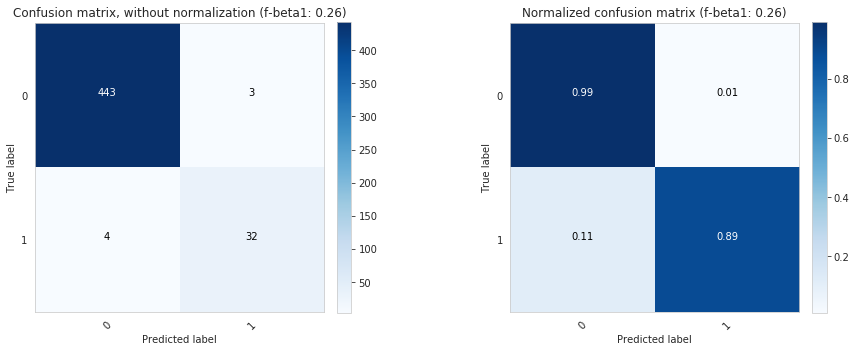

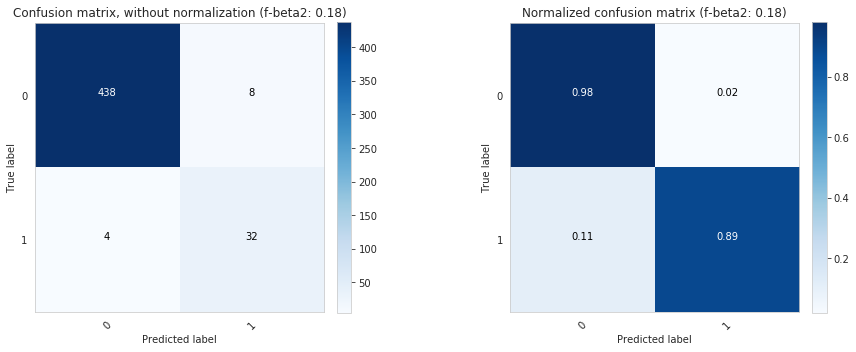



ROC Curve:


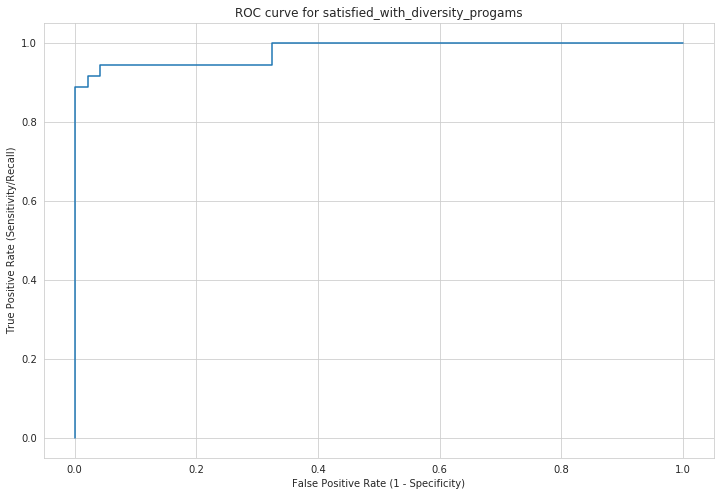

Predicted Probability Distribution:


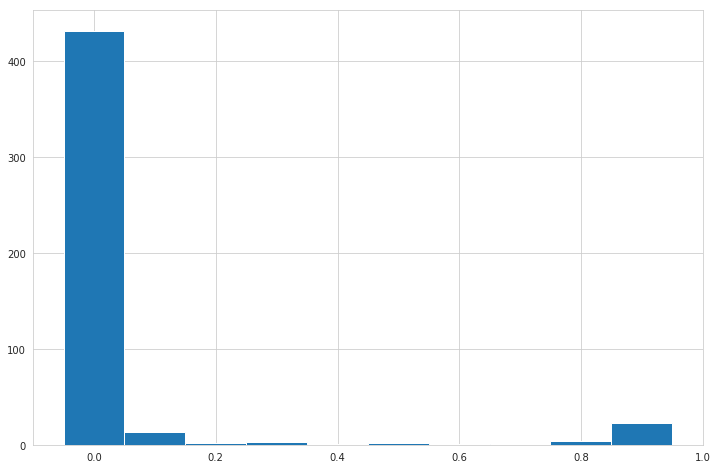



----------------------------------------------------------------------------------------------------


SUPERVISOR_EFFECTIVENESS_RESOLVES_STAFF_ISSUES

Null Accuracy:	0.8195020746887967
AUC Score:	0.9729666812163539

		f-beta05(0.29)		f-beta1(0.26)		f-beta2(0.18)
Accuracy:	0.9439834024896265	0.941908713692946	0.9356846473029046	
Cohen's Kappa:	0.8131622017400293	0.8070952802950173	0.7928117806927535	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9694              0.962               0.9657              395                 
1                   0.8333              0.8621              0.8475              87                  
avg/total           0.9014              0.912               0.9066              482                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9693              0.9595 

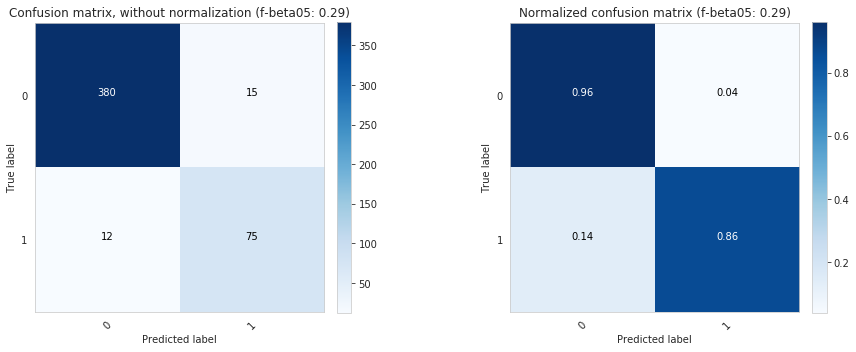

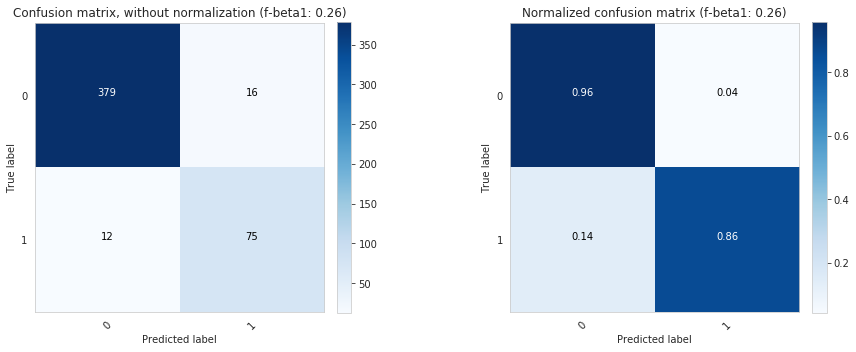

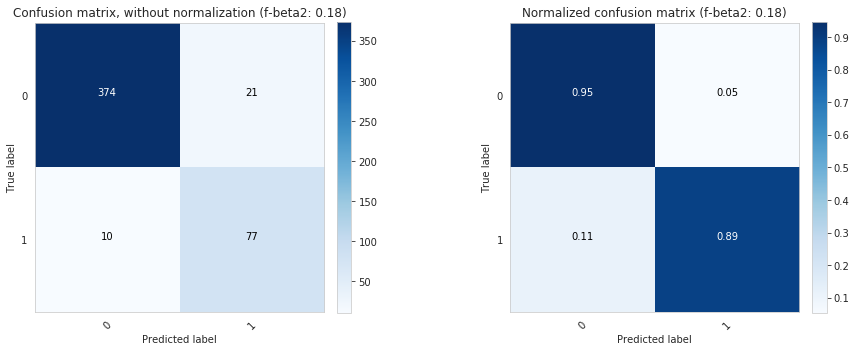



ROC Curve:


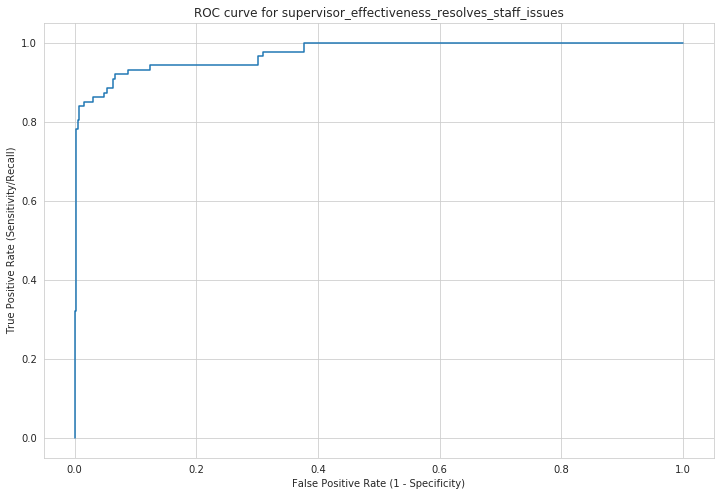

Predicted Probability Distribution:


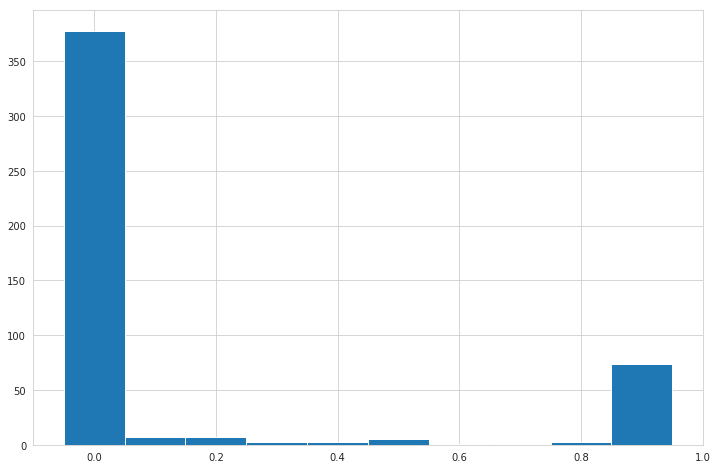



----------------------------------------------------------------------------------------------------




In [151]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

### Ensemble forwards and backwards passes

In [156]:
try:
    learn_fwd.purge(); learn_fwd = None;
    learn_bwd.purge(); learn_bwd = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass


bsz = 80
m_suf = '_multilabel'

learn_fwd = load_learner(STANDARD_THEME_SAW_PATH, file=f'fwd_export_clas{m_suf}.pkl')
data_fwd = load_data(STANDARD_THEME_SAW_PATH, f'data_cls_standard_theme_saw.pkl', bs=bsz)
learn_fwd.data = data_fwd

learn_bwd = load_learner(STANDARD_THEME_SAW_PATH, file=f'bwd_export_clas{m_suf}.pkl')
data_bwd = load_data(STANDARD_THEME_SAW_PATH, f'data_cls_standard_theme_saw.pkl', bs=bsz, backwards=True)
learn_bwd.data = data_bwd

In [157]:
probs_fwd, lbl_fwd, loss_fwd = learn_fwd.get_preds(ordered=True, with_loss=True)
probs_bwd, lbl_bwd, loss_bwd = learn_bwd.get_preds(ordered=True, with_loss=True)

probs_fwd.shape, probs_bwd.shape, loss_fwd.shape

(torch.Size([482, 25]), torch.Size([482, 25]), torch.Size([482, 25]))

In [158]:
loss_fwd.mean(), probs_bwd.mean(), (loss_fwd.mean() + probs_bwd.mean()) / 2

(tensor(0.0624), tensor(0.0959), tensor(0.0791))

In [159]:
probs_final = (probs_fwd + probs_bwd) / 2

#### Results

In [160]:
# determine optimal threshold based on desired f-score
threshold_f05 = metrics_util.best_fthresh(probs_fwd, lbl_fwd, beta=0.5, start=0.1, end=.3).item()
threshold_f1 = metrics_util.best_fthresh(probs_fwd, lbl_fwd, beta=1, start=0.1, end=.3).item()
threshold_f2 = metrics_util.best_fthresh(probs_fwd, lbl_fwd, beta=2, start=0.1, end=.3).item()

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_thresh(probs_fwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_thresh(probs_fwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_thresh(probs_fwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_thresh(probs_fwd, lbl_fwd, sigmoid=False)}')

Fowards Only
-------------
f05:	Optimal threshold = 0.28999999165534973	(Accuracy = 0.9808298945426941)
f1:	Optimal threshold = 0.28999999165534973		(Accuracy = 0.9808298945426941)
f2:	Optimal threshold = 0.11999999731779099	(Accuracy = 0.9685477018356323)

Accuracy: 0.9839833974838257


In [161]:
# determine optimal threshold based on desired f-score
threshold_f05 = metrics_util.best_fthresh(probs_bwd, lbl_fwd, beta=0.5, start=0.1, end=.3).item()
threshold_f1 = metrics_util.best_fthresh(probs_bwd, lbl_fwd, beta=1, start=0.1, end=.3).item()
threshold_f2 = metrics_util.best_fthresh(probs_bwd, lbl_fwd, beta=2, start=0.1, end=.3).item()

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_thresh(probs_bwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_thresh(probs_bwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_thresh(probs_bwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Backwards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05} (Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1} (Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2} (Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_thresh(probs_bwd, lbl_fwd, sigmoid=False)}')

Backwards Only
-------------
f05:	Optimal threshold = 0.28999999165534973 (Accuracy = 0.9800000190734863)
f1:	Optimal threshold = 0.25999999046325684 (Accuracy = 0.9791701436042786)
f2:	Optimal threshold = 0.18000000715255737 (Accuracy = 0.9748547673225403)

Accuracy: 0.9830705523490906


In [162]:
# determine optimal threshold based on desired f-score
threshold_f05 = metrics_util.best_fthresh(probs_final, lbl_fwd, beta=0.5, start=0.1, end=.3).item()
threshold_f1 = metrics_util.best_fthresh(probs_final, lbl_fwd, beta=1, start=0.1, end=.3).item()
threshold_f2 = metrics_util.best_fthresh(probs_final, lbl_fwd, beta=2, start=0.1, end=.3).item()

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_thresh(probs_final, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_thresh(probs_final, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_thresh(probs_final, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Ensemble\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05} (Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1} (Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2} (Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_thresh(probs_final, lbl_fwd, sigmoid=False)}')

Ensemble
-------------
f05:	Optimal threshold = 0.27000001072883606 (Accuracy = 0.9809128642082214)
f1:	Optimal threshold = 0.27000001072883606 (Accuracy = 0.9809128642082214)
f2:	Optimal threshold = 0.14000000059604645 (Accuracy = 0.9721991419792175)

Accuracy: 0.9862240552902222


In [163]:
final_valid_loss = (loss_fwd.mean() + probs_bwd.mean()) / 2

### Inference (ad-hoc documents)

In [164]:
print(STANDARD_THEME_SAW_LABELS)

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions', 'career_advancement', 'committed_to_diversity', 'communicates_essential_information', 'ethical_conduct_perform_responsibilities_spirit_of_cooperation', 'evaluated_fairly', 'experienced_discrimination', 'facilities_workspace_safety', 'faculty_value_contributions', 'favoritism_cliques', 'fear_of_retaliation_negative_consequences', 'feel_valued_by_department', 'flexibility_work_life_balance', 'good_use_of_skills', 'have_necessary_tools', 'have_voice_on_campus_valued_member_of_ucsd', 'internal_processes_effective', 'parking_transportation', 'salary_pay', 'satisfied_with_diversity_progams', 'supervisor_effectiveness_resolves_staff_issues']


In [165]:
test_comments = [
    'The parking situation REALLY sucks around here.  It needs to be fixed',
    'I LOVE working at UCSD!!!  It is wonderful',
    """Some staff are just uninformed.There is no support for solo-individual study (no closed off rooms).
        Once a guy (quite tall) walked in into the girl's restroom and used the stalls standing up. 
        There was no line in the guy's restroom. This happened when I done and was going to walk out. 
        I was extremely uncomfortable""",
    "I love UCSD!!! It is a terrible place to work!",
    "I was really uncomfortable to express my opinion!!!"
]

doc_probs, doc_preds, doc_toks = get_cls_doc_predictions(learn.model, vocab, tokenizer, test_comments, 
                                                         threshold=threshold_f1)

In [166]:
len(doc_probs), len(doc_probs), len(doc_toks)

(5, 5, 5)

In [167]:
for d_probs, d_preds, d_toks in zip(doc_probs, doc_preds, doc_toks):
    print(f'> {" ".join([t for t in d_toks])}\nProbabilities:\t{d_probs}\nPredictions:\t{d_preds}\n')

> xxmaj the parking situation xxup really sucks around here . xxmaj it needs to be fixed
Probabilities:	tensor([[1.0528e-03, 3.6806e-04, 1.0422e-05, 5.8459e-01, 6.7298e-06, 1.5420e-04,
         4.2937e-03, 1.5335e-05, 3.9416e-01, 4.4966e-05, 5.7059e-04, 2.6082e-04,
         2.7680e-02, 2.4321e-06, 2.8655e-03, 5.2708e-04, 4.1315e-02, 4.9226e-03,
         3.1551e-05, 8.6831e-03, 1.7436e-03, 9.9954e-01, 2.2576e-04, 1.2797e-01,
         7.4751e-04]])
Predictions:	tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0.])

> i xxup love working at xxup ucsd ! ! ! xxmaj it is wonderful
Probabilities:	tensor([[2.0281e-03, 1.6593e-03, 2.8571e-02, 3.9961e-06, 6.4121e-05, 1.0258e-05,
         2.2362e-05, 1.5864e-07, 9.6108e-01, 2.2346e-04, 2.0164e-04, 9.5819e-05,
         4.7478e-01, 8.5777e-05, 8.8569e-03, 7.7734e-01, 1.9416e-05, 9.8256e-05,
         3.3471e-05, 2.8007e-02, 3.8621e-05, 1.3018e-05, 2.2321e-04, 9.0019e-07,
         7.2098e

### Inference (batch ensemble)

In [168]:
import datetime
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

m_suf = '_multilabel'

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:1


In [169]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**lm_dtypes}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.BenchmarkSurveyType.str.startswith('SAW')].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(inf_df))

corpus_cols = ['AnswerText']  # ['question_text', 'answer_text']

37308


In [170]:
def concat_pool(raw_outputs):
    last_rnn_layer = raw_outputs[-1]
    bsz = last_rnn_layer.shape[0] 
    
    avg_pool = F.adaptive_avg_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    max_pool = F.adaptive_max_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    last_outp = last_rnn_layer[:,-1,:]

    return torch.cat([last_outp, max_pool, avg_pool], 1)

In [171]:
def get_classification_results(backwards:bool=False, m_suf:str='multilabel'):
    
    model_prefix = 'bwd' if backwards else 'fwd'
    
    # 1. grab learner, procs, and data
    inf_learn = load_learner(STANDARD_THEME_SAW_PATH, file=f'{model_prefix}_export_clas_{m_suf}.pkl')
    txt_procs = inf_learn.data.train_ds.processor
    inf_data = TextList.from_df(inf_df, cols=corpus_cols, processor=txt_procs).split_none().label_empty()
    
    # 2. define a suitable dataloader
    collate_fn = partial(pad_collate, pad_first=True, backwards=backwards)
    sampler = SortSampler(inf_data.train.x, key=[len(t) for t in inf_data.train.x.items].__getitem__)
    dl = DeviceDataLoader.create(inf_data.train, bs=128, sampler=sampler, collate_fn=collate_fn, device=device)
    
    # 3. get probs and document vectors
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    test_probs, doc_vecs, concat_doc_vecs = [], [], []
    with torch.no_grad():
        for index, (xb, yb) in enumerate(dl):
            if index % 1000 == 0:  print(index)

            # reset hidden state (if you don't do this you will OOM)
            inf_learn.model.reset()

            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            probs, raw_outputs, outputs = inf_learn.model(xb)

            test_probs.append(to_detach(probs))
            doc_vecs.append(to_detach(raw_outputs[-1][:,-1,:]))
            concat_doc_vecs.append(to_detach(concat_pool(raw_outputs)))

    all_probs = torch.cat(test_probs)
    all_vecs = torch.cat(doc_vecs)
    all_concat_vecs = torch.cat(concat_doc_vecs)

    # 4. ensure results are returned in order
    if hasattr(dl, 'sampler'):
        sampler_idxs = [i for i in dl.sampler]
        reverse_sampler = np.argsort(sampler_idxs)

        all_probs = all_probs[reverse_sampler]
        all_vecs = all_vecs[reverse_sampler]
        all_concat_vecs = all_concat_vecs[reverse_sampler]
        
    # 5. return ordered results
    inf_learn, inf_data = None, None; gc.collect()
    
    return all_probs, all_vecs, all_concat_vecs

In [172]:
%time

probs_fwd, vecs_fwd, concat_vecs_fwd = get_classification_results(backwards=False)
probs_bwd, vecs_bwd, concat_vecs_bwd = get_classification_results(backwards=True)

probs_final = (probs_fwd + probs_bwd) / 2

print(probs_final.shape)
print(probs_fwd.shape, vecs_fwd.shape, concat_vecs_fwd.shape)
print(probs_bwd.shape, vecs_bwd.shape, concat_vecs_bwd.shape)

0
torch.Size([37308, 25])
torch.Size([37308, 25]) torch.Size([37308, 400]) torch.Size([37308, 1200])
torch.Size([37308, 25]) torch.Size([37308, 400]) torch.Size([37308, 1200])


Add the probabilities of each label to `inf_df`

In [173]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS]
probs_df = pd.DataFrame(probs_final.numpy(), columns=prob_labels)
probs_df.head()

,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_on_campus_valued_member_of_ucsd,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues
0,0.001966,0.003236,0.007138,0.000055,0.000644,0.000236,0.001841,0.000519,0.006411,0.008533,0.000188,0.004777,0.000998,2.242436e-04,0.015509,0.001519,0.000250,0.000111,0.000058,0.001251,0.000567,0.000108,0.002254,0.227842,0.013337
1,0.000354,0.369099,0.005910,0.000124,0.031632,0.015927,0.000148,0.026522,0.000621,0.088738,0.000709,0.020805,0.000443,5.313401e-03,0.000283,0.002481,0.000002,0.001021,0.006299,0.078104,0.053181,0.000037,0.011311,0.001305,0.001978
2,0.020274,0.013428,0.008658,0.000003,0.030133,0.001399,0.122781,0.000748,0.002265,0.000115,0.037411,0.001322,0.001836,1.351636e-02,0.008201,0.002912,0.000127,0.002816,0.000034,0.000820,0.000233,0.000039,0.000080,0.090326,0.028742
3,0.001569,0.002198,0.003530,0.000011,0.011992,0.004316,0.000462,0.000737,0.098122,0.001072,0.003244,0.001835,0.048376,2.982281e-04,0.279516,0.001782,0.000162,0.000076,0.000016,0.051083,0.001013,0.000012,0.000092,0.026675,0.254416
4,0.002084,0.004016,0.001900,0.000212,0.000013,0.000109,0.000209,0.000064,0.381069,0.000013,0.000356,0.025103,0.000427,7.396955e-07,0.003671,0.000004,0.000805,0.000298,0.000188,0.011669,0.005880,0.000907,0.000843,0.046192,0.017681


In [174]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f1 threshold

In [175]:
for lbl in STANDARD_THEME_SAW_LABELS:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f1).astype(np.int64)

Include found thresholds

In [183]:
final_df['threshold_f05'] = threshold_f05
final_df['threshold_f1'] = threshold_f1
final_df['threshold_f2'] = threshold_f2

final_df['val_acc_f05'] = val_acc_f05
final_df['val_acc_f1'] = val_acc_f1
final_df['val_acc_f2'] = val_acc_f2

final_df['val_loss'] = final_valid_loss.item()

In [184]:
final_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_on_campus_valued_member_of_ucsd,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,pred_adequate_staffing,pred_advancement_and_training_opportunities,pred_appropriate_stress_work_assigned_equitably,pred_benefits,pred_better_ways_recognized_participate_in_decisions,pred_career_advancement,pred_committed_to_diversity,pred_communicates_essential_information,pred_ethical_conduct_perform_responsibilities_spirit_of_cooperation,pred_evaluated_fairly,pred_experienced_discrimination,pred_facilities_workspace_safety,pred_faculty_value_contributions,pred_favoritism_cliques,pred_fear_of_retaliation_negative_consequences,pred_feel_valued_by_department,pred_flexibility_work_life_balance,pred_good_use_of_skills,pred_have_necessary_tools,pred_have_voice_on_campus_valued_member_of_ucsd,pred_internal_processes_effective,pred_parking_transportation,pred_salary_pay,pred_satisfied_with_diversity_progams,pred_supervisor_effectiveness_resolves_staff_issues,threshold_f05,threshold_f1,threshold_f2,val_acc_f05,val_acc_f1,val_acc_f2,val_loss
0,69390,2576,no comment,NaN,English,110,9,SAW,UCSD,175922,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,455.0,3562,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,818.0,"HOUSING, DINING, HOSPITALITY",444.0,FACILITIES AND BUILDING SERVICES TOTAL STAFF,455.0,"FACILITIES AND BUILDING SERVICES ALARMS, LOCK & KEY",NaN,NaN,NaN,NaN,NaN,NaN,0.001966,0.003236,0.007138,0.000055,0.000644,0.000236,0.001841,0.000519,0.006411,0.008533,0.000188,0.004777,0.000998,2.242436e-04,0.015509,0.001519,0.000250,0.000111,0.000058,0.001251,0.000567,0.000108,0.002254,0.227842,0.013337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133
1,67496,9439,I have not found that submitting ideas ever does anything.,NaN,English,110,9,SAW,UCSD,175338,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,24300.0,3836,999999.0,UC San Diego,8000.0,VICE CHANCELLOR MARINE SCIENCES,24300.0,GEOSCIENCES RESEARCH DIV.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000354,0.369099,0.005910,0.000124,0.031632,0.015927,0.000148,0.026522,0.000621,0.088738,0.000709,0.020805,0.000443,5.313401e-03,0.000283,0.002481,0.000002,0.001021,0.006299,0.078104,0.053181,0.000037,0.011311,0.001305,0.001978,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.27,0.27,0.14,0.980913,0.980913,0.972199,0.079133
2,194619,13199,"When diversity gives special preference or priv

In [185]:
import datetime
final_df.to_csv(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_ensemble_predictions{m_suf}.csv', index=False)

### Save document vectors

In [186]:
%time 

np.save(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_fwd_concat_docvecs_d400{m_suf}.npy', concat_vecs_fwd.numpy())  
np.save(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_fwd_docvecs_d400{m_suf}.npy', vecs_fwd.numpy())

np.save(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_bwd_concat_docvecs_d400{m_suf}.npy', concat_vecs_bwd.numpy())  
np.save(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_bwd_docvecs_d400{m_suf}.npy', vecs_bwd.numpy())

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.11 µs


### Playground

In [187]:
final_df.iloc[0].threshold_f05, final_df.iloc[0].threshold_f1, final_df.iloc[0].threshold_f2

(0.27000001072883606, 0.27000001072883606, 0.14000000059604645)

In [188]:
len(learn.layer_groups)

5

In [189]:
[ print(f'{lg}\n') for lg in learn.layer_groups ]

Sequential(
  (0): Embedding(39904, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(39904, 400, padding_idx=1)
  )
)

Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)

Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)

Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)

Sequential(
  (0): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=50, out_features=25, bias=True)
    )
  )
)



[None, None, None, None, None]